<a href="https://colab.research.google.com/github/antoalli/AlliDataScience/blob/master/bioinformatics_proj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

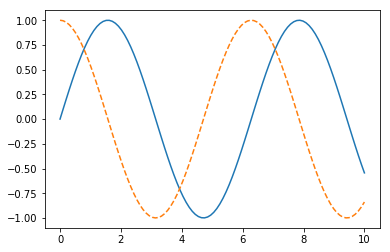

In [0]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 10, 100)

fig = plt.figure()
plt.plot(x, np.sin(x), '-')
plt.plot(x, np.cos(x), '--')

In [0]:
!pip install seaborn

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# tensorboard - Logger Class
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import numpy as np
import tensorflow as tf
from PIL import Image

try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO  # Python 3.x


class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        if not os.path.exists(log_dir):
          os.makedirs(log_dir)
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            if not isinstance(img, Image.Image):
                img = Image.fromarray(img)
            img.save(s, format='png')
            # scipy.misc.toimage(img).save(s, format="png") <--- deprecated

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.size[0],
                                       width=img.size[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)

    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values ** 2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

In [0]:
import time
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPooling2D, Flatten, Dropout

# loading mnist
from keras.datasets import mnist

In [0]:
# useless, just testing if tensorflow is working on GPU device
import tensorflow as tf
with tf.Session() as sess:
  devices = sess.list_devices()
  print(devices)
  
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 2185843458374364424), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3135428019974710573), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 7289357434471437217), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 14892338381, 4019644397500747613)]
[[22. 28.]
 [49. 64.]]


In [0]:
# mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, 
                                                 random_state=42)

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)

print("x_train shape: ", x_train.shape)
print("x_val shape: ", x_val.shape)
print("x_test shape: ", x_test.shape)

print("labels: ", np.unique(y_train))

x_train shape:  (48000, 28, 28, 1)
x_val shape:  (12000, 28, 28, 1)
x_test shape:  (10000, 28, 28, 1)
labels:  [0 1 2 3 4 5 6 7 8 9]


### Notare la differenza di trainable parameters fra i 2 modelli !!!

In [0]:
"""
# Building MODEL 1 - DO NOT RUN!
# sess.close()
tf.reset_default_graph()

# model 1
inputs = Input(shape=(28, 28, 1))
x = tfp.layers.Convolution2DFlipout(32, (5, 5), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)
x = tfp.layers.Convolution2DFlipout(64, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = tfp.layers.DenseFlipout(128, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = tfp.layers.DenseFlipout(10, activation=None)(x)  # changed output shape 3 ==> 10

model = Model(inputs, outputs)
model.summary()
"""

"\n#\xa0Building MODEL 1 - DO NOT RUN!\n# sess.close()\ntf.reset_default_graph()\n\n# model 1\ninputs = Input(shape=(28, 28, 1))\nx = tfp.layers.Convolution2DFlipout(32, (5, 5), activation='relu', padding='same')(inputs)\nx = MaxPooling2D((2, 2))(x)\nx = tfp.layers.Convolution2DFlipout(64, (5, 5), activation='relu', padding='same')(x)\nx = MaxPooling2D((2, 2))(x)\n\nx = Flatten()(x)\nx = tfp.layers.DenseFlipout(128, activation='relu')(x)\nx = Dropout(0.25)(x)\noutputs = tfp.layers.DenseFlipout(10, activation=None)(x)  # changed output shape 3 ==> 10\n\nmodel = Model(inputs, outputs)\nmodel.summary()\n"

In [0]:
# model 2 - USE THIS!
# defining model 2
inputs = Input(shape=(28, 28, 1))
x = tfp.layers.Convolution2DReparameterization(32, kernel_size=5,  padding="SAME", activation=tf.nn.relu)(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2],  strides=[2, 2],  padding="SAME")(x)
x = tfp.layers.Convolution2DReparameterization(64, kernel_size=5,  padding="SAME",  activation=tf.nn.relu)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2], padding="SAME")(x)
x = tf.keras.layers.Flatten()(x)
x = tfp.layers.DenseFlipout(1024, activation=tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.50)(x)  # fixing dropout prob?
outputs = tfp.layers.DenseFlipout(10)(x)
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_reparameterization (C (None, 28, 28, 32)        1632      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_reparameterization_1  (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1024)              642355

In [0]:
# FUNDAMENTAL
x = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32)
y = tf.placeholder(shape=[None], dtype=tf.int32)
n = tf.placeholder(shape=[], dtype=tf.float32)

logits = model(x)
probs = tf.nn.softmax(logits, axis=1)
labels_distribution = tfp.distributions.Categorical(logits=logits)
log_probs = labels_distribution.log_prob(y)

neg_log_likelihood = -tf.reduce_mean(log_probs)
kl = sum(model.losses) / len(x_train)
elbo_loss = neg_log_likelihood + kl

correct_preds = tf.equal(tf.cast(y, dtype=tf.int64), tf.argmax(probs, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

# OPTIMIZER PARAMS: from Adam paper, this is a sort of good default settings
init_lr = 0.001
b1 = 0.9
b2 = 0.999  # should be close to 1
e = 1e-08

optimizer = tf.train.AdamOptimizer(learning_rate=init_lr, beta1=b1, beta2=b2, epsilon=e)
train_op = optimizer.minimize(elbo_loss)

In [0]:
tb_dir = '/content/drive/My Drive/data_bio/tb_logs'
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)

!ls '/content/drive/My Drive/data_bio/tb_logs'
# !rm -r '/content/drive/My Drive/data_bio/tb_logs'

1564149373  1564307190	1564307535  1564323247	1564347842  1564408087
1564149915  1564307284	1564307559  1564323328	1564382656  1564469865
1564150881  1564307330	1564308382  1564323785	1564408057


In [0]:
%load_ext tensorboard
%tensorboard --logdir '/content/drive/My Drive/data_bio/tb_logs'

In [0]:
# train loop
# Alli, working, simple op!
import time  # logging purpose
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
tb_logger = Logger('/content/drive/My Drive/data_bio/tb_logs/' + str(int(time.time())))
batch_size = 64
n_iter = 1000
show_step = 100

history_loss_train = []
history_acc_train = []
history_loss_val = []
history_acc_val = []

for i in range(n_iter):
  batch_indices = np.random.choice(len(x_train), batch_size, replace=False)
  batch_x = x_train[batch_indices] 
  batch_y = y_train[batch_indices]

  feed_dict = {x: batch_x, y: batch_y, n: batch_size}
  sess.run(train_op, feed_dict=feed_dict )

  temp_loss, temp_acc = sess.run([elbo_loss, accuracy], 
                                        feed_dict=feed_dict)

  history_loss_train.append(temp_loss)
  history_acc_train.append(temp_acc)

  if (i+1) % show_step == 0:
    print ('-' * 70)
    print ('Iteration: ' + str(i+1) + '  Train Loss: ' + str(temp_loss) 
           + '  Train Accuracy: ' + str(temp_acc))
    tb_logger.scalar_summary('it Train loss', temp_loss, i)
    tb_logger.scalar_summary('it Train Accuracy', temp_acc, i)


  batch_indices = np.random.choice(len(x_val), batch_size, replace=False)
  batch_x = x_val[batch_indices] 
  batch_y = y_val[batch_indices]

  feed_dict = {x: batch_x, y: batch_y, n: batch_size}
  sess.run(train_op, feed_dict=feed_dict)

  temp_loss, temp_acc = sess.run([elbo_loss, accuracy], 
                                        feed_dict=feed_dict)

  history_loss_val.append(temp_loss)
  history_acc_val.append(temp_acc)
  if (i+1) % show_step == 0:
    tb_logger.scalar_summary('it Val. loss', temp_loss, i)
    tb_logger.scalar_summary('it Val. Accuracy', temp_acc, i)

KeyboardInterrupt: ignored

# Train 2 (Same of above but Added Uncertainty Analysis)

In [0]:
from matplotlib import figure  # pylint: disable=g-import-not-at-top
from matplotlib.backends import backend_agg


# utility/plot functions from tfp
def plot_weight_posteriors(names, qm_vals, qs_vals, fname):
  """Save a PNG plot with histograms of weight means and stddevs.
  Args:
    names: A Python `iterable` of `str` variable names.
    qm_vals: A Python `iterable`, the same length as `names`,
      whose elements are Numpy `array`s, of any shape, containing
      posterior means of weight varibles.
    qs_vals: A Python `iterable`, the same length as `names`,
      whose elements are Numpy `array`s, of any shape, containing
      posterior standard deviations of weight varibles.
    fname: Python `str` filename to save the plot to.
  """
  fig = figure.Figure(figsize=(6, 3))
  canvas = backend_agg.FigureCanvasAgg(fig)

  ax = fig.add_subplot(1, 2, 1)
  for n, qm in zip(names, qm_vals):
    sns.distplot(qm.flatten(), ax=ax, label=n)
  ax.set_title("weight means")
  ax.set_xlim([-1.5, 1.5])
  ax.legend()

  ax = fig.add_subplot(1, 2, 2)
  for n, qs in zip(names, qs_vals):
    sns.distplot(qs.flatten(), ax=ax)
  ax.set_title("weight stddevs")
  ax.set_xlim([0, 1.])

  fig.tight_layout()
  canvas.print_figure(fname, format="png")
  print("saved {}".format(fname))

  

def plot_heldout_prediction(input_vals, probs,
                            fname, n=10, title=""):
  """Save a PNG plot visualizing posterior uncertainty on heldout data.
  Args:
    input_vals: A `float`-like Numpy `array` of shape
      `[num_heldout] + IMAGE_SHAPE`, containing heldout input images.
    probs: A `float`-like Numpy array of shape `[num_monte_carlo,
      num_heldout, num_classes]` containing Monte Carlo samples of
      class probabilities for each heldout sample.
    fname: Python `str` filename to save the plot to.
    n: Python `int` number of datapoints to vizualize.
    title: Python `str` title for the plot.
  """
  fig = figure.Figure(figsize=(9, 3*n))
  canvas = backend_agg.FigureCanvasAgg(fig)
  for i in range(n):
    ax = fig.add_subplot(n, 3, 3*i + 1)
    ax.imshow(input_vals[i, :].reshape(IMAGE_SHAPE[:-1]), interpolation="None")

    ax = fig.add_subplot(n, 3, 3*i + 2)
    for prob_sample in probs:
      sns.barplot(np.arange(10), prob_sample[i, :], alpha=0.1, ax=ax)
      ax.set_ylim([0, 1])
    ax.set_title("posterior samples")

    ax = fig.add_subplot(n, 3, 3*i + 3)
    sns.barplot(np.arange(10), np.mean(probs[:, i, :], axis=0), ax=ax)
    ax.set_ylim([0, 1])
    ax.set_title("predictive probs")
  fig.suptitle(title)
  fig.tight_layout()

  canvas.print_figure(fname, format="png")
  print("saved {}".format(fname))

In [0]:
# training logic 2 - mandatory
max_steps = 5000
batch_size = 64
viz_steps = 500
num_monte_carlo = 50
viz_dir = '/content/drive/My Drive/data_bio/data'
HAS_SEABORN = True
IMAGE_SHAPE = [28,28,1]

# Extract weight posterior statistics for layers with weight distributions
# for later visualization.
names = []
qmeans = []
qstds = []
for i, layer in enumerate(model.layers):
  try:
    q = layer.kernel_posterior
  except AttributeError:
    continue
  names.append("Layer {}".format(i))
  qmeans.append(q.mean())
  qstds.append(q.stddev())

In [0]:
import os.path as osp
print(tb_dir)

/content/drive/My Drive/data_bio/tb_logs


In [0]:
# train loop, added uncertainty
# TODO: Alli, should be done Epoch-Batch division as in PyTorch?

import time  # logging purpose
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
curr_time_str = str(int(time.time()))
tb_logger = Logger(osp.join(tb_dir, curr_time_str))
batch_size = 64
n_iter = 3000
show_step = 100

history_loss_train = []
history_acc_train = []
history_loss_val = []
history_acc_val = []

init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                     tf.compat.v1.local_variables_initializer())
with tf.compat.v1.Session() as sess:
  saver = tf.train.Saver()
  sess.run(init_op)
  
  for i in range(n_iter):
    batch_indices = np.random.choice(len(x_train), batch_size, replace=False)
    batch_x = x_train[batch_indices] 
    batch_y = y_train[batch_indices]

    feed_dict = {x: batch_x, y: batch_y, n: batch_size}
    sess.run(train_op, feed_dict=feed_dict )

    temp_loss, temp_acc = sess.run([elbo_loss, accuracy], 
                                        feed_dict=feed_dict)

    history_loss_train.append(temp_loss)
    history_acc_train.append(temp_acc)

    if (i+1) % show_step == 0:
      print ('-' * 70)
      print ('Iteration: ' + str(i+1) + '  Train Loss: ' + str(temp_loss) 
            + '  Train Accuracy: ' + str(temp_acc))
      tb_logger.scalar_summary('it Train loss', temp_loss, i)
      tb_logger.scalar_summary('it Train Accuracy', temp_acc, i)


    batch_indices = np.random.choice(len(x_val), batch_size, replace=False)
    batch_x = x_val[batch_indices]  # Val 
    batch_y = y_val[batch_indices]  # Val

    feed_dict = {x: batch_x, y: batch_y, n: batch_size}  # ***
    sess.run(train_op, feed_dict=feed_dict)

    temp_loss, temp_acc = sess.run([elbo_loss, accuracy], 
                                        feed_dict=feed_dict)

    history_loss_val.append(temp_loss)
    history_acc_val.append(temp_acc)
  
    if (i+1) % show_step == 0:
      print ('Iteration: ' + str(i+1) + '  Val. Loss: ' + str(temp_loss) 
             + '  Val. Accuracy: ' + str(temp_acc))
      tb_logger.scalar_summary('it Val. loss', temp_loss, i)
      tb_logger.scalar_summary('it Val. Accuracy', temp_acc, i)
    
    if (i+1) % viz_steps == 0:
      # Compute log prob of heldout set by averaging draws from the model:
      # p(heldout | train) = int_model p(heldout|model) p(model|train)
      #                   ~= 1/n * sum_{i=1}^n p(heldout | model_i)
      # where model_i is a draw from the posterior p(model|train).
      probs = np.asarray([sess.run((labels_distribution.probs), feed_dict=feed_dict) for _ in range(num_monte_carlo)])
      mean_probs = np.mean(probs, axis=0)

      # Placeholders! If you change dataset change dim!!!
      images = tf.placeholder(tf.float32,shape=[None,28,28,1])
      labels = tf.placeholder(tf.int32,shape=[None,])

      image_vals, label_vals = sess.run((images, labels), feed_dict={images: batch_x, labels: batch_y})
  
      heldout_lp = np.mean(np.log(mean_probs[np.arange(mean_probs.shape[0]),
                                           label_vals.flatten()]))
      print(" ... Held-out nats: {:.3f}".format(heldout_lp))
      qm_vals, qs_vals = sess.run((qmeans, qstds))
      if HAS_SEABORN:
        plot_weight_posteriors(names, qm_vals, qs_vals,fname=os.path.join(viz_dir, "step{:05d}_weights.png".format(i)))
        plot_heldout_prediction(image_vals, probs,fname=os.path.join(viz_dir,"step{:05d}_pred.png".format(i)), title="mean heldout logprob {:.2f}".format(heldout_lp))
  
  saver.save(sess, 'my_test_model')


----------------------------------------------------------------------
Iteration: 100  Train Loss: 167.007  Train Accuracy: 0.875
Iteration: 100  Val. Loss: 166.75983  Val. Accuracy: 0.859375
----------------------------------------------------------------------
Iteration: 200  Train Loss: 159.06892  Train Accuracy: 0.890625
Iteration: 200  Val. Loss: 158.9065  Val. Accuracy: 0.953125
----------------------------------------------------------------------
Iteration: 300  Train Loss: 150.53249  Train Accuracy: 0.96875
Iteration: 300  Val. Loss: 150.4704  Val. Accuracy: 0.953125
----------------------------------------------------------------------
Iteration: 400  Train Loss: 141.81908  Train Accuracy: 0.96875
Iteration: 400  Val. Loss: 141.63466  Val. Accuracy: 0.984375
----------------------------------------------------------------------
Iteration: 500  Train Loss: 132.86006  Train Accuracy: 0.9375
Iteration: 500  Val. Loss: 132.79399  Val. Accuracy: 0.953125
 ... Held-out nats: -0.090

In [0]:
!cd 'checkpoint'
!ls

/bin/bash: line 0: cd: checkpoint: Not a directory
checkpoint  my_test_model.data-00000-of-00001  my_test_model.meta
drive	    my_test_model.index		       sample_data


# MNIST Uncertainty

In [0]:
import matplotlib.pyplot as plt


def plot_heldout_prediction(input_vals, probs, n=10, title=""):
  fig = plt.figure(figsize=(9, 3*n))
  canvas = backend_agg.FigureCanvasAgg(fig)
  for i in range(n):
    ax = fig.add_subplot(n, 3, 3*i + 1)
    ax.imshow(input_vals[i, :].reshape(IMAGE_SHAPE[:-1]), interpolation="None")

    ax = fig.add_subplot(n, 3, 3*i + 2)
    for prob_sample in probs:
      sns.barplot(np.arange(10), prob_sample[i, :], alpha=0.1, ax=ax)
      ax.set_ylim([0, 1])
    ax.set_title("posterior samples")

    ax = fig.add_subplot(n, 3, 3*i + 3)
    sns.barplot(np.arange(10), np.mean(probs[:, i, :], axis=0), ax=ax)
    ax.set_ylim([0, 1])
    ax.set_title("predictive probs")
  fig.suptitle(title)
  fig.tight_layout()
  plt.show()

In [0]:
# MNIST Analysis
# FEED DATA as "feed dict"
print(len(x_val))
batch_indices = np.random.choice(len(x_val), 100, replace=False)  # ne scelgo 100 a caso
batch_x = x_val[batch_indices] 
batch_y = y_val[batch_indices]

print("Labels: ", np.unique(batch_y))

12000
Labels:  [0 1 2 3 4 5 6 7 8 9]


 ... Held-out nats: -0.023


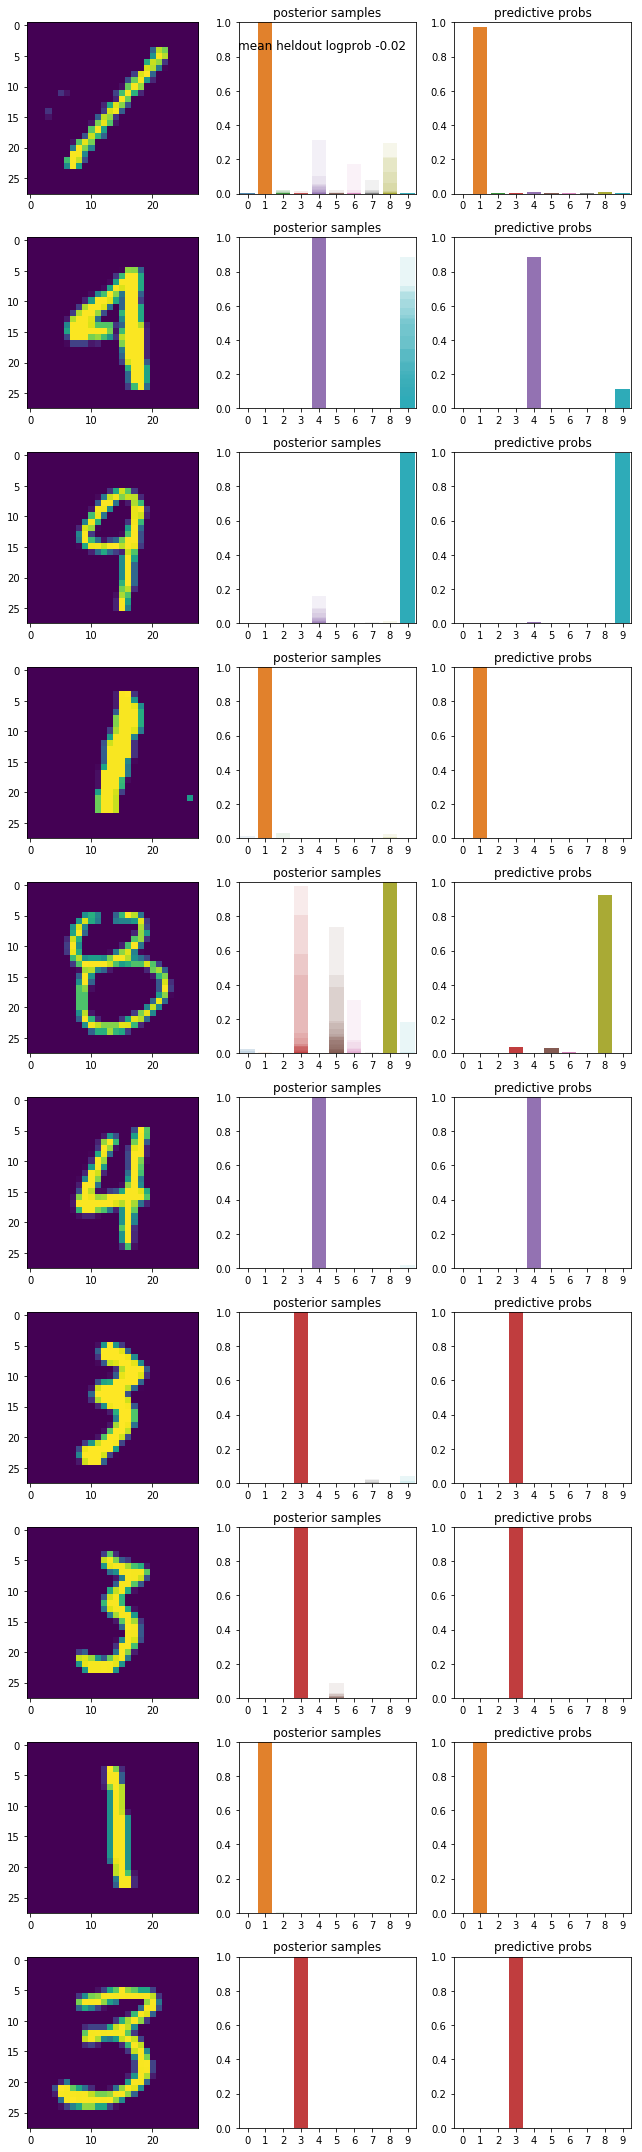

In [0]:
feed_dict = {x: batch_x, y: batch_y, n: batch_x.shape[0]}
init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                     tf.compat.v1.local_variables_initializer())

with tf.compat.v1.Session() as sess:
  sess.run(init_op)
  saver = tf.train.import_meta_graph('my_test_model.meta')
  saver.restore(sess,tf.train.latest_checkpoint('./'))
  
  # Compute log prob of heldout set by averaging draws from the model:
  # p(heldout | train) = int_model p(heldout|model) p(model|train)
  #                   ~= 1/n * sum_{i=1}^n p(heldout | model_i)
  # where model_i is a draw from the posterior p(model|train).
  probs = np.asarray([sess.run((labels_distribution.probs), feed_dict=feed_dict) for _ in range(num_monte_carlo)])
  mean_probs = np.mean(probs, axis=0)

  # Placeholders! If you change dataset change dim!!!
  images = tf.placeholder(tf.float32,shape=[None,28,28,1])
  labels = tf.placeholder(tf.int32,shape=[None,])

  image_vals, label_vals = sess.run((images, labels), feed_dict={images: batch_x, labels: batch_y})
  
  heldout_lp = np.mean(np.log(mean_probs[np.arange(mean_probs.shape[0]),
                                           label_vals.flatten()]))
  print(" ... Held-out nats: {:.3f}".format(heldout_lp))

  qm_vals, qs_vals = sess.run((qmeans, qstds))


  plot_heldout_prediction(image_vals, probs, title="mean heldout logprob {:.2f}".format(heldout_lp), n=10)

In [0]:
logits = model(x)
op_logprobs = tf.nn.log_softmax(logits, axis=1)
with tf.compat.v1.Session() as sess:
  sess.run(init_op)
  saver = tf.train.import_meta_graph('my_test_model.meta')
  saver.restore(sess,tf.train.latest_checkpoint('./'))
  logprobs = np.asarray([sess.run((op_logprobs), feed_dict=feed_dict) for _ in range(num_monte_carlo)])

In [0]:
print(logprobs.shape)

(100, 100, 10)


In [0]:
from matplotlib import colors

def imshow(img):
    npimg = img / 2 + 0.5     # unnormalize    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()
    
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

def test_batch(images, probs, labels, plot=True, threshold=0.2):
    y = probs
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if plot:
            print("Real: ",labels[i])
            imshow(images[i].squeeze())
            plt.show()
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
            #print(prob)
        
            if prob > threshold: #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if plot:
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if highlight:
            
                highted_something = True
                
                if plot:

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if plot:
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if highted_something:
            predicted_for_images+=1
            if labels[i]==predicted:
                if plot:
                    print("Correct")
                correct_predictions +=1.0
            else:
                if plot:
                    print("Incorrect :()")
        else:
            if plot:
                print("Undecided.")
        '''
        if plot:
            imshow(images[i].squeeze())
        '''
        
        print('-' * 25)  # just a separator
        
    
    if plot:
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

Real:  1


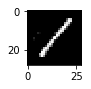

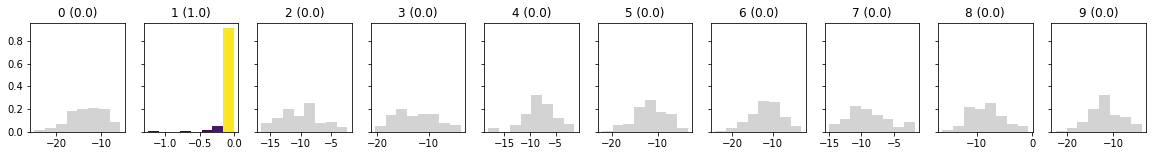

Correct
-------------------------
Real:  4


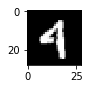

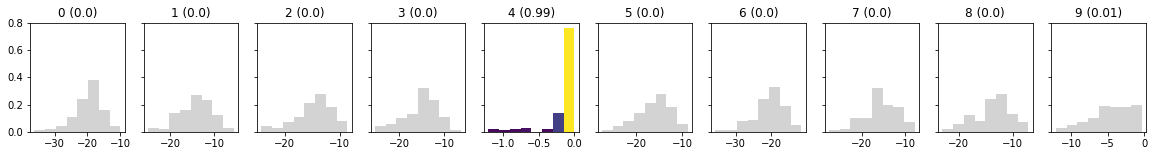

Correct
-------------------------
Real:  9


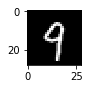

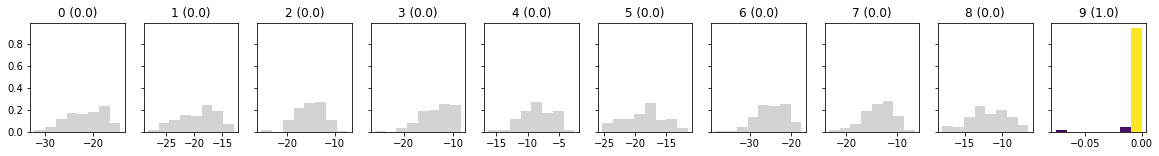

Correct
-------------------------
Real:  1


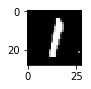

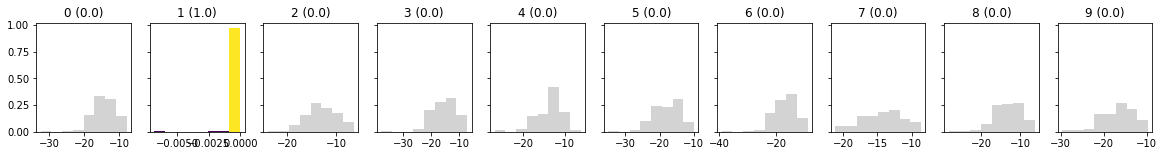

Correct
-------------------------
Real:  8


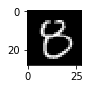

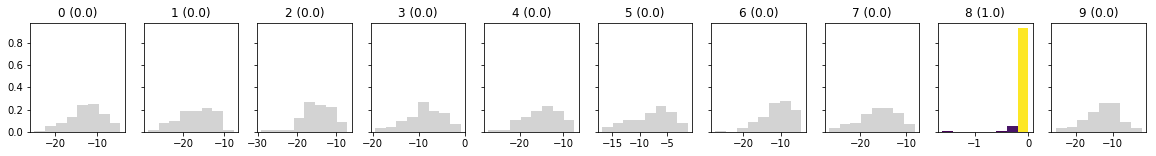

Correct
-------------------------
Real:  4


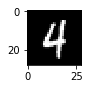

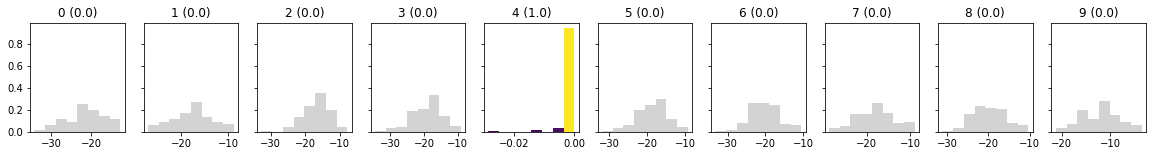

Correct
-------------------------
Real:  3


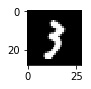

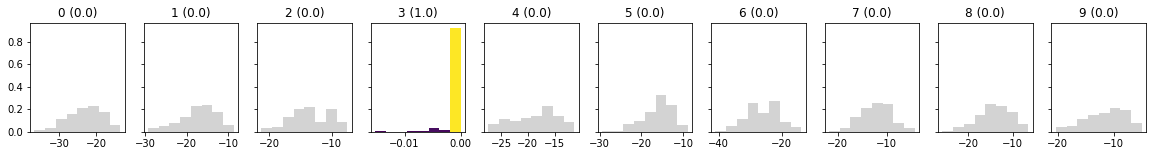

Correct
-------------------------
Real:  3


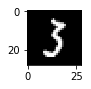

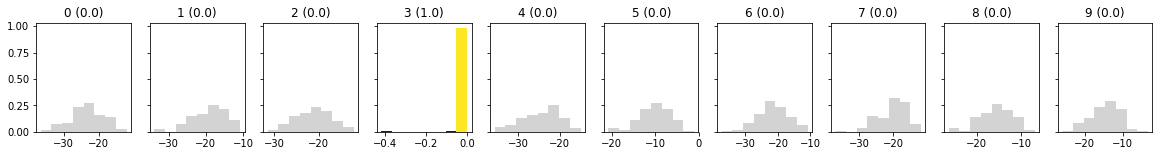

Correct
-------------------------
Real:  1


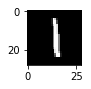

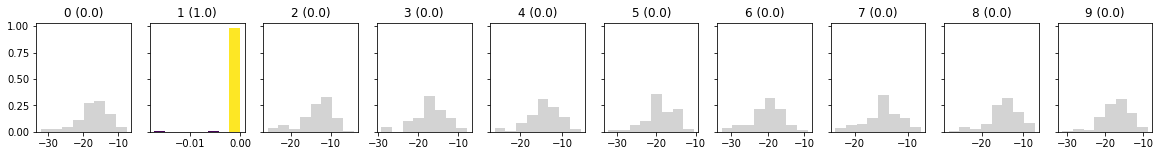

Correct
-------------------------
Real:  3


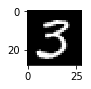

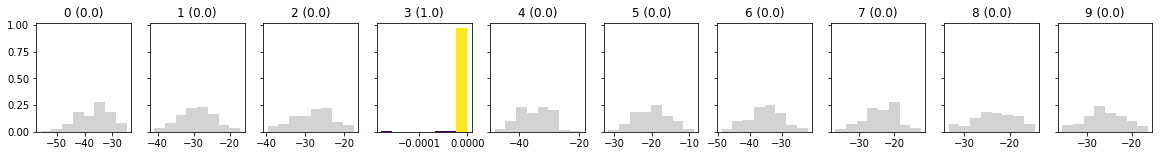

Correct
-------------------------
Real:  6


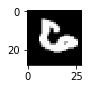

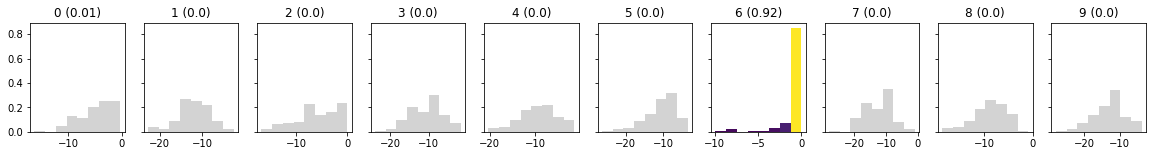

Correct
-------------------------
Real:  3


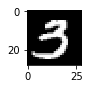

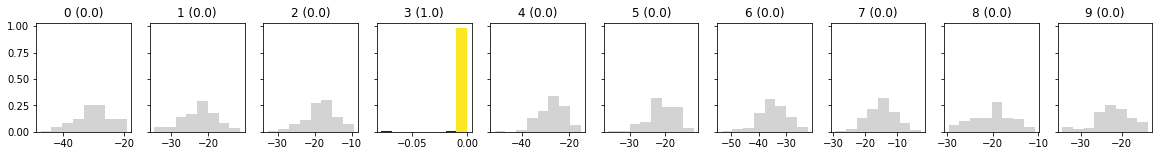

Correct
-------------------------
Real:  3


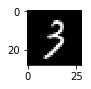

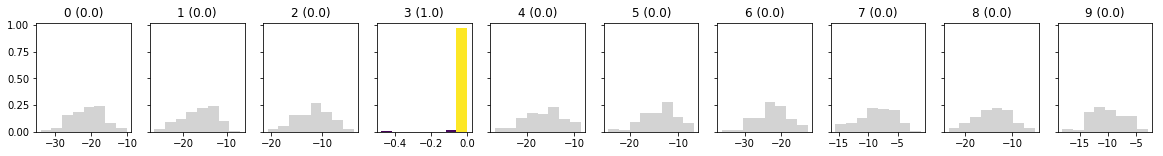

Correct
-------------------------
Real:  1


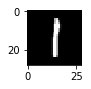

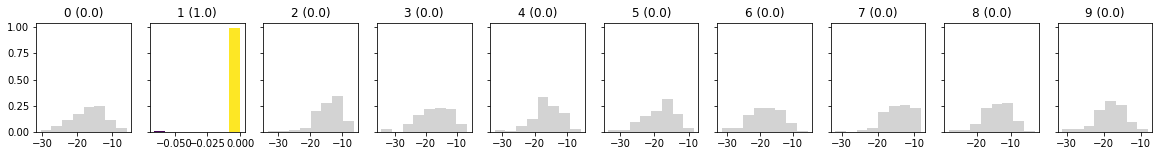

Correct
-------------------------
Real:  7


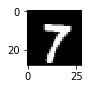

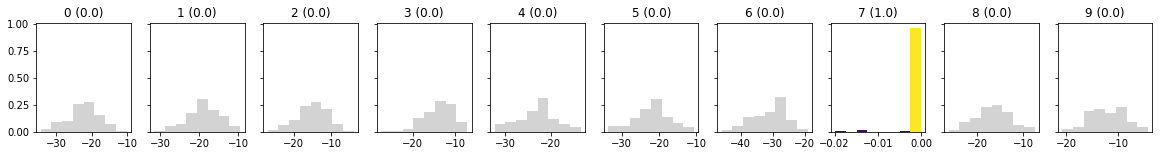

Correct
-------------------------
Real:  4


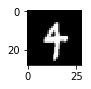

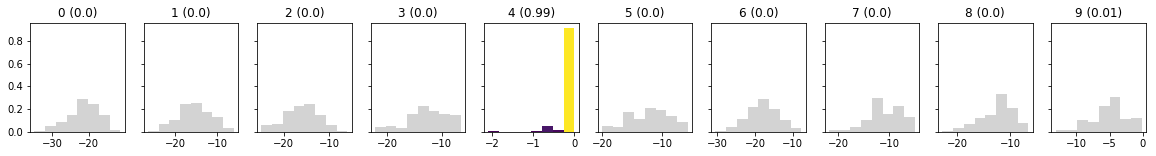

Correct
-------------------------
Real:  9


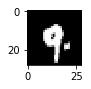

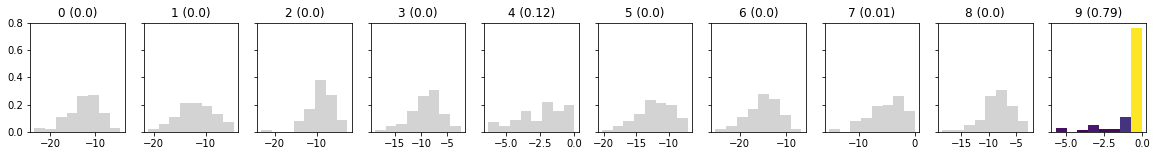

Correct
-------------------------
Real:  8


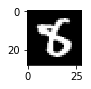

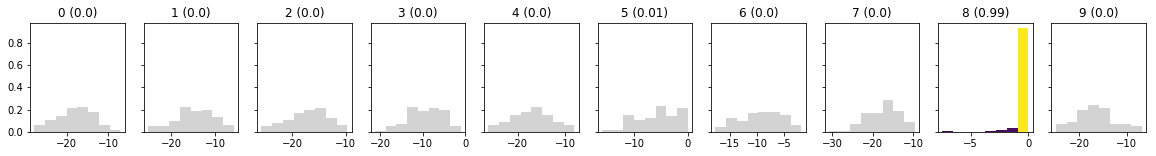

Correct
-------------------------
Real:  9


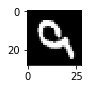

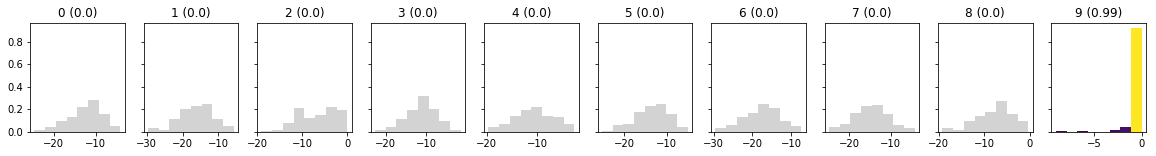

Correct
-------------------------
Real:  8


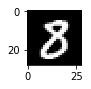

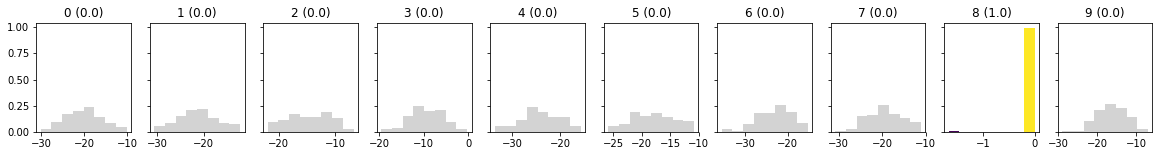

Correct
-------------------------
Real:  6


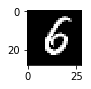

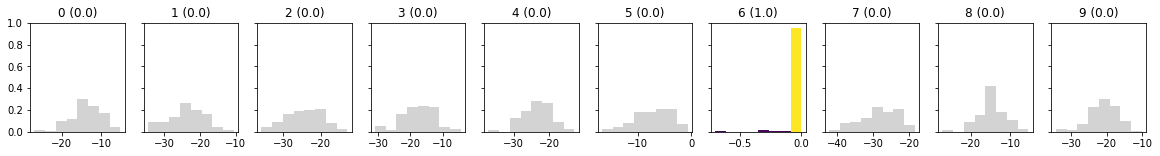

Correct
-------------------------
Real:  0


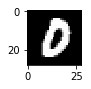

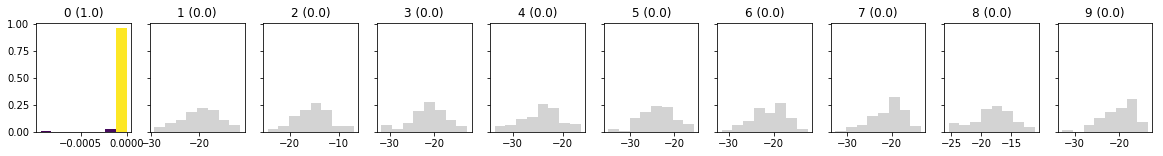

Correct
-------------------------
Real:  0


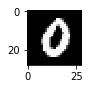

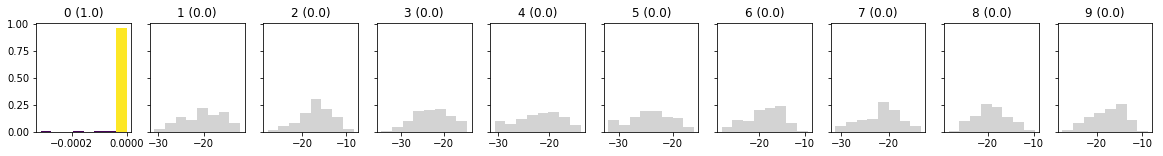

Correct
-------------------------
Real:  2


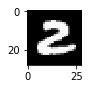

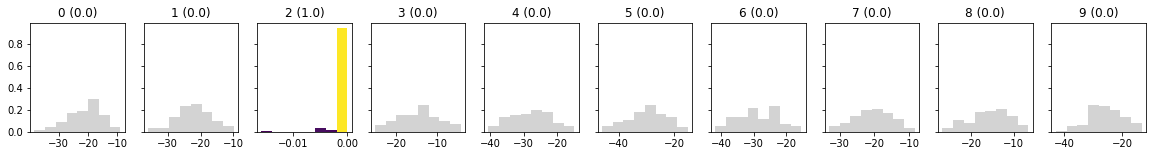

Correct
-------------------------
Real:  7


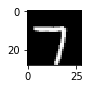

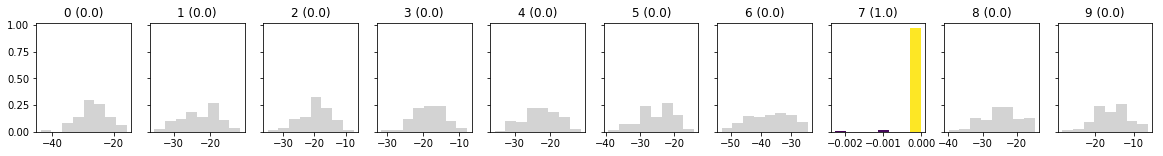

Correct
-------------------------
Real:  5


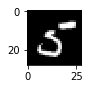

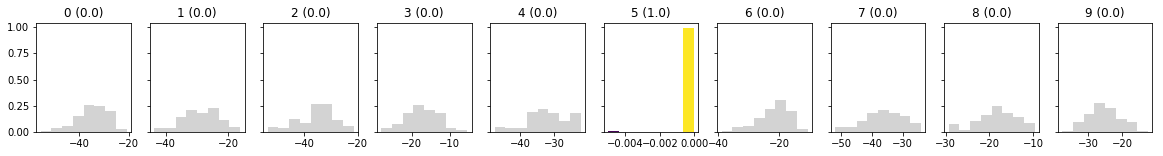

Correct
-------------------------
Real:  8


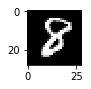

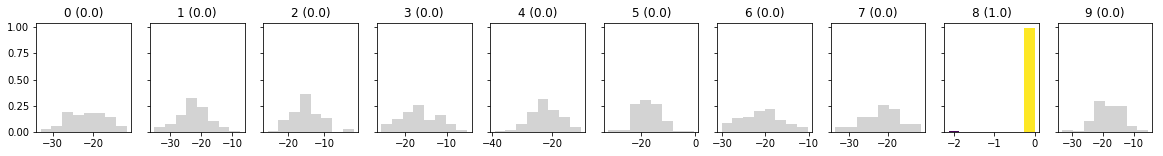

Correct
-------------------------
Real:  8


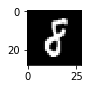

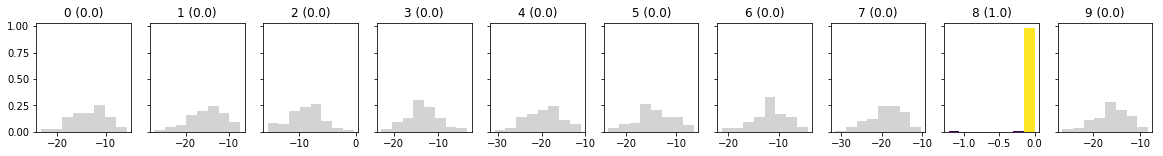

Correct
-------------------------
Real:  9


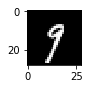

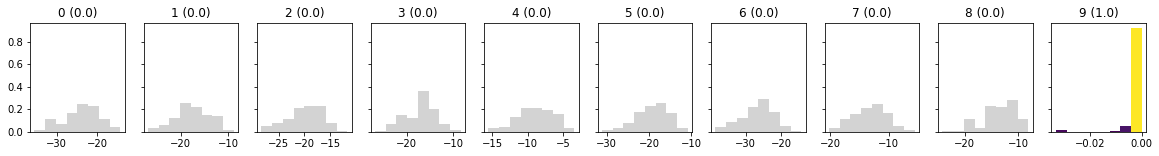

Correct
-------------------------
Real:  0


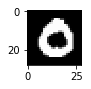

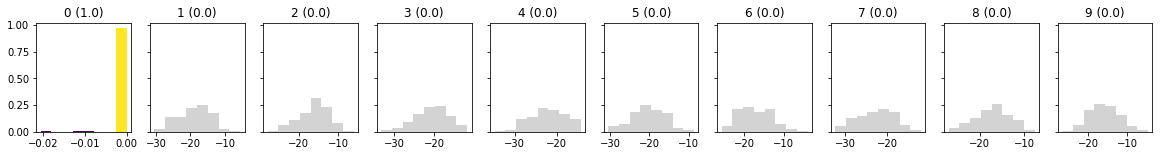

Correct
-------------------------
Real:  2


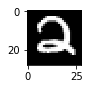

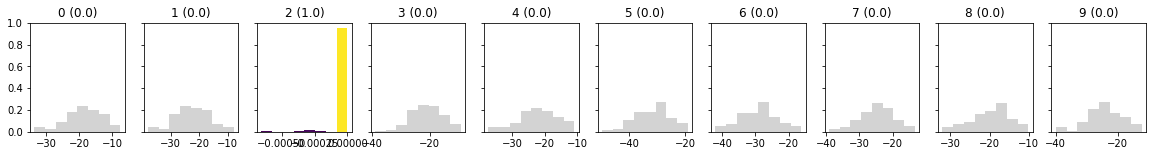

Correct
-------------------------
Real:  0


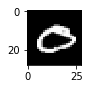

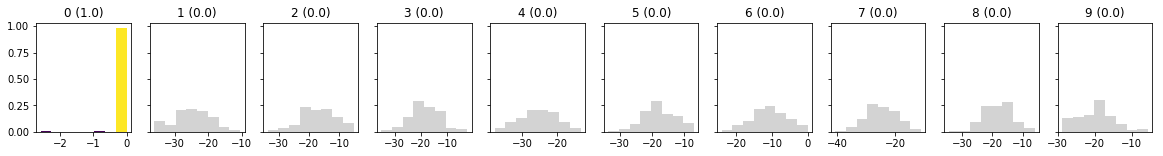

Correct
-------------------------
Real:  1


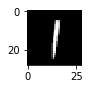

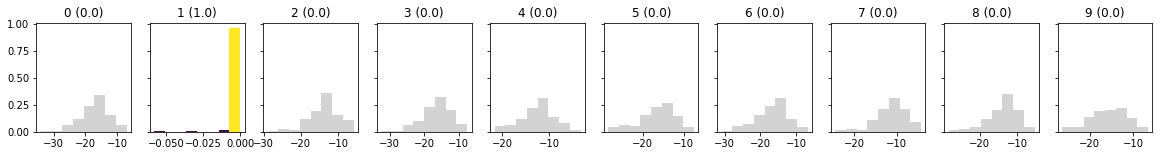

Correct
-------------------------
Real:  7


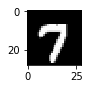

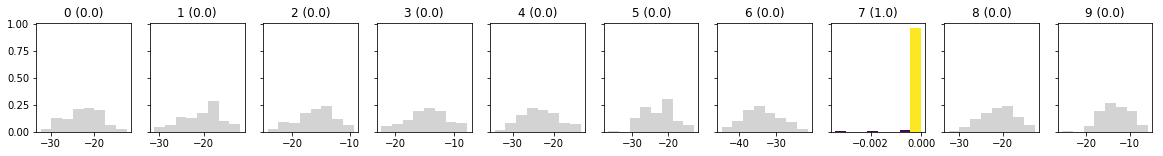

Correct
-------------------------
Real:  9


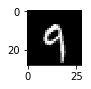

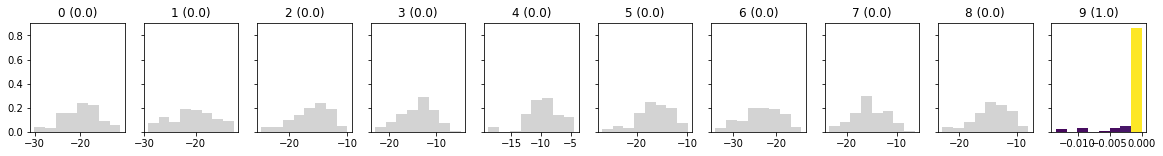

Correct
-------------------------
Real:  5


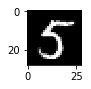

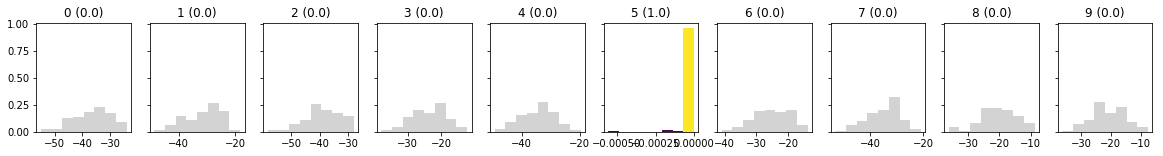

Correct
-------------------------
Real:  7


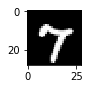

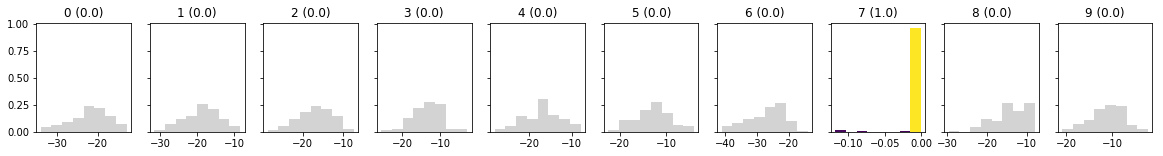

Correct
-------------------------
Real:  2


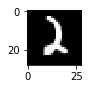

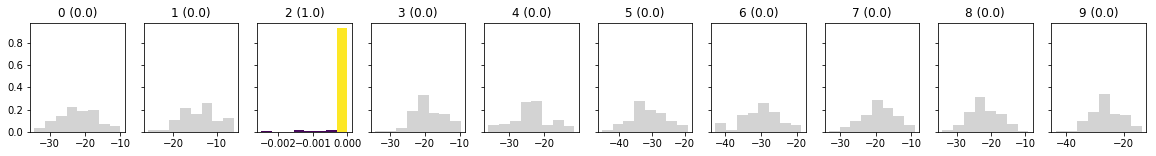

Correct
-------------------------
Real:  8


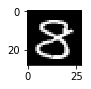

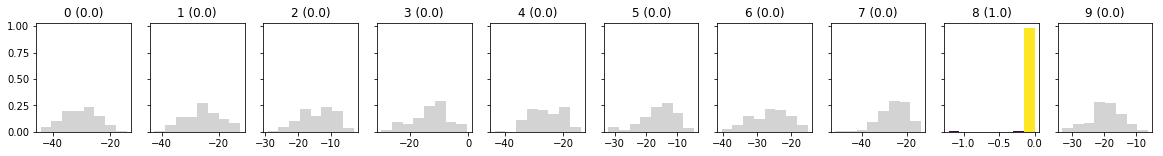

Correct
-------------------------
Real:  3


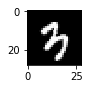

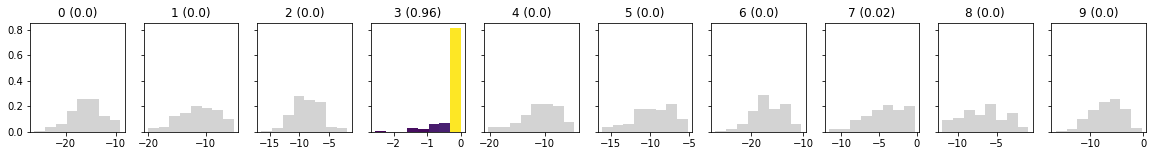

Correct
-------------------------
Real:  6


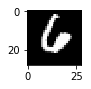

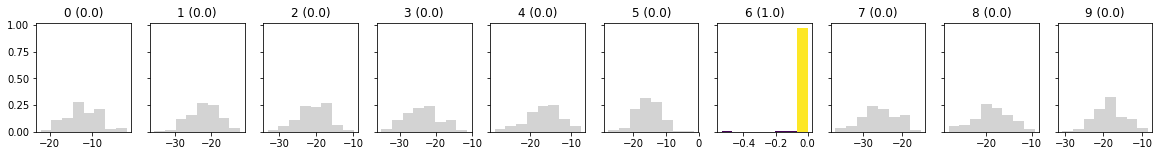

Correct
-------------------------
Real:  6


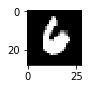

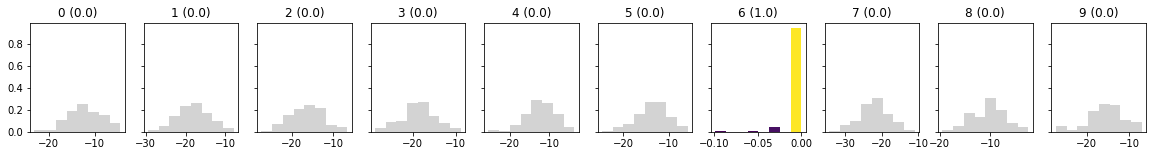

Correct
-------------------------
Real:  5


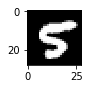

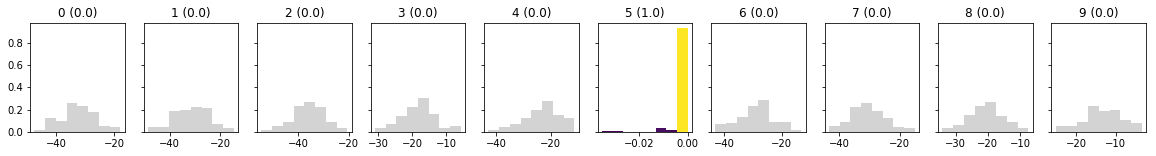

Correct
-------------------------
Real:  7


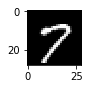

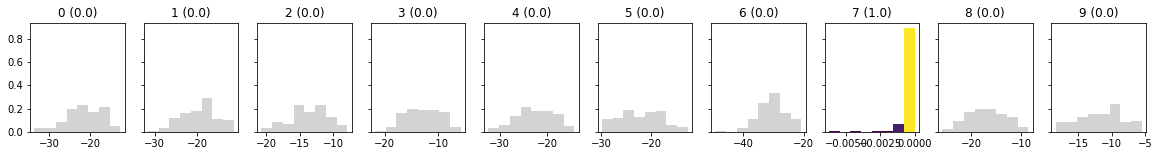

Correct
-------------------------
Real:  2


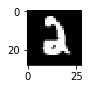

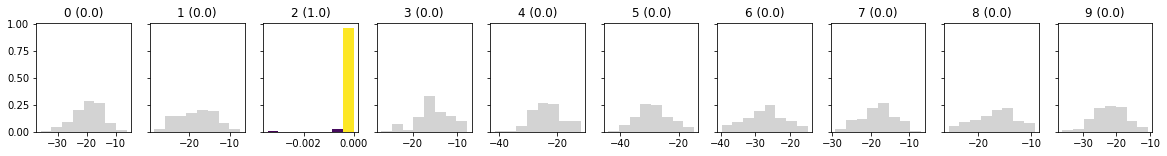

Correct
-------------------------
Real:  5


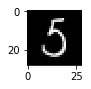

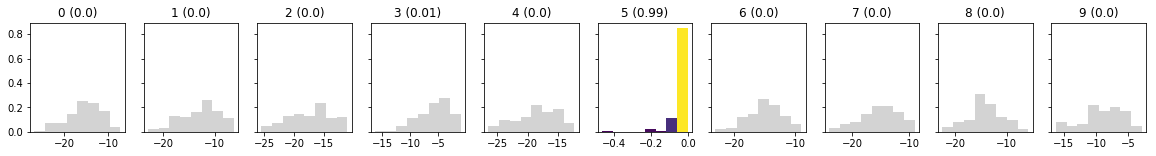

Correct
-------------------------
Real:  6


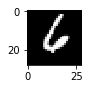

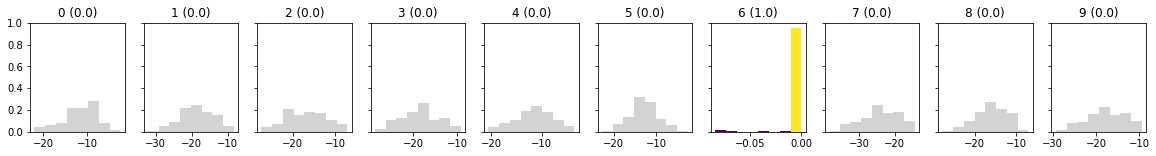

Correct
-------------------------
Real:  0


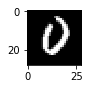

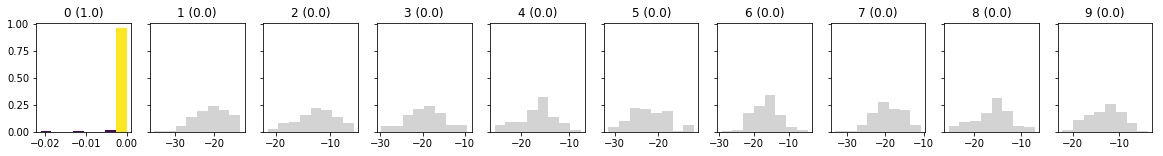

Correct
-------------------------
Real:  3


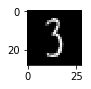

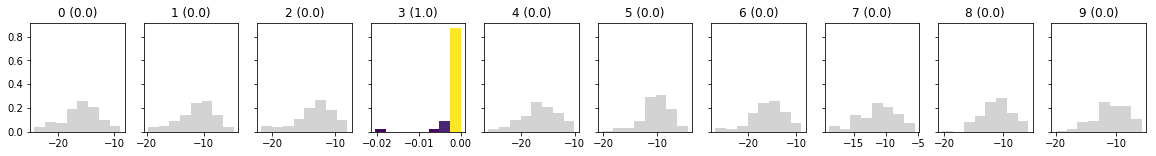

Correct
-------------------------
Real:  2


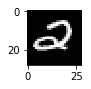

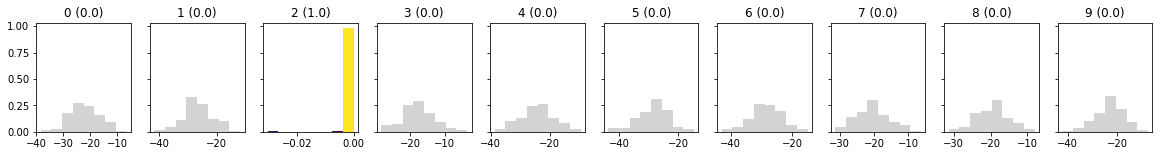

Correct
-------------------------
Real:  8


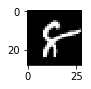

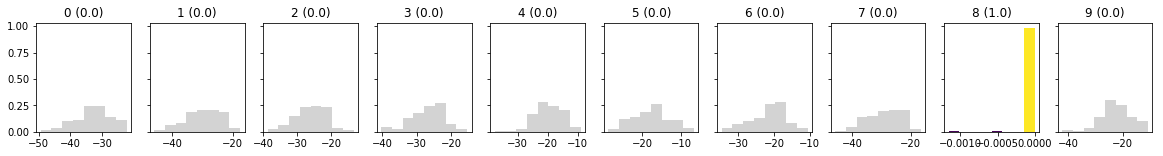

Correct
-------------------------
Real:  0


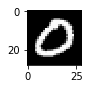

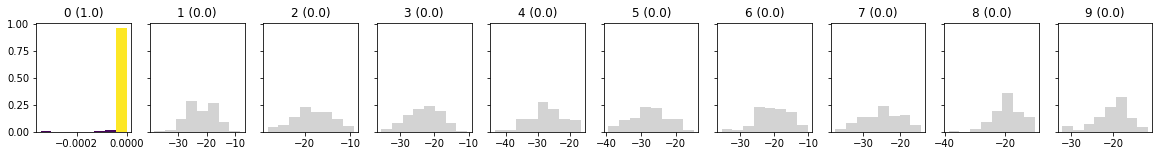

Correct
-------------------------
Real:  2


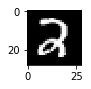

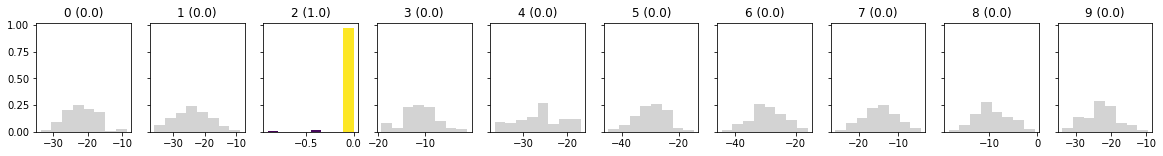

Correct
-------------------------
Real:  1


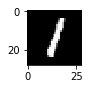

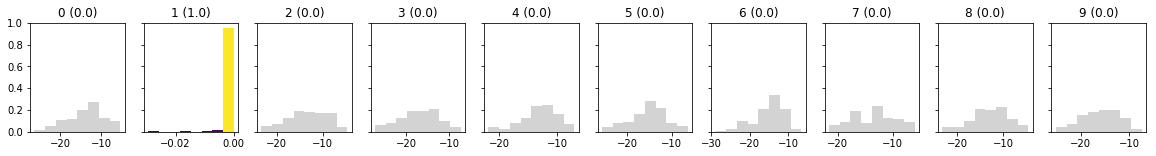

Correct
-------------------------
Real:  6


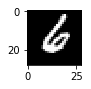

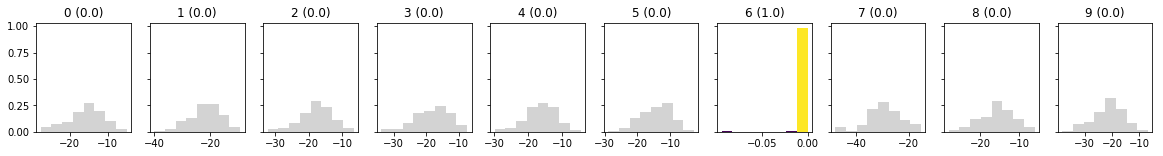

Correct
-------------------------
Real:  9


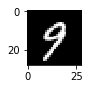

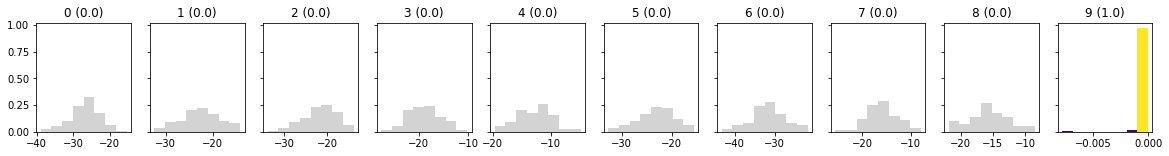

Correct
-------------------------
Real:  5


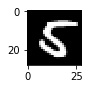

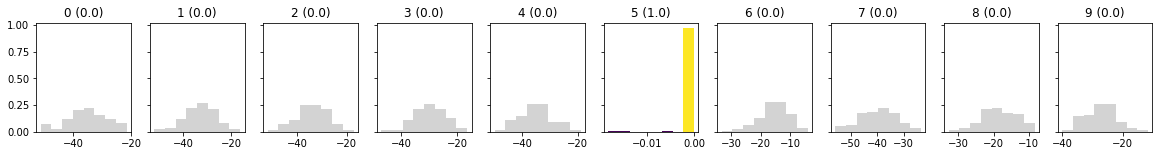

Correct
-------------------------
Real:  1


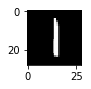

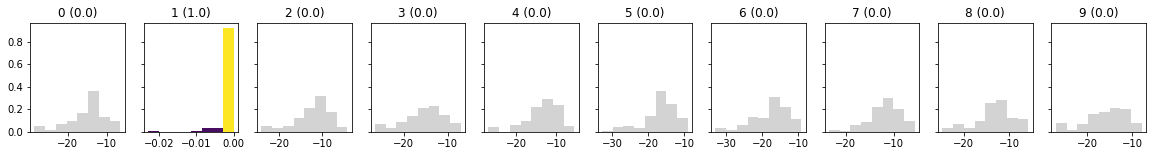

Correct
-------------------------
Real:  7


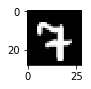

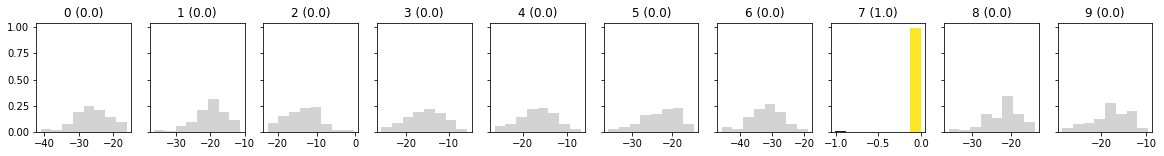

Correct
-------------------------
Real:  7


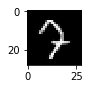

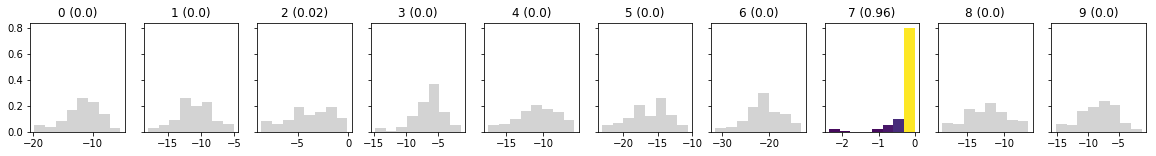

Correct
-------------------------
Real:  5


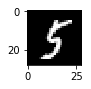

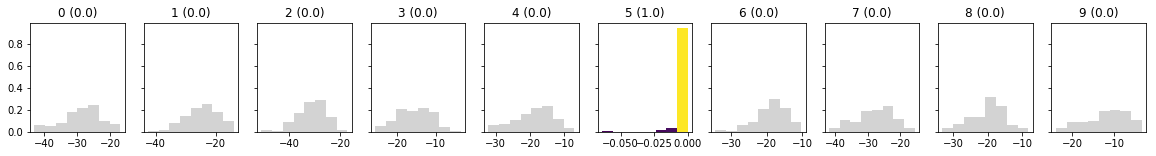

Correct
-------------------------
Real:  5


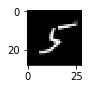

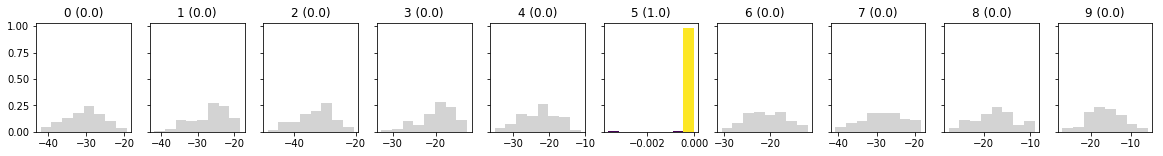

Correct
-------------------------
Real:  5


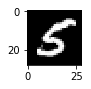

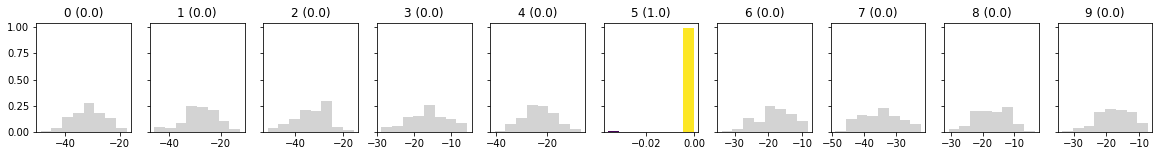

Correct
-------------------------
Real:  9


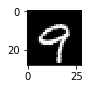

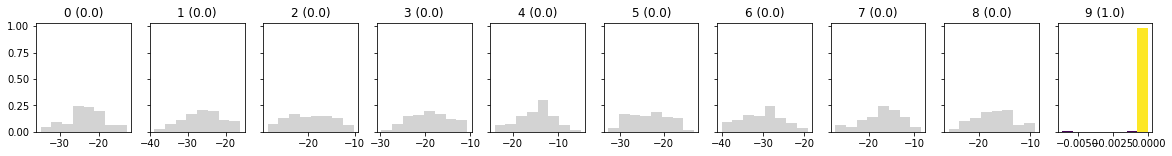

Correct
-------------------------
Real:  8


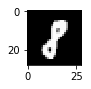

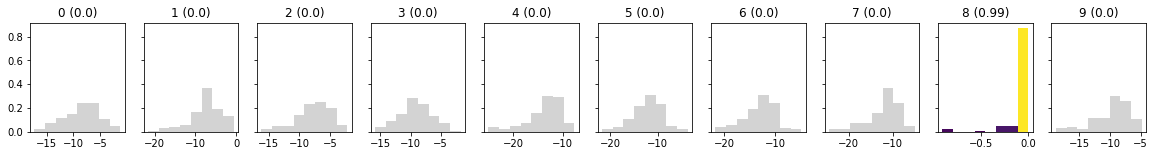

Correct
-------------------------
Real:  7


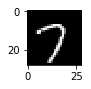

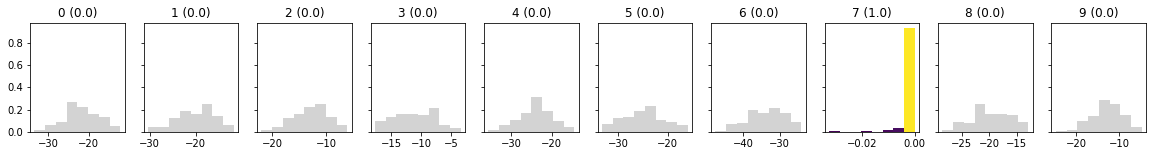

Correct
-------------------------
Real:  7


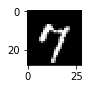

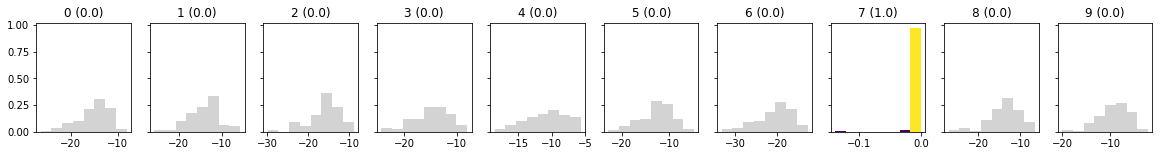

Correct
-------------------------
Real:  0


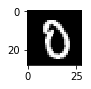

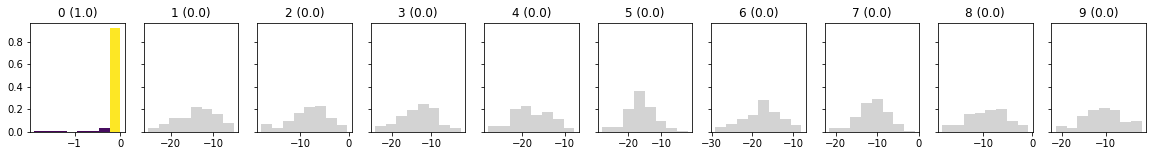

Correct
-------------------------
Real:  8


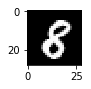

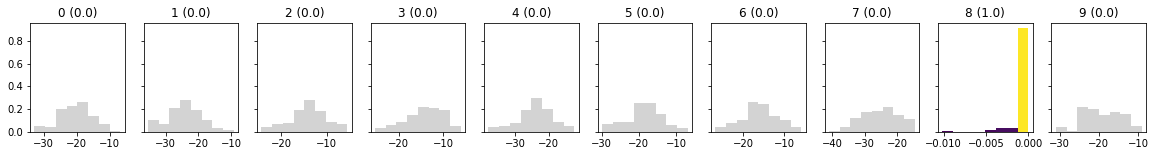

Correct
-------------------------
Real:  3


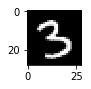

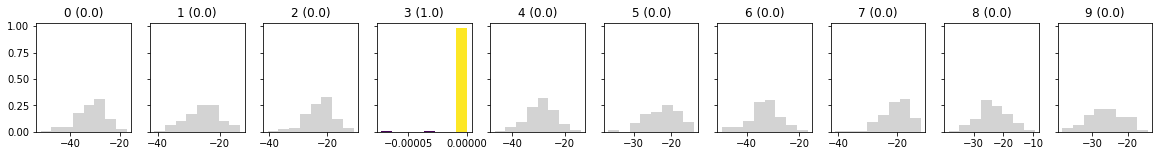

Correct
-------------------------
Real:  2


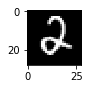

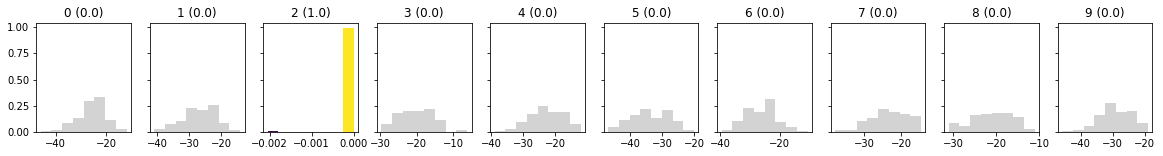

Correct
-------------------------
Real:  9


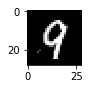

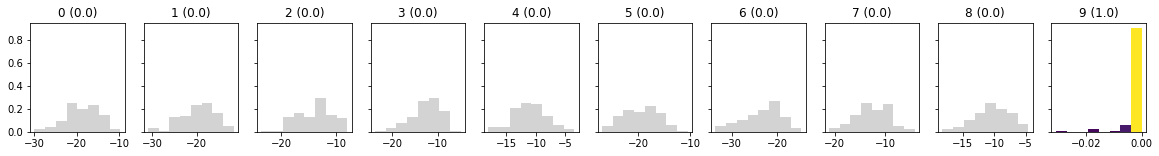

Correct
-------------------------
Real:  6


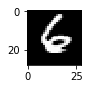

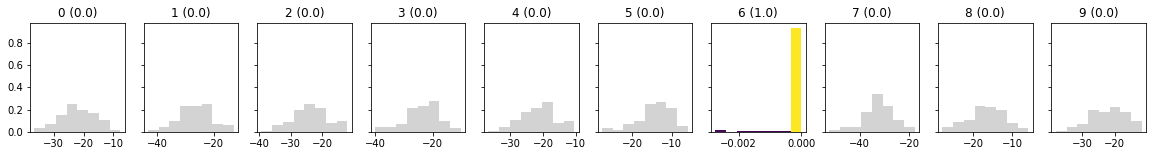

Correct
-------------------------
Real:  3


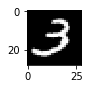

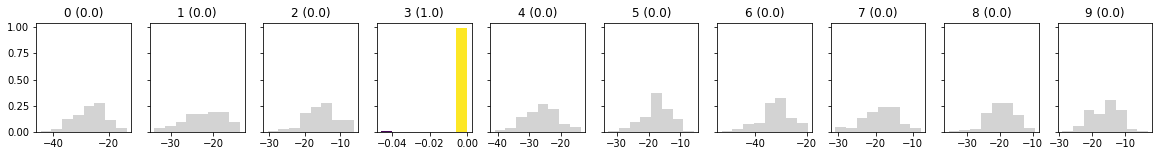

Correct
-------------------------
Real:  7


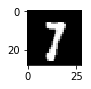

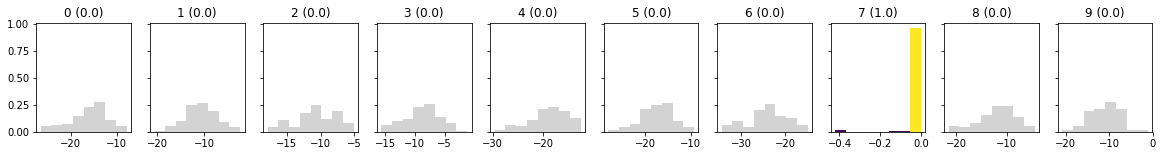

Correct
-------------------------
Real:  2


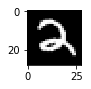

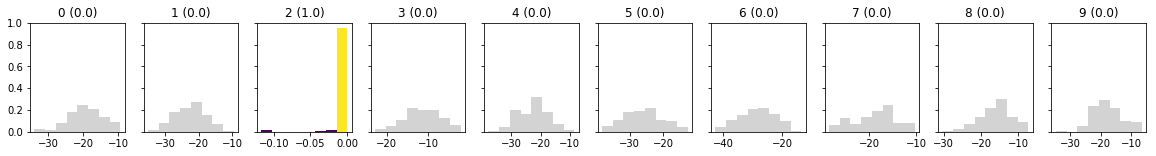

Correct
-------------------------
Real:  0


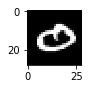

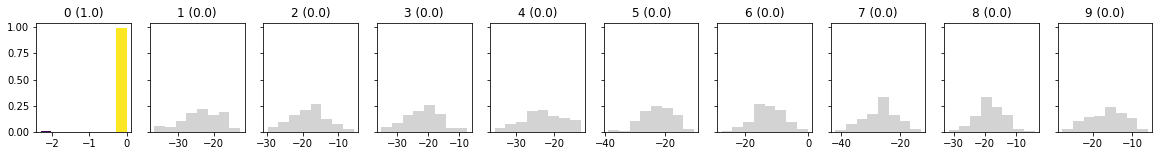

Correct
-------------------------
Real:  9


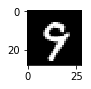

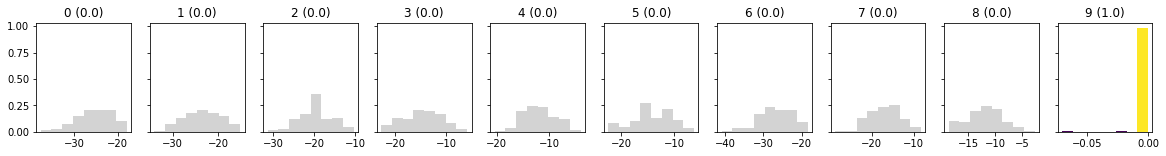

Correct
-------------------------
Real:  2


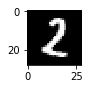

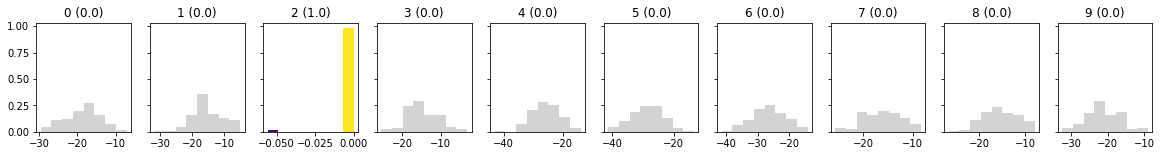

Correct
-------------------------
Real:  3


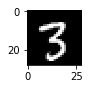

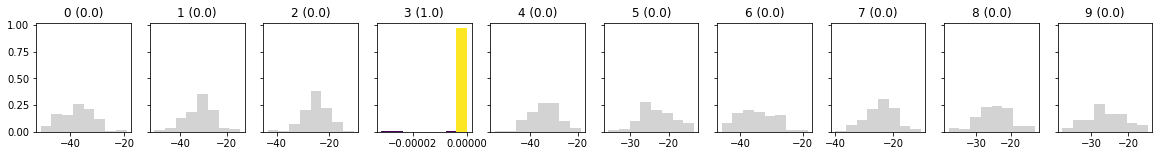

Correct
-------------------------
Real:  4


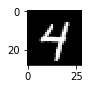

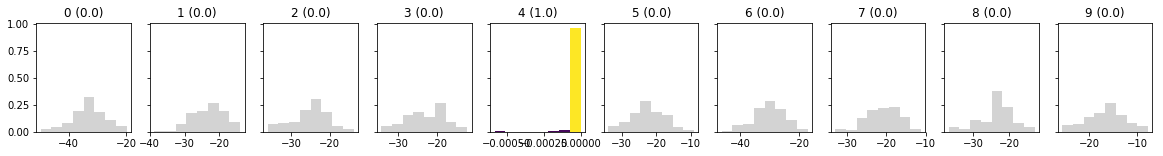

Correct
-------------------------
Real:  7


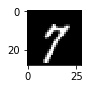

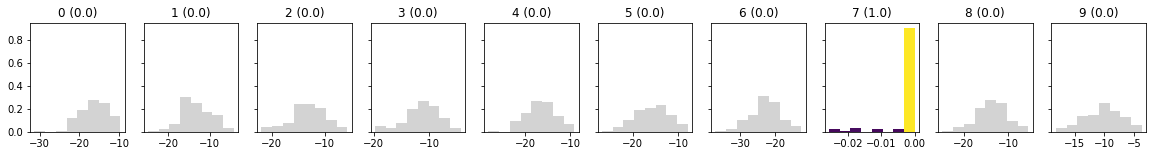

Correct
-------------------------
Real:  8


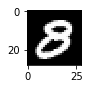

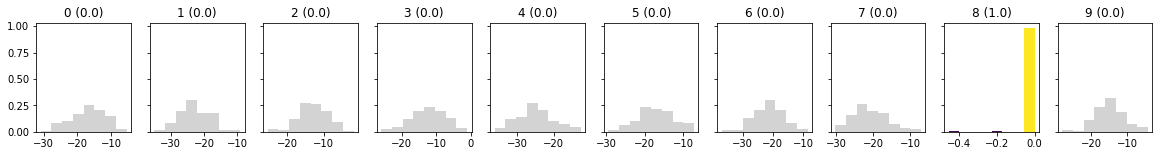

Correct
-------------------------
Real:  4


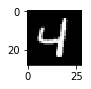

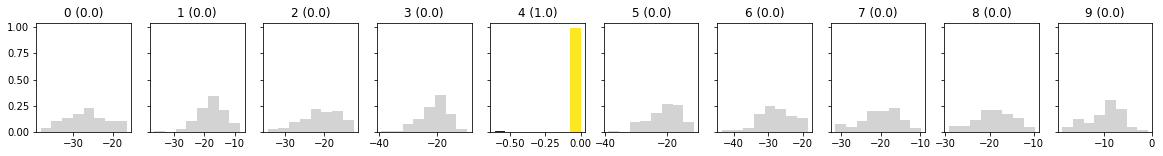

Correct
-------------------------
Real:  8


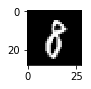

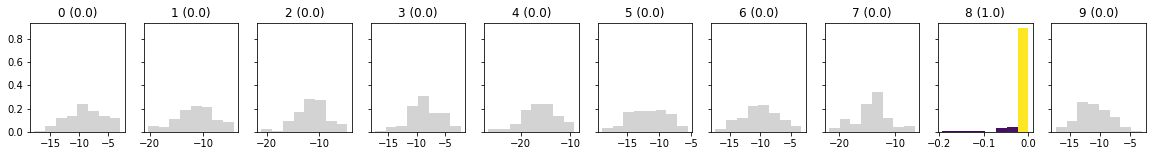

Correct
-------------------------
Real:  6


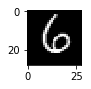

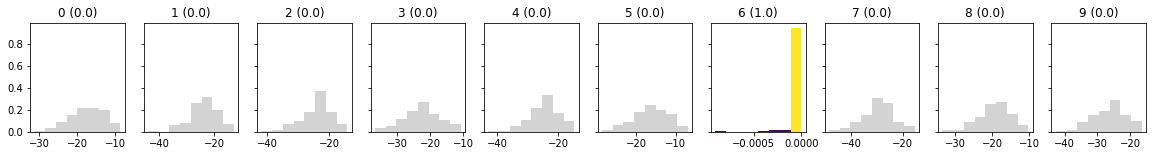

Correct
-------------------------
Real:  2


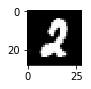

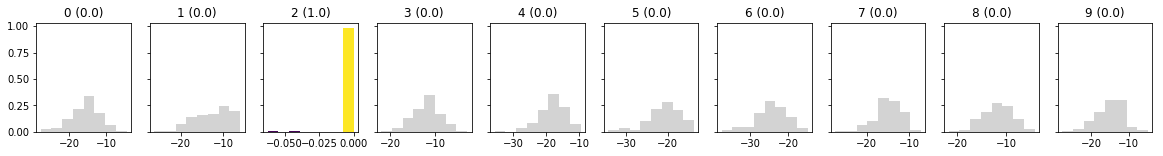

Correct
-------------------------
Real:  8


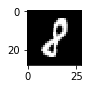

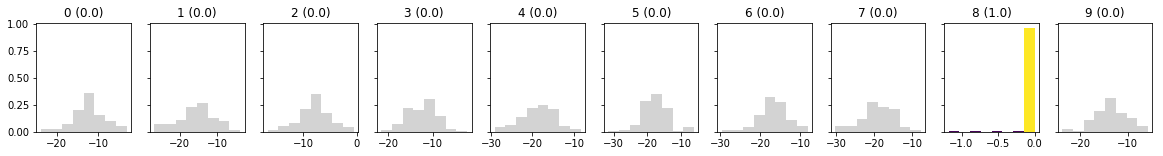

Correct
-------------------------
Real:  6


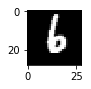

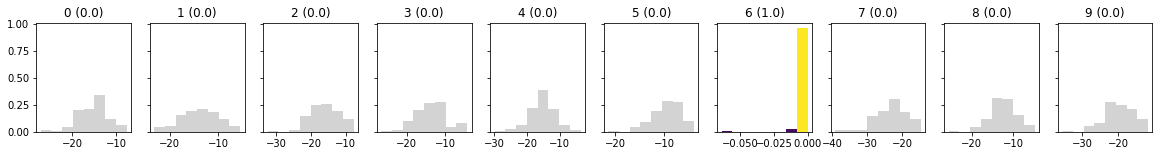

Correct
-------------------------
Real:  6


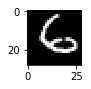

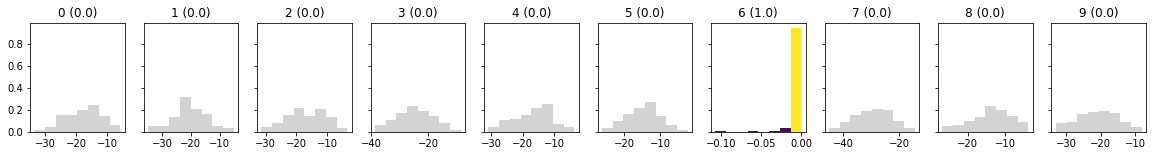

Correct
-------------------------
Real:  3


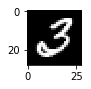

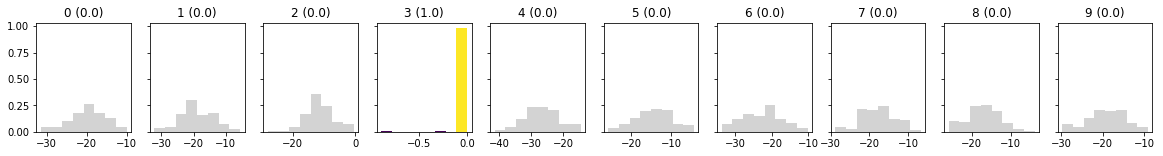

Correct
-------------------------
Real:  2


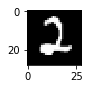

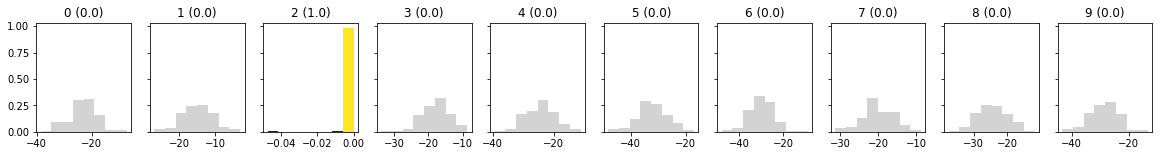

Correct
-------------------------
Real:  5


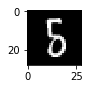

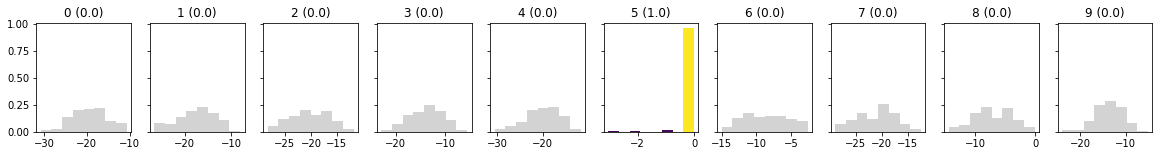

Correct
-------------------------
Real:  5


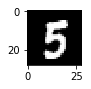

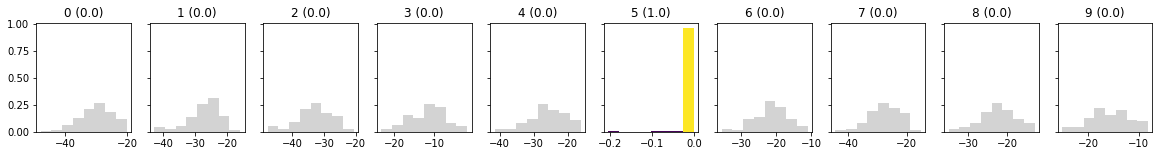

Correct
-------------------------
Real:  2


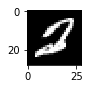

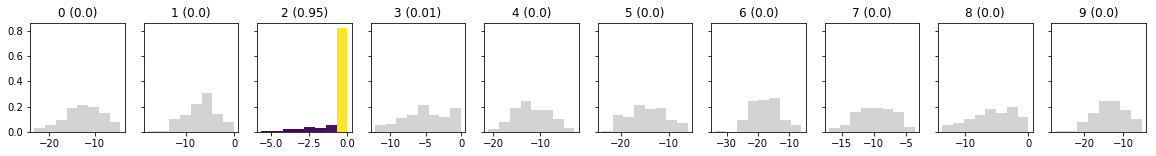

Correct
-------------------------
Real:  7


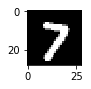

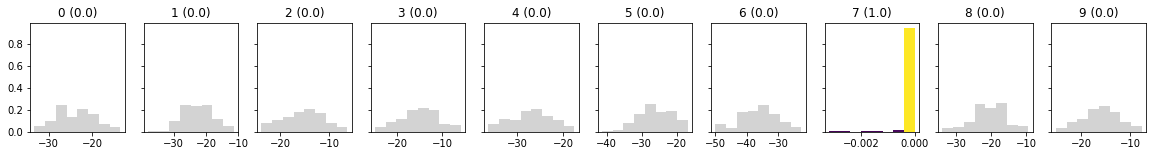

Correct
-------------------------
Real:  1


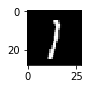

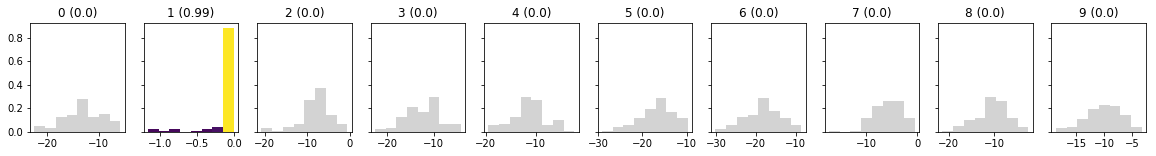

Correct
-------------------------
Real:  8


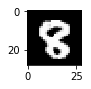

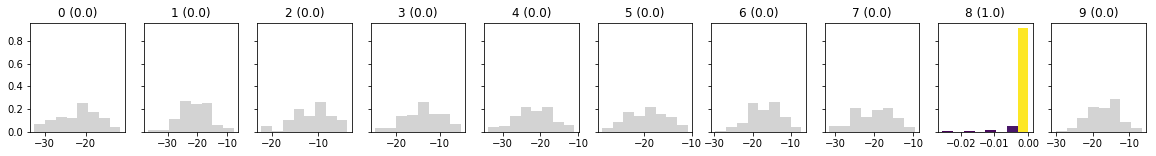

Correct
-------------------------
Real:  7


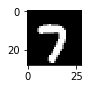

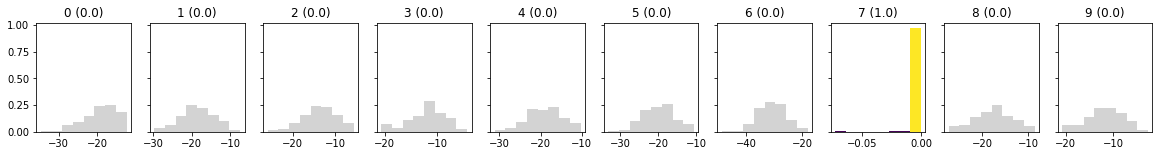

Correct
-------------------------
Real:  1


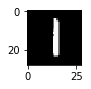

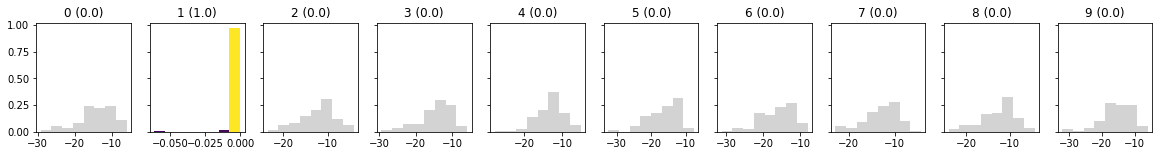

Correct
-------------------------
Summary
Total images:  100
Predicted for:  100
Accuracy when predicted:  1.0


In [0]:
# default probability threshold is 0.2, now using 0.5
total_batch, correct_batch, predictions_batch = test_batch(batch_x, logprobs, batch_y, threshold=0.5, plot=True)

Real:  7


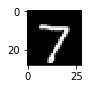

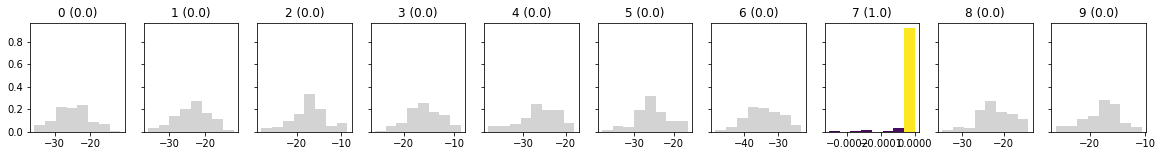

Correct
-------------------------
Real:  2


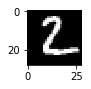

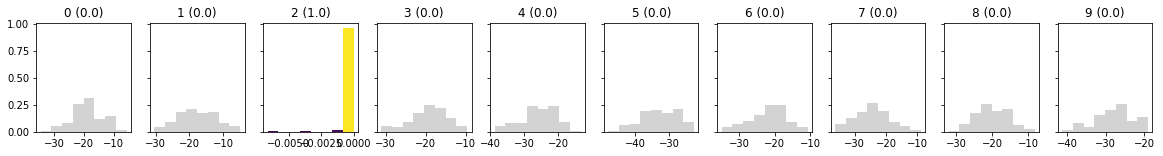

Correct
-------------------------
Real:  1


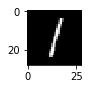

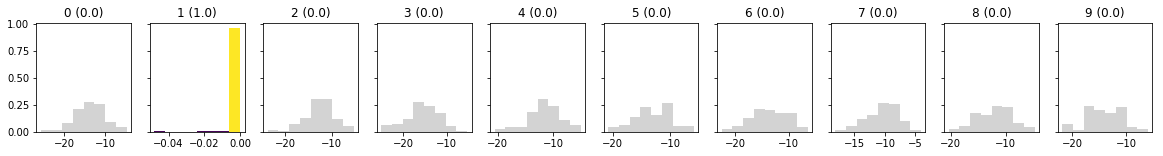

Correct
-------------------------
Real:  0


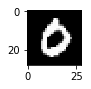

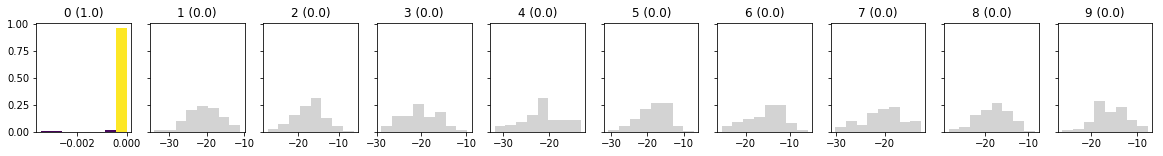

Correct
-------------------------
Real:  4


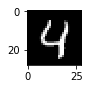

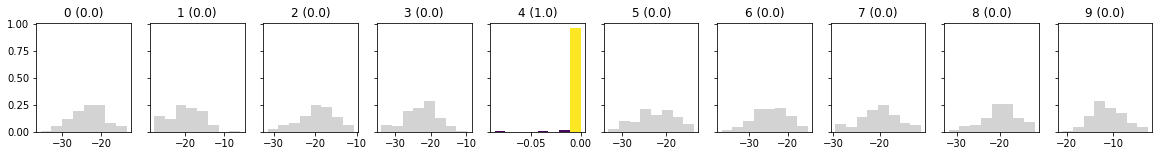

Correct
-------------------------
Real:  1


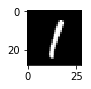

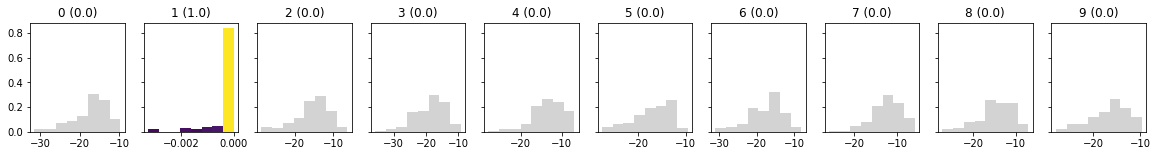

Correct
-------------------------
Real:  4


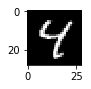

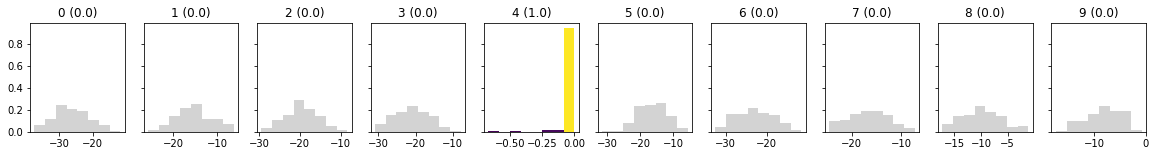

Correct
-------------------------
Real:  9


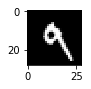

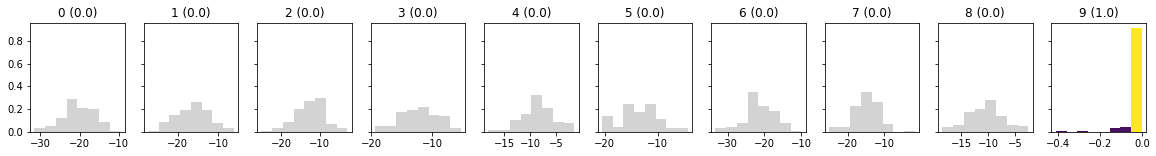

Correct
-------------------------
Real:  5


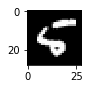

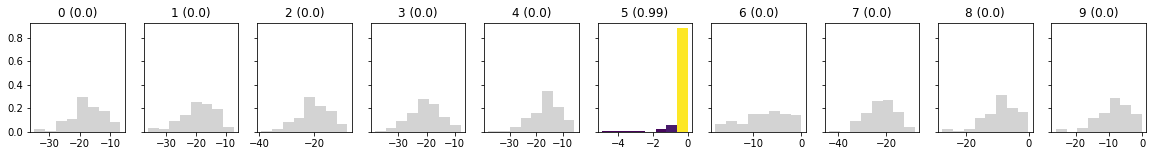

Correct
-------------------------
Real:  9


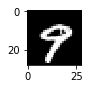

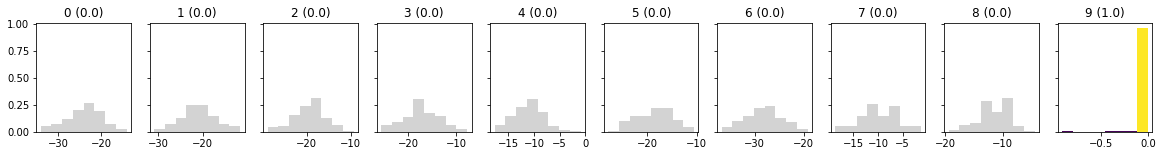

Correct
-------------------------
Real:  0


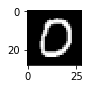

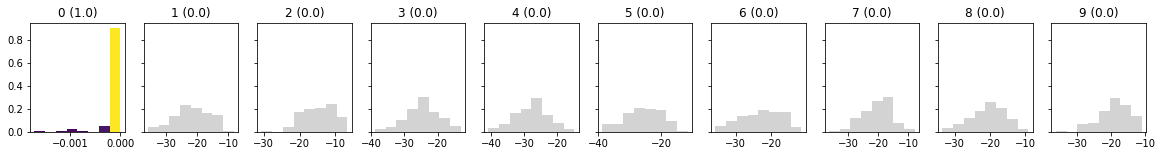

Correct
-------------------------
Real:  6


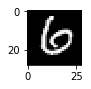

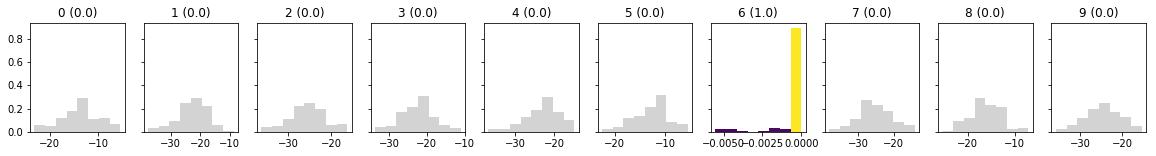

Correct
-------------------------
Real:  9


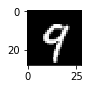

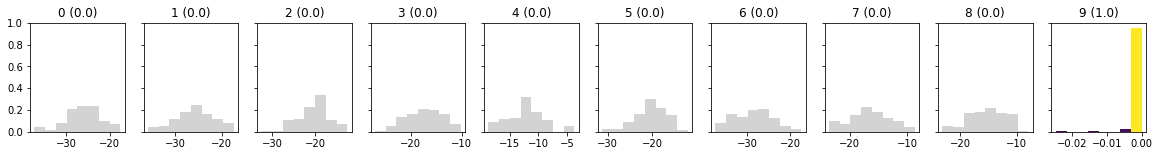

Correct
-------------------------
Real:  0


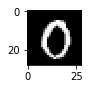

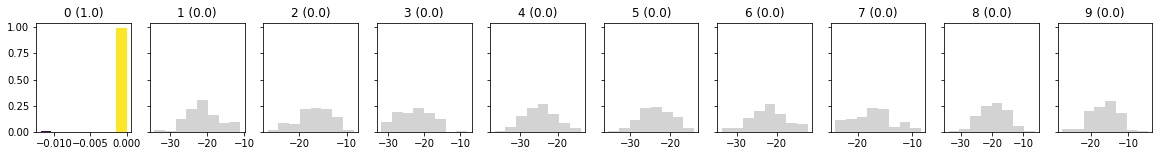

Correct
-------------------------
Real:  1


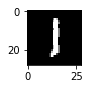

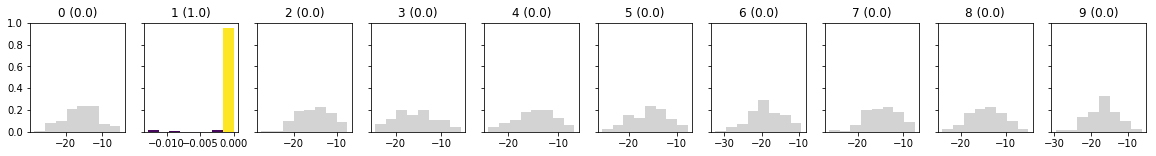

Correct
-------------------------
Real:  5


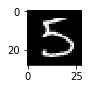

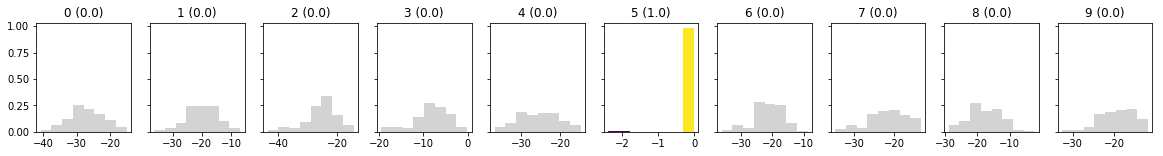

Correct
-------------------------
Real:  9


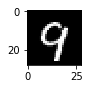

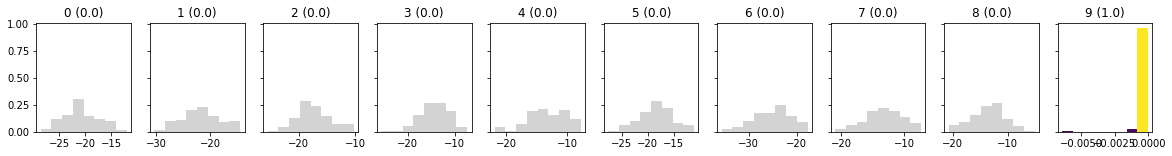

Correct
-------------------------
Real:  7


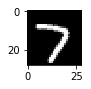

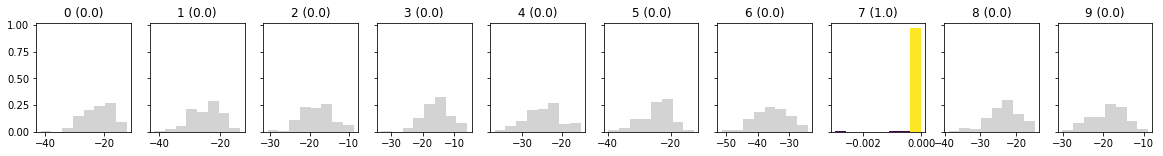

Correct
-------------------------
Real:  3


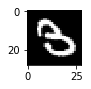

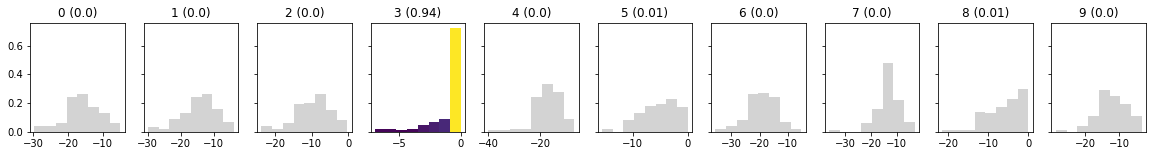

Correct
-------------------------
Real:  4


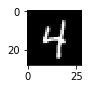

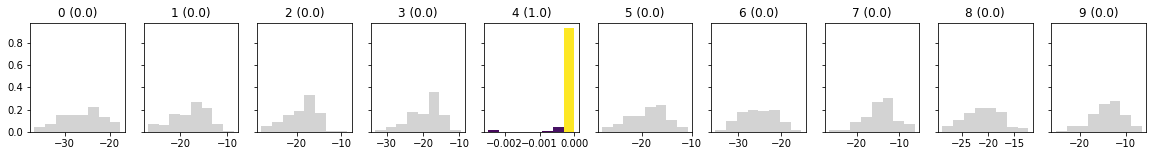

Correct
-------------------------
Real:  9


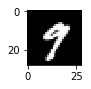

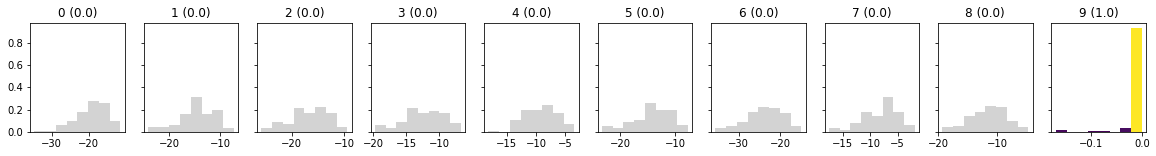

Correct
-------------------------
Real:  6


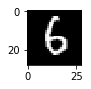

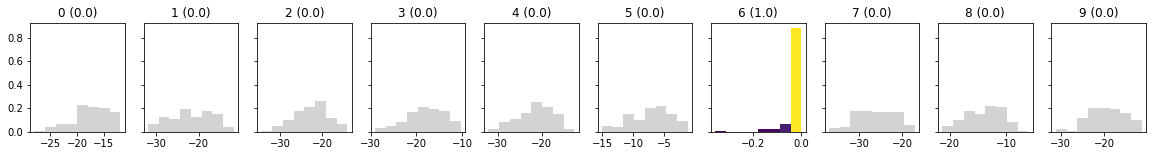

Correct
-------------------------
Real:  6


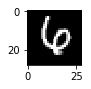

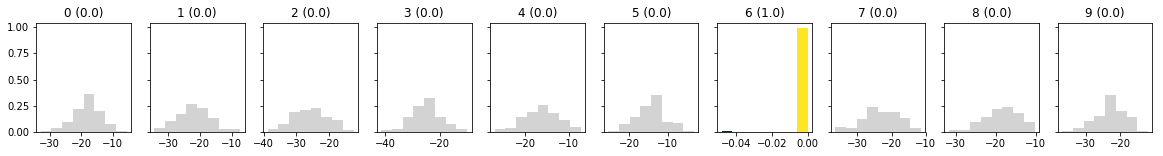

Correct
-------------------------
Real:  5


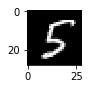

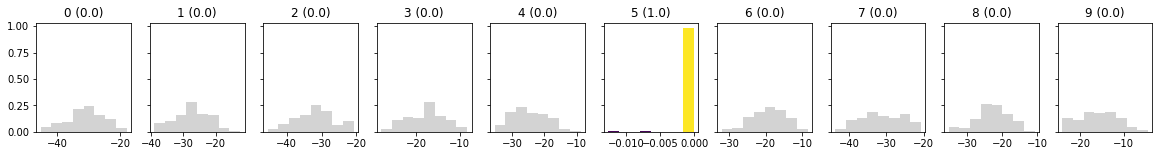

Correct
-------------------------
Real:  4


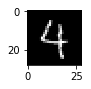

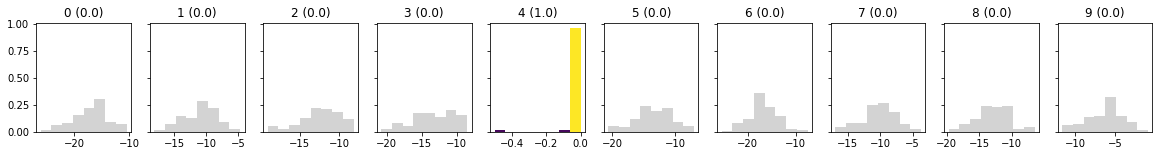

Correct
-------------------------
Real:  0


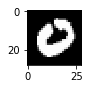

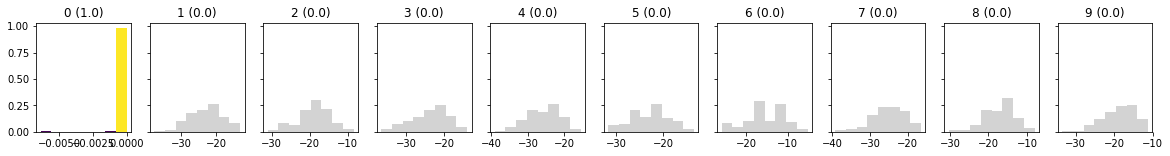

Correct
-------------------------
Real:  7


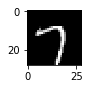

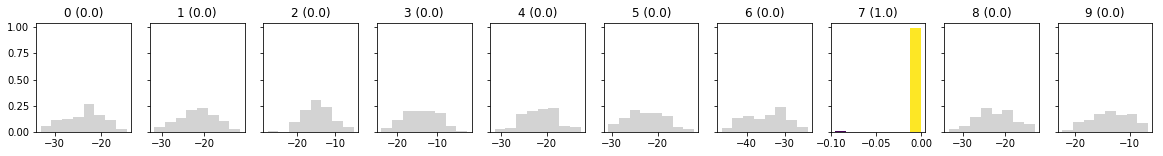

Correct
-------------------------
Real:  4


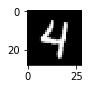

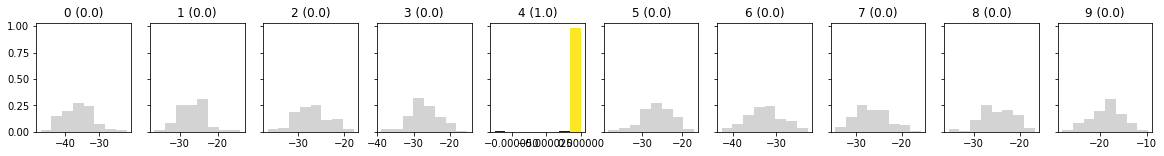

Correct
-------------------------
Real:  0


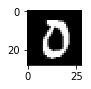

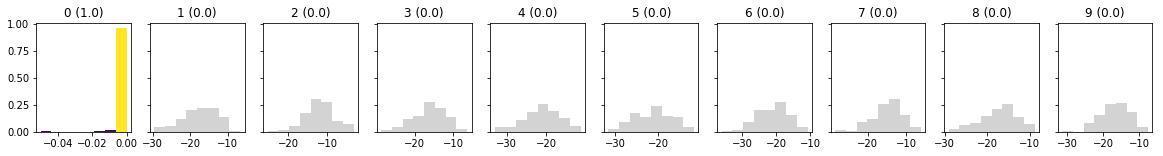

Correct
-------------------------
Real:  1


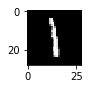

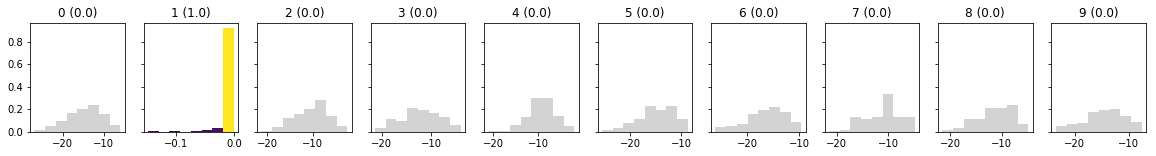

Correct
-------------------------
Real:  3


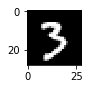

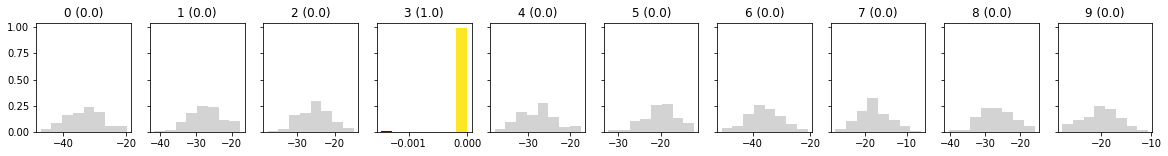

Correct
-------------------------
Real:  1


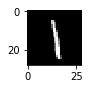

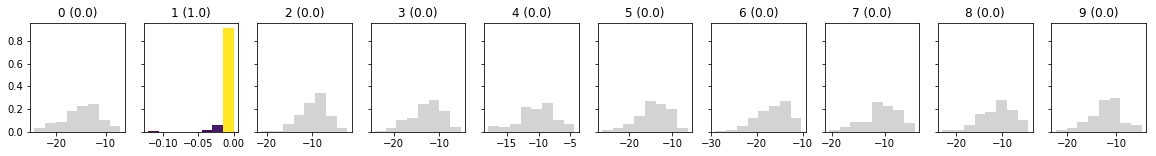

Correct
-------------------------
Real:  3


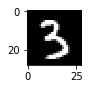

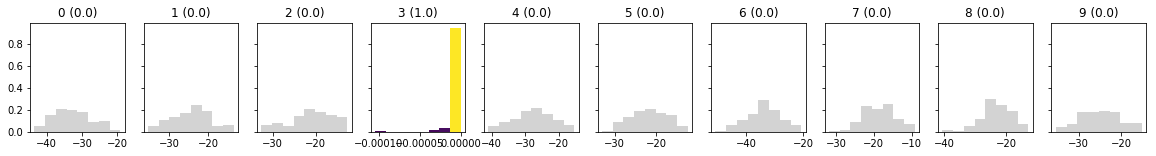

Correct
-------------------------
Real:  4


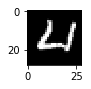

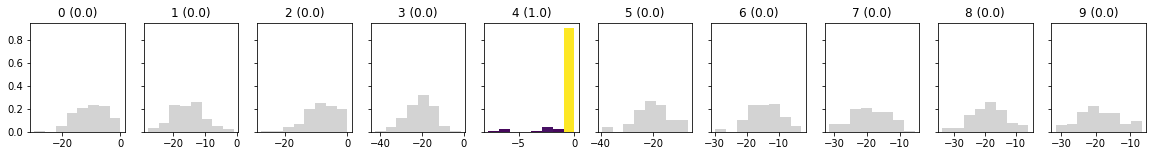

Correct
-------------------------
Real:  7


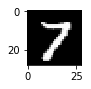

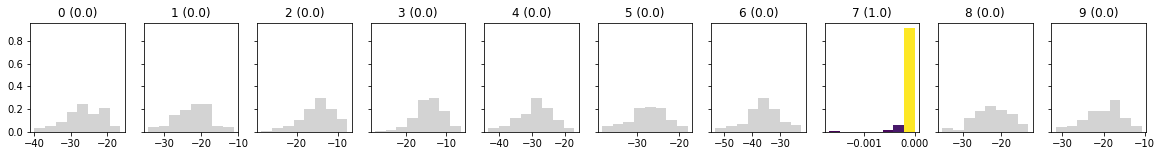

Correct
-------------------------
Real:  2


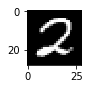

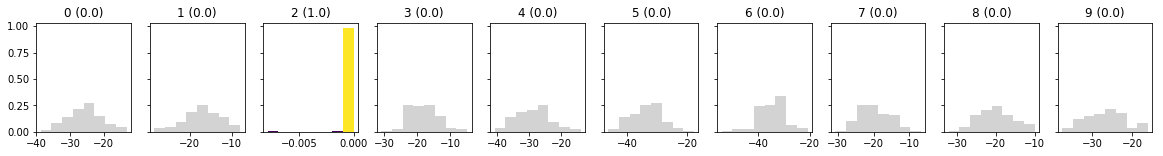

Correct
-------------------------
Real:  7


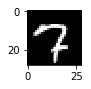

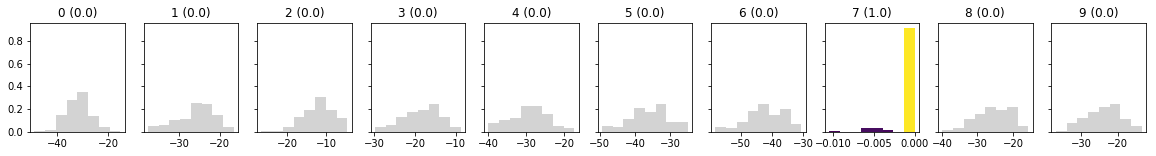

Correct
-------------------------
Real:  1


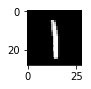

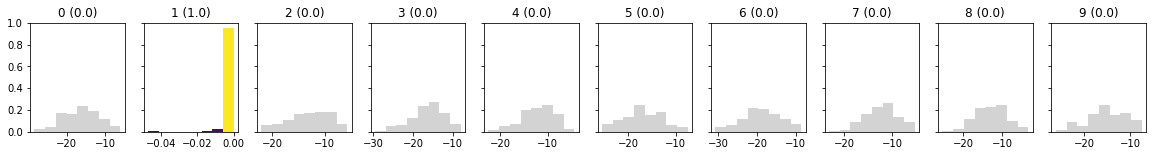

Correct
-------------------------
Real:  2


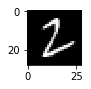

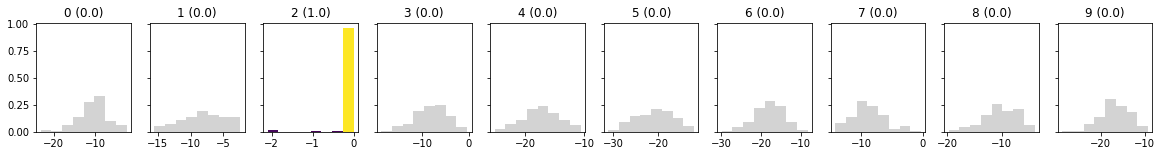

Correct
-------------------------
Real:  1


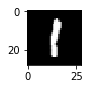

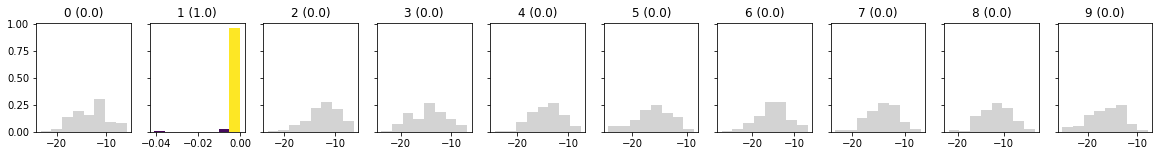

Correct
-------------------------
Real:  1


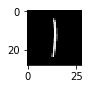

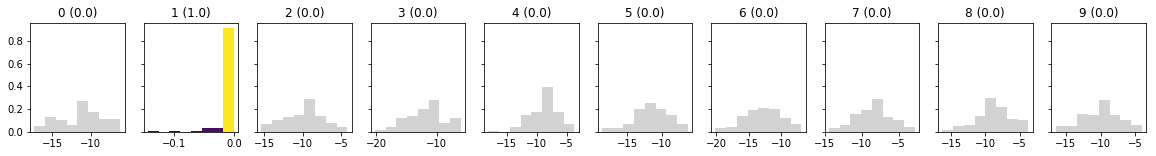

Correct
-------------------------
Real:  7


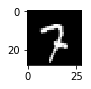

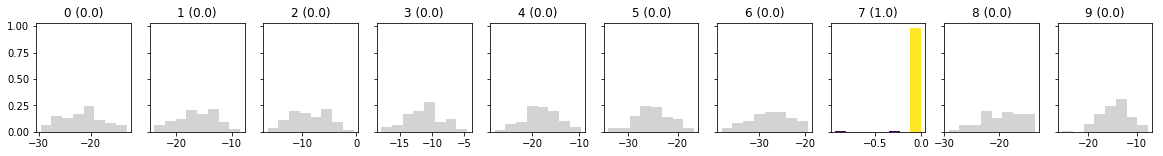

Correct
-------------------------
Real:  4


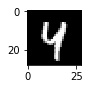

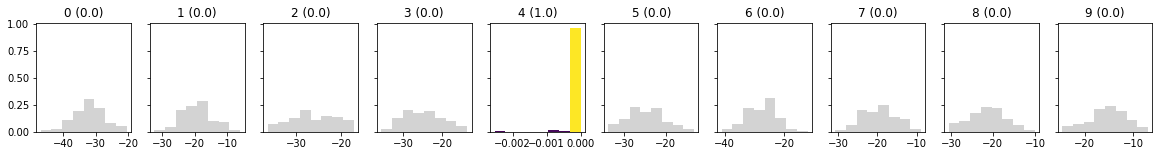

Correct
-------------------------
Real:  2


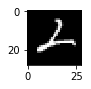

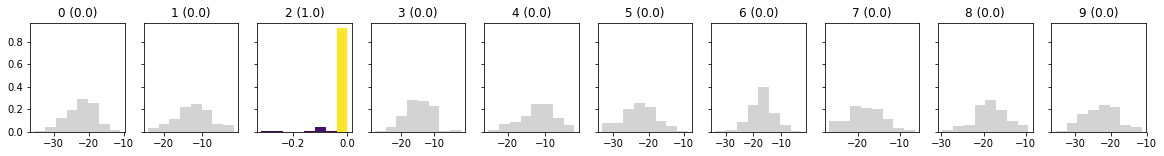

Correct
-------------------------
Real:  3


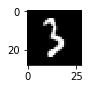

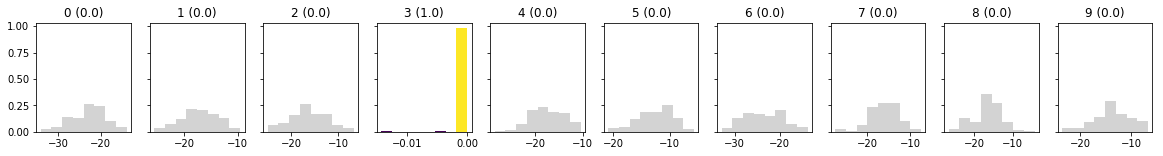

Correct
-------------------------
Real:  5


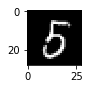

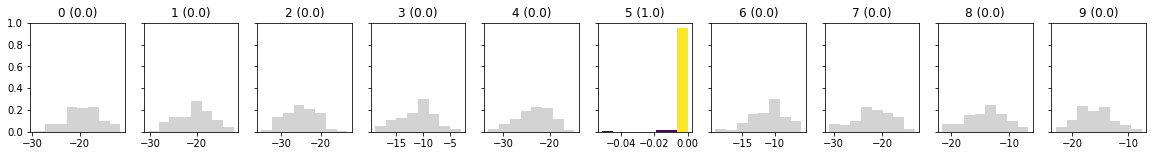

Correct
-------------------------
Real:  1


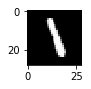

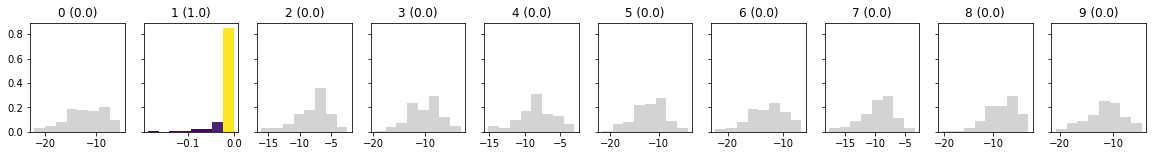

Correct
-------------------------
Real:  2


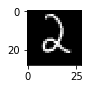

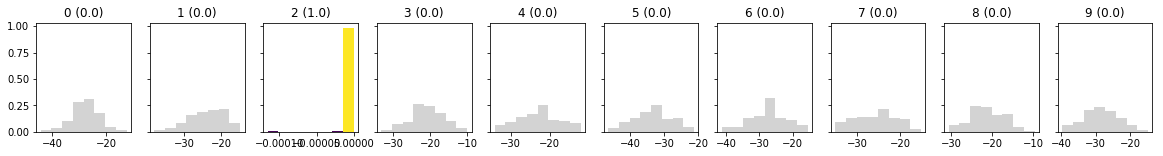

Correct
-------------------------
Real:  4


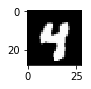

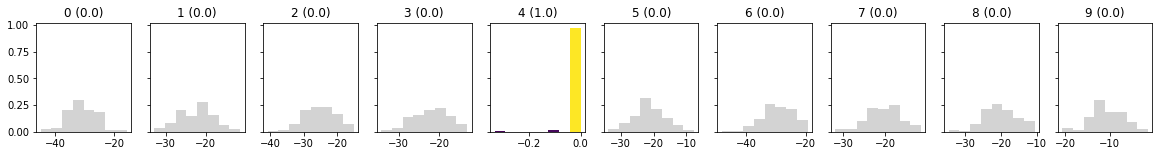

Correct
-------------------------
Real:  4


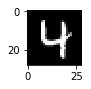

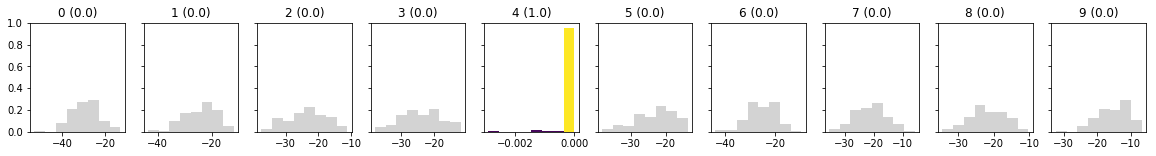

Correct
-------------------------
Real:  6


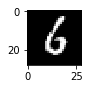

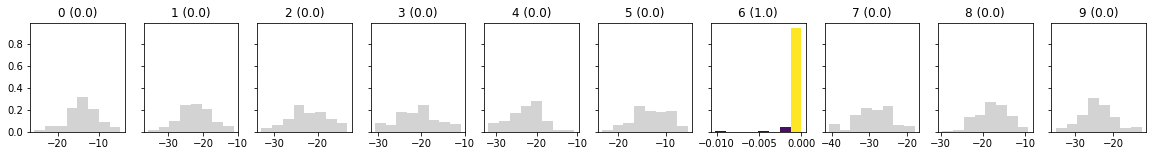

Correct
-------------------------
Real:  3


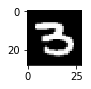

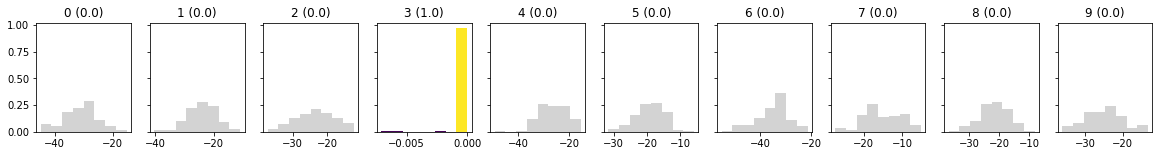

Correct
-------------------------
Real:  5


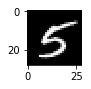

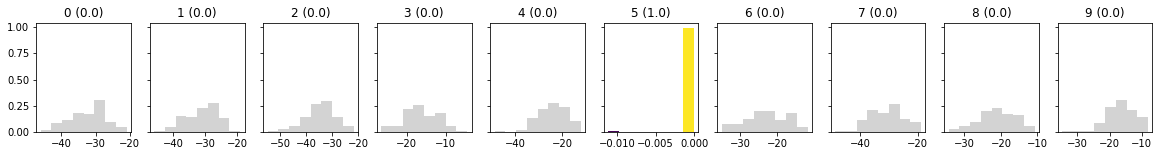

Correct
-------------------------
Real:  5


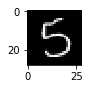

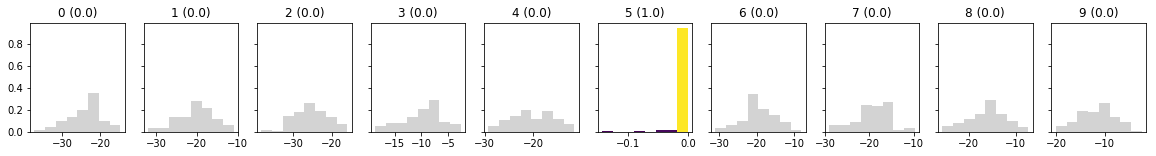

Correct
-------------------------
Real:  6


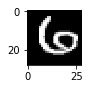

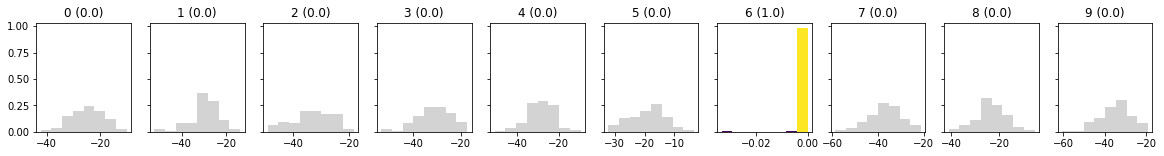

Correct
-------------------------
Real:  0


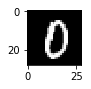

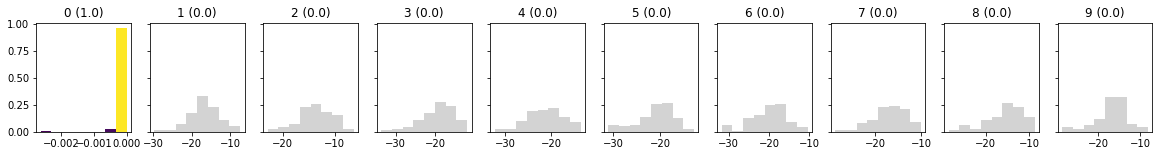

Correct
-------------------------
Real:  4


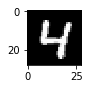

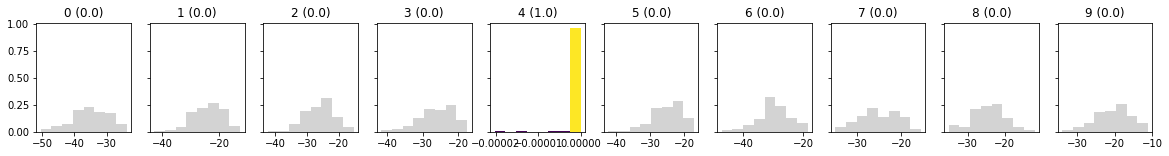

Correct
-------------------------
Real:  1


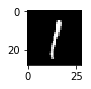

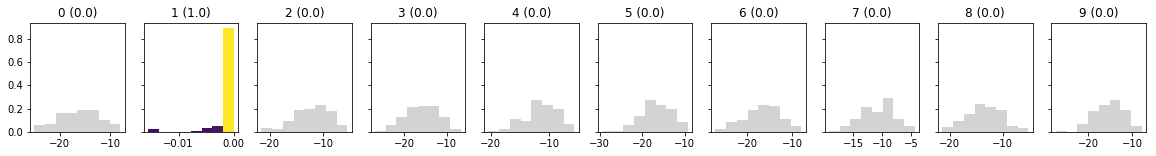

Correct
-------------------------
Real:  9


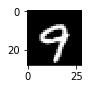

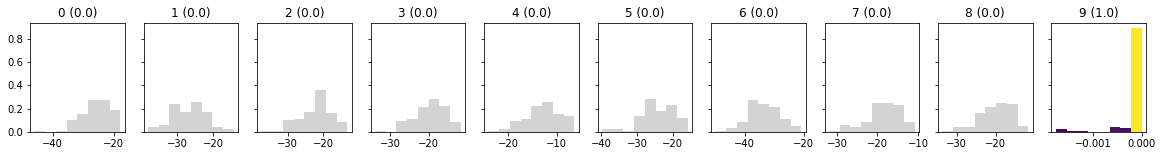

Correct
-------------------------
Real:  5


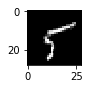

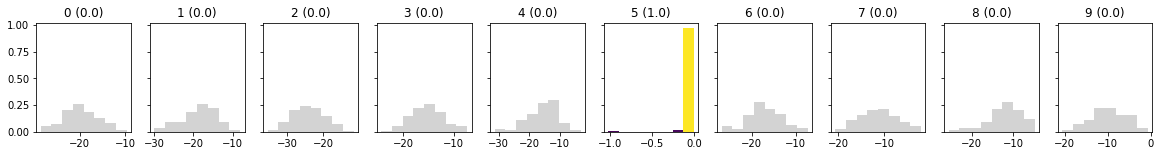

Correct
-------------------------
Real:  7


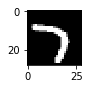

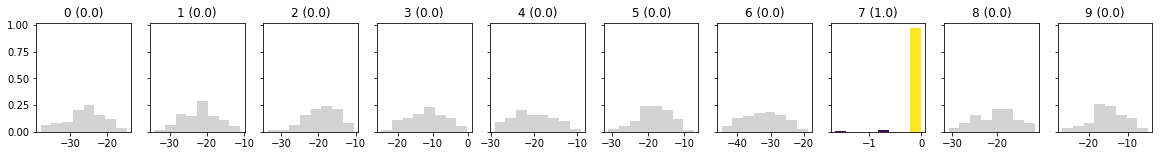

Correct
-------------------------
Real:  8


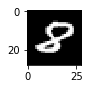

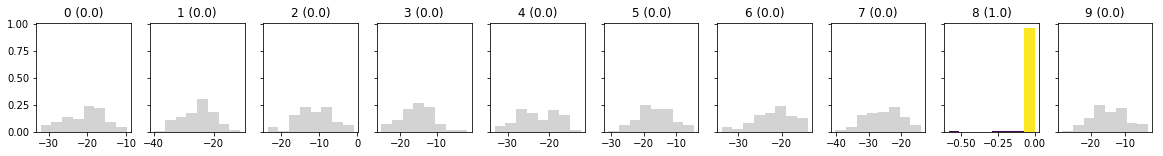

Correct
-------------------------
Real:  9


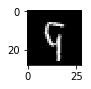

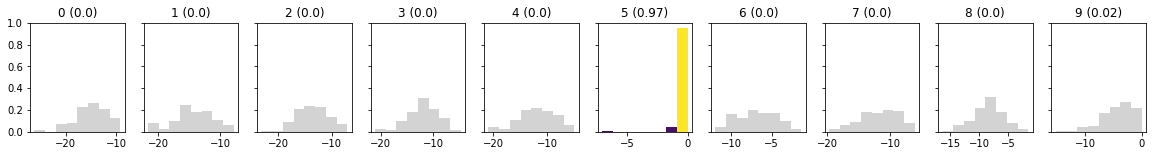

Incorrect :()
-------------------------
Real:  3


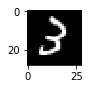

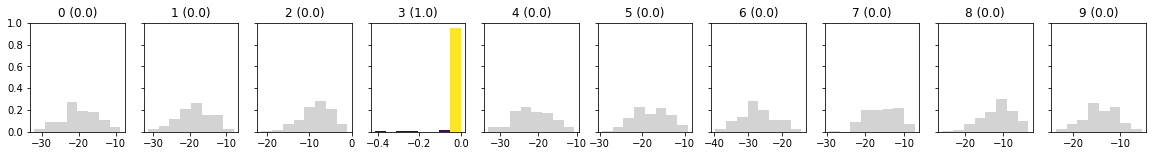

Correct
-------------------------
Real:  7


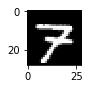

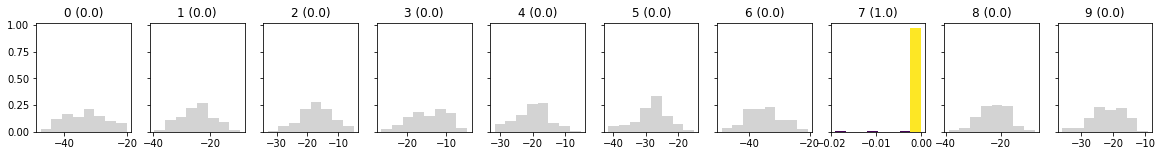

Correct
-------------------------
Real:  4


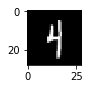

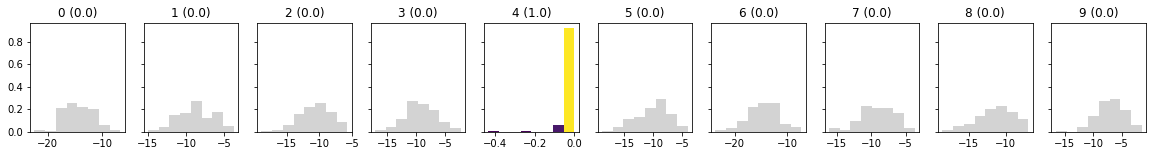

Correct
-------------------------
Real:  6


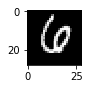

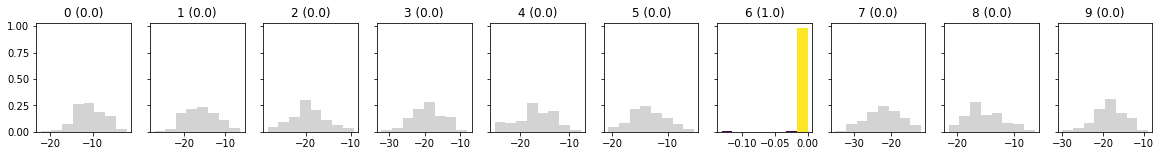

Correct
-------------------------
Real:  4


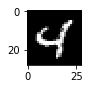

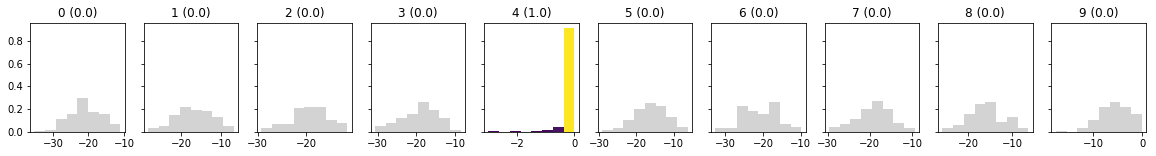

Correct
-------------------------
Real:  3


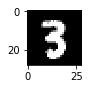

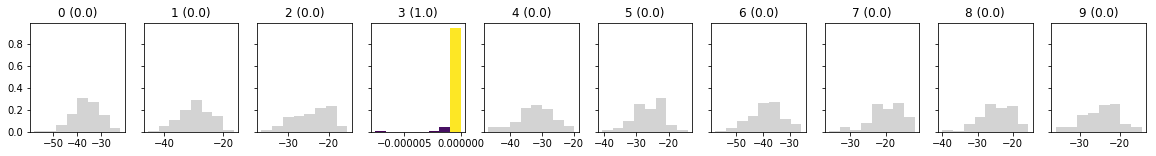

Correct
-------------------------
Real:  0


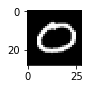

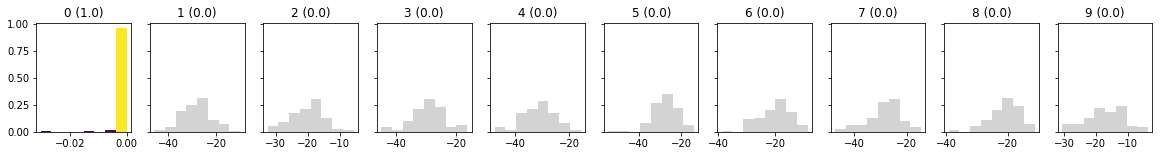

Correct
-------------------------
Real:  7


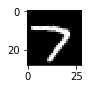

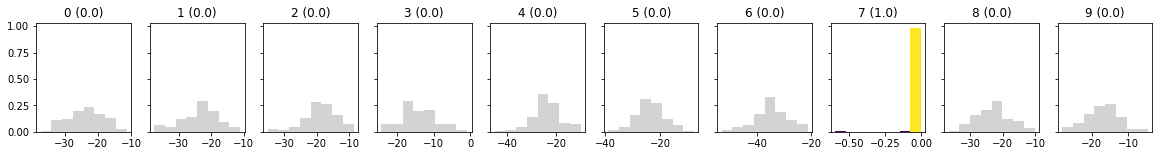

Correct
-------------------------
Real:  0


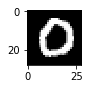

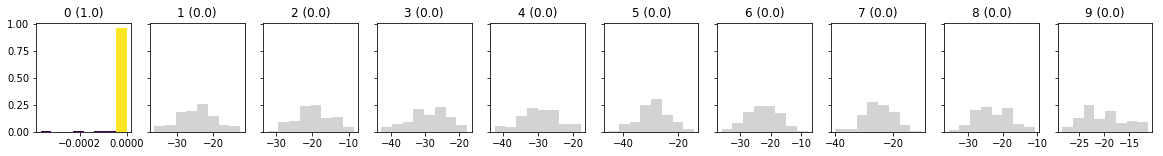

Correct
-------------------------
Real:  2


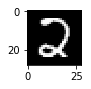

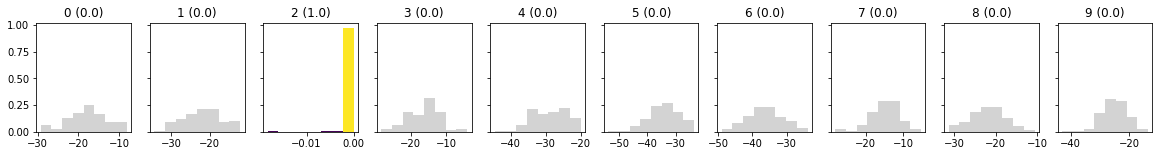

Correct
-------------------------
Real:  9


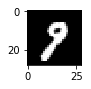

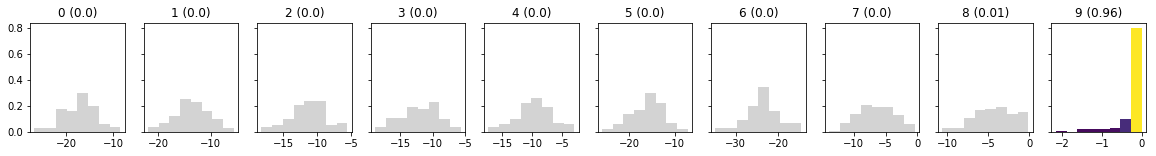

Correct
-------------------------
Real:  1


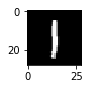

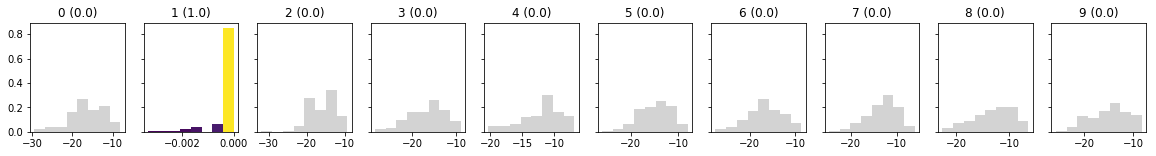

Correct
-------------------------
Real:  7


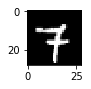

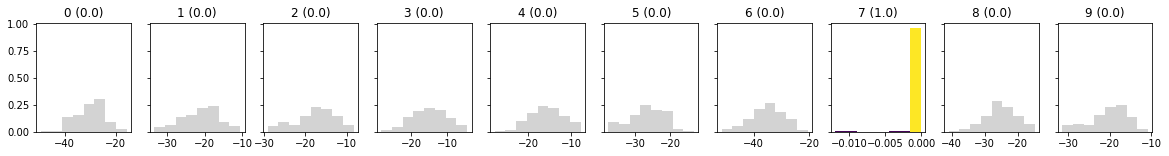

Correct
-------------------------
Real:  3


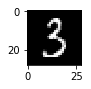

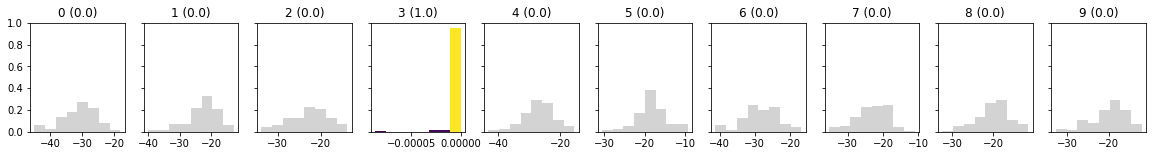

Correct
-------------------------
Real:  2


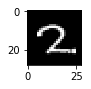

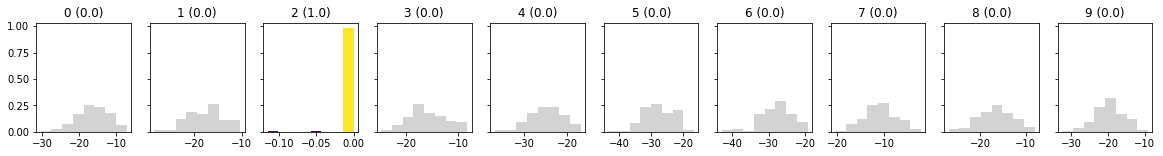

Correct
-------------------------
Real:  9


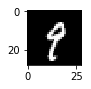

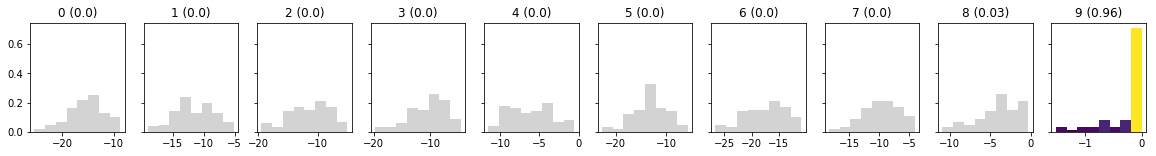

Correct
-------------------------
Real:  7


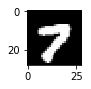

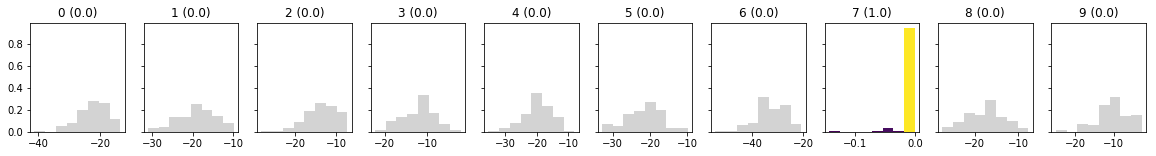

Correct
-------------------------
Real:  7


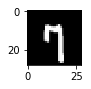

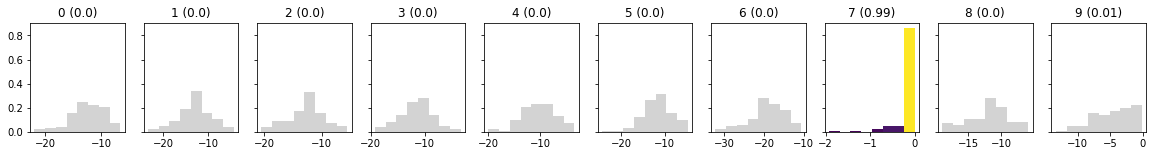

Correct
-------------------------
Real:  6


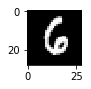

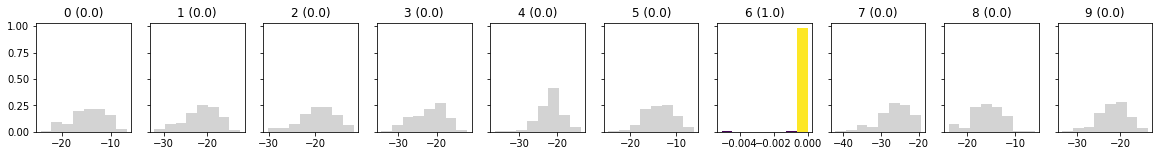

Correct
-------------------------
Real:  2


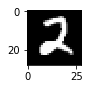

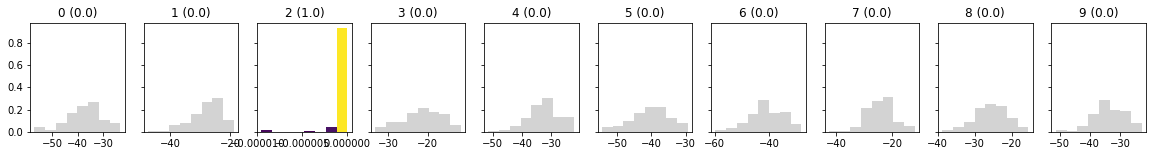

Correct
-------------------------
Real:  7


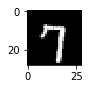

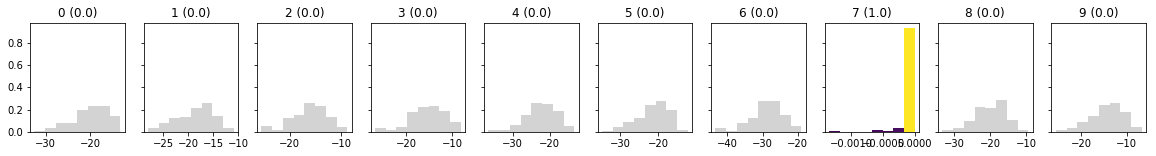

Correct
-------------------------
Real:  8


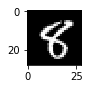

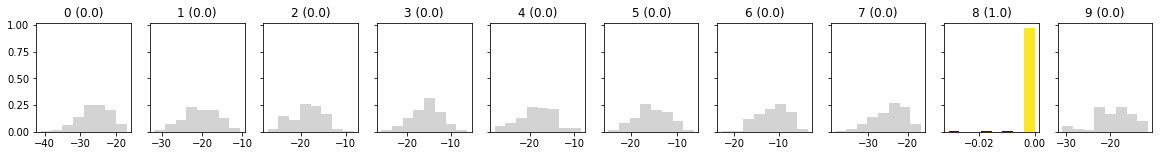

Correct
-------------------------
Real:  4


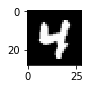

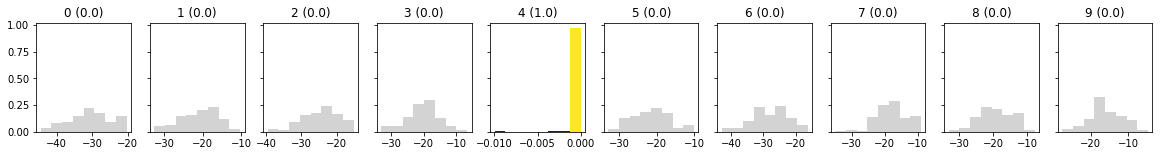

Correct
-------------------------
Real:  7


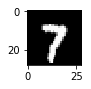

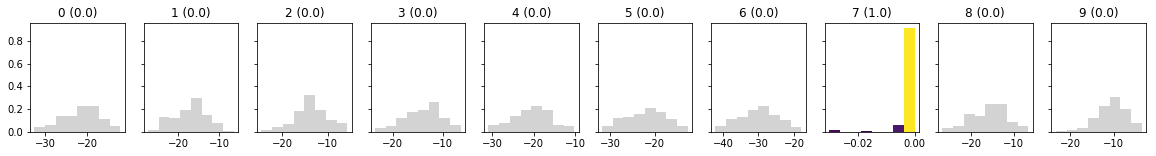

Correct
-------------------------
Real:  3


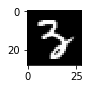

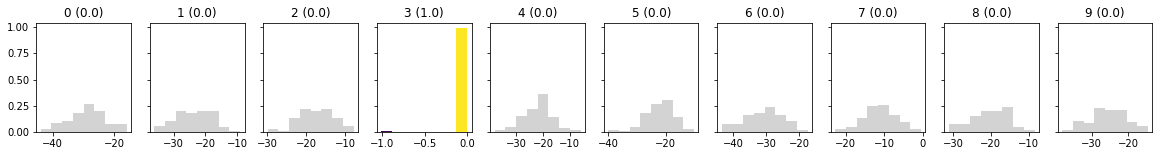

Correct
-------------------------
Real:  6


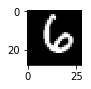

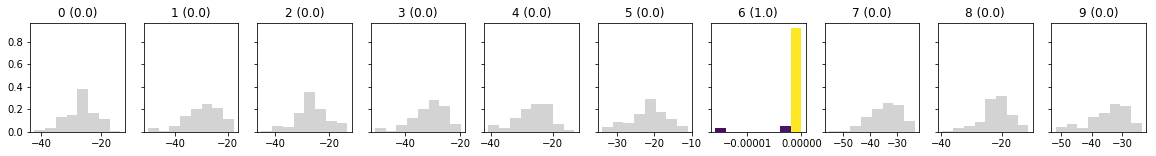

Correct
-------------------------
Real:  1


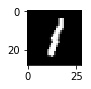

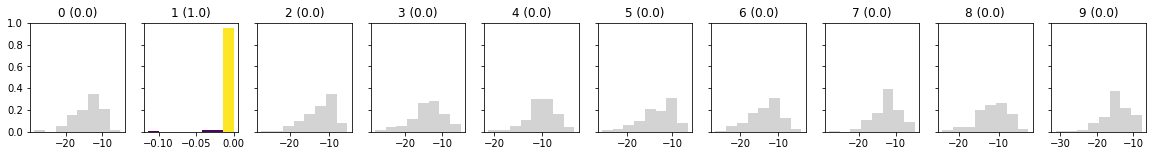

Correct
-------------------------
Real:  3


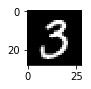

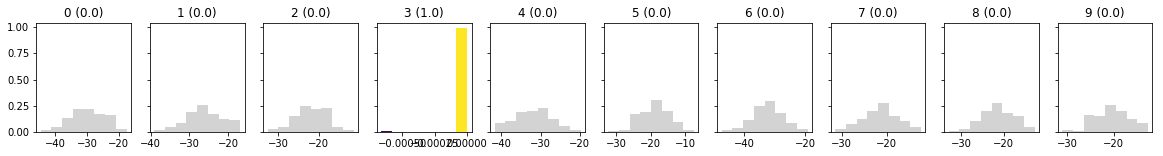

Correct
-------------------------
Real:  6


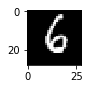

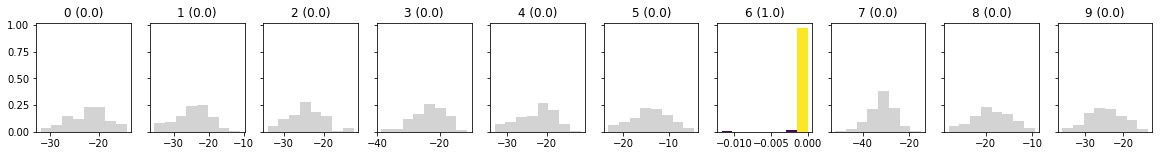

Correct
-------------------------
Real:  9


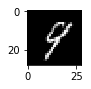

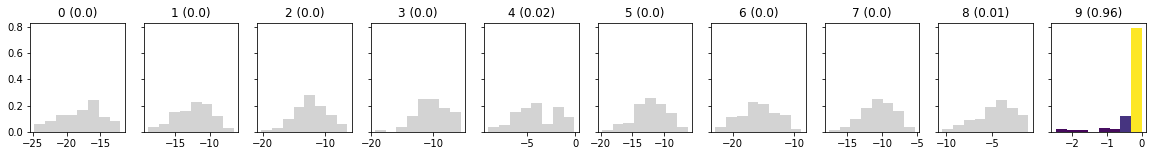

Correct
-------------------------
Real:  3


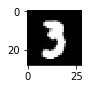

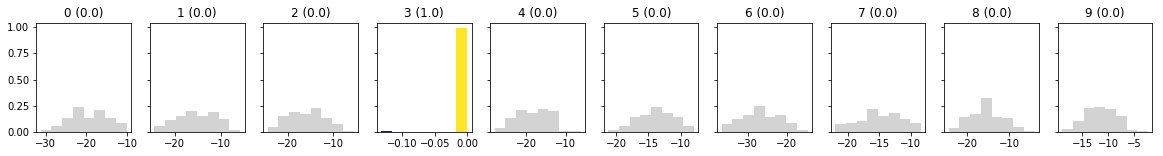

Correct
-------------------------
Real:  1


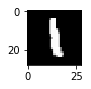

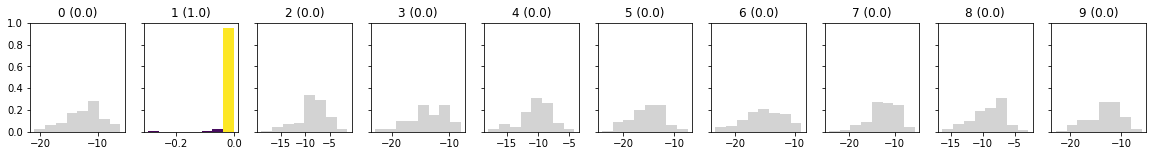

Correct
-------------------------
Real:  4


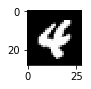

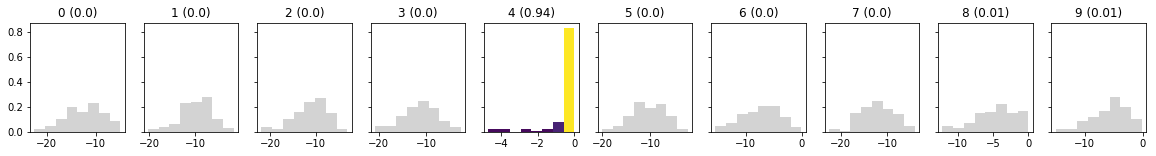

Correct
-------------------------
Real:  1


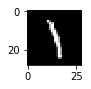

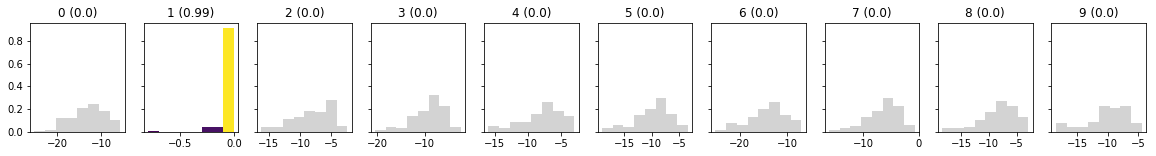

Correct
-------------------------
Real:  7


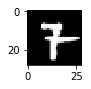

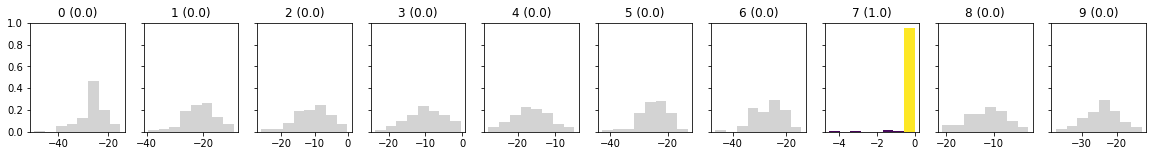

Correct
-------------------------
Real:  6


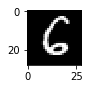

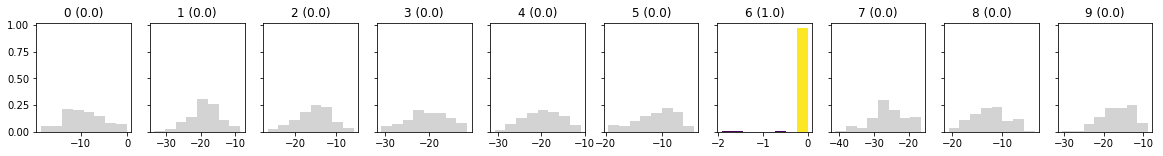

Correct
-------------------------
Real:  9


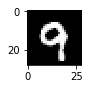

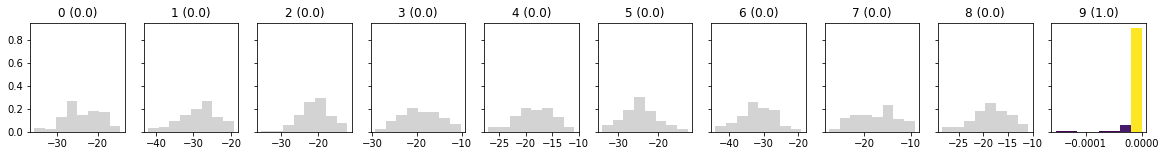

Correct
-------------------------
Summary
Total images:  100
Predicted for:  100
Accuracy when predicted:  0.99


In [0]:
# WORKING ON TEST SET, num_monte_carlo=100, threshold=0.5
num_monte_carlo = 100
feed_dict = {x: x_test, y: y_test, n: x_test.shape[0]}
logits = model(x)
op_logprobs = tf.nn.log_softmax(logits, axis=1)
with tf.compat.v1.Session() as sess:
  sess.run(init_op)
  saver = tf.train.import_meta_graph('my_test_model.meta')
  saver.restore(sess,tf.train.latest_checkpoint('./'))
  logprobs = np.asarray([sess.run((op_logprobs), feed_dict=feed_dict) for _ in range(num_monte_carlo)])

total_batch, correct_batch, predictions_batch = test_batch(x_test[:100], logprobs, y_test[:100], plot=True, threshold=0.5)  

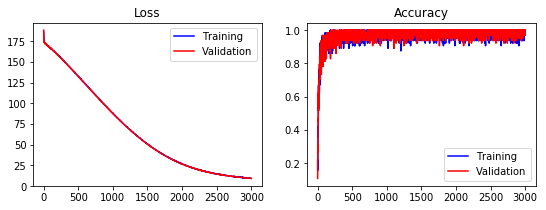

In [0]:
fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(range(n_iter), history_loss_train, 'b-', label='Training')
ax1.plot(range(n_iter), history_loss_val, 'r-', label='Validation')
ax1.set_title('Loss')
ax1.legend(loc='best')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(range(n_iter), history_acc_train, 'b-', label='Training')
ax2.plot(range(n_iter), history_acc_val, 'r-', label='Validation')
ax2.set_title('Accuracy')
ax2.legend(loc='best')
plt.show()

# EMNIST Uncertainty

In [0]:
!pip install emnist

In [0]:
# prova
from emnist import extract_training_samples
images, labels = extract_training_samples('letters')  # only letters
images = images.reshape((images.shape[0], 28, 28, 1))
images = images / 255.0

x_emnist = images[:100]
y_emnist = batch_y  # 100 labels from MNIST

num_monte_carlo = 100


 ... Held-out nats: -4.975


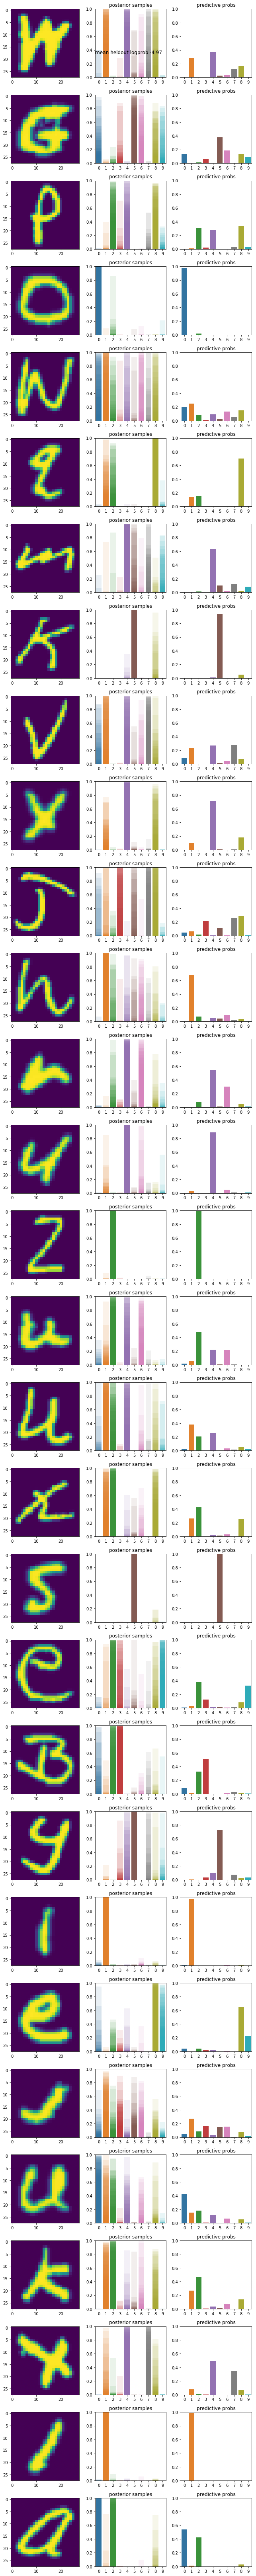

In [74]:
feed_dict = {x: x_emnist, y: y_emnist, n: x_emnist.shape[0]}
init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                     tf.compat.v1.local_variables_initializer())

with tf.compat.v1.Session() as sess:
  sess.run(init_op)
  saver = tf.train.import_meta_graph('my_test_model.meta')
  saver.restore(sess,tf.train.latest_checkpoint('./'))
  
  # Compute log prob of heldout set by averaging draws from the model:
  # p(heldout | train) = int_model p(heldout|model) p(model|train)
  #                   ~= 1/n * sum_{i=1}^n p(heldout | model_i)
  # where model_i is a draw from the posterior p(model|train).
  probs = np.asarray([sess.run((labels_distribution.probs), feed_dict=feed_dict) for _ in range(num_monte_carlo)])
  mean_probs = np.mean(probs, axis=0)

  # Placeholders! If you change dataset change dim!!!
  images = tf.placeholder(tf.float32,shape=[None,28,28,1])
  labels = tf.placeholder(tf.int32,shape=[None,])

  image_vals, label_vals = sess.run((images, labels), feed_dict={images: x_emnist, labels: y_emnist})
  
  heldout_lp = np.mean(np.log(mean_probs[np.arange(mean_probs.shape[0]),
                                           label_vals.flatten()]))
  print(" ... Held-out nats: {:.3f}".format(heldout_lp))

  qm_vals, qs_vals = sess.run((qmeans, qstds))

  if HAS_SEABORN:
    plot_heldout_prediction(image_vals, probs, title="mean heldout logprob {:.2f}".format(heldout_lp), n=30)

# Focus on EMNIST Uncertainty Analysis

Please, load EMNIST label dictionary

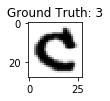

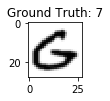

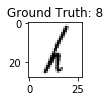

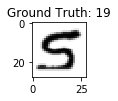

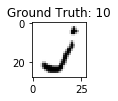

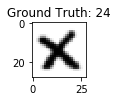

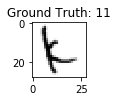

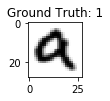

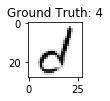

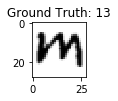

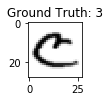

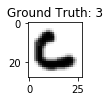

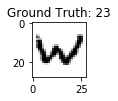

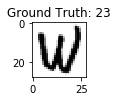

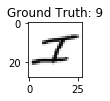

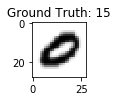

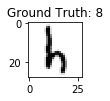

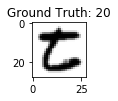

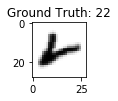

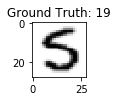

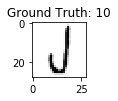

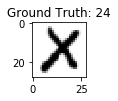

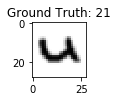

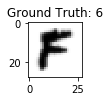

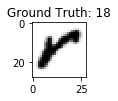

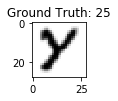

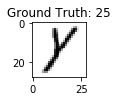

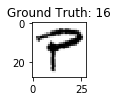

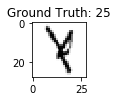

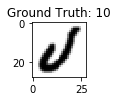

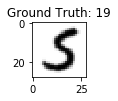

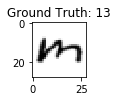

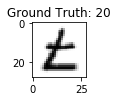

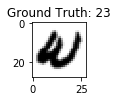

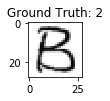

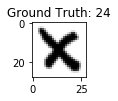

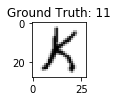

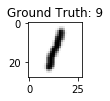

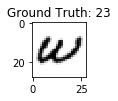

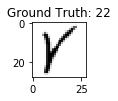

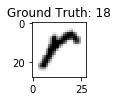

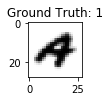

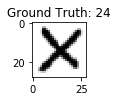

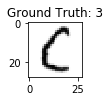

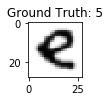

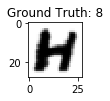

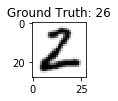

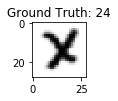

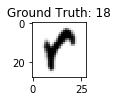

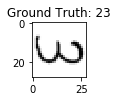

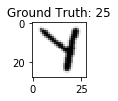

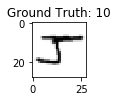

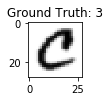

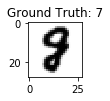

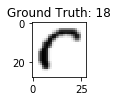

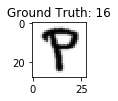

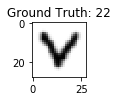

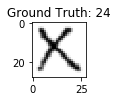

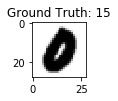

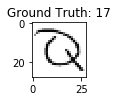

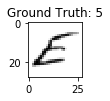

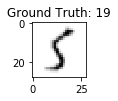

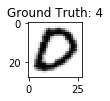

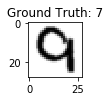

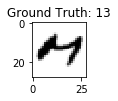

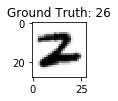

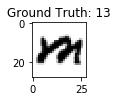

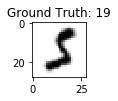

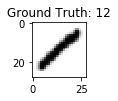

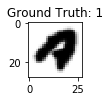

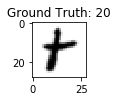

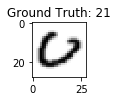

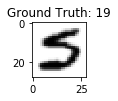

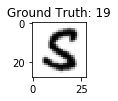

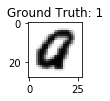

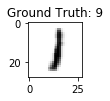

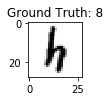

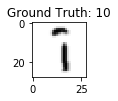

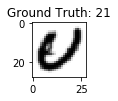

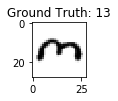

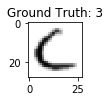

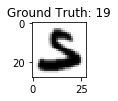

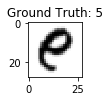

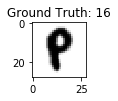

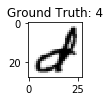

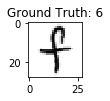

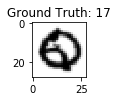

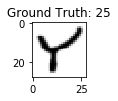

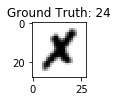

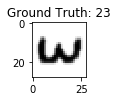

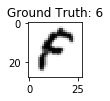

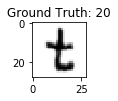

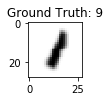

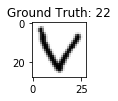

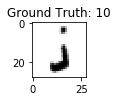

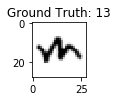

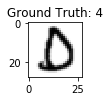

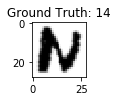

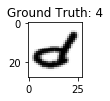

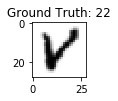

In [75]:
# prova
from emnist import extract_training_samples
images, labels = extract_training_samples('letters')  # only letters
images = images.reshape((images.shape[0], 28, 28, 1))
images = images / 255.0

batch_indices = np.random.choice(len(images), 100, replace=False)  # 10 random indices

emnist_x = images[batch_indices]
emnist_y = labels[batch_indices]

for img, label in zip(emnist_x, emnist_y):
  fig, ax = plt.subplots(figsize=(1, 1) )
  ax.set_title("Ground Truth: %s" % label)
  plt.imshow(img.reshape((28, 28)), cmap=plt.cm.binary)
  plt.show()    


In [0]:
# Tensorflow OPS
logits = model(x)
init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                     tf.compat.v1.local_variables_initializer())
probs = tf.nn.softmax(logits, axis=1)
labels_distribution = tfp.distributions.Categorical(logits=logits)
log_probs = labels_distribution.log_prob(y)

neg_log_likelihood = -tf.reduce_mean(log_probs)
kl = sum(model.losses) / len(x_train)
elbo_loss = neg_log_likelihood + kl

correct_preds = tf.equal(tf.cast(y, dtype=tf.int64), tf.argmax(probs, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

train_op = optimizer.minimize(elbo_loss)

In [77]:
logits = model(x)
stub_emnist_y = [0 for _ in range(len(emnist_x))]
feed_dict = {x: emnist_x, y: stub_emnist_y, n: len(emnist_x)}
print("num_monte_carlo: %d" % num_monte_carlo)

num_monte_carlo: 100


 ... Held-out nats: -7.003


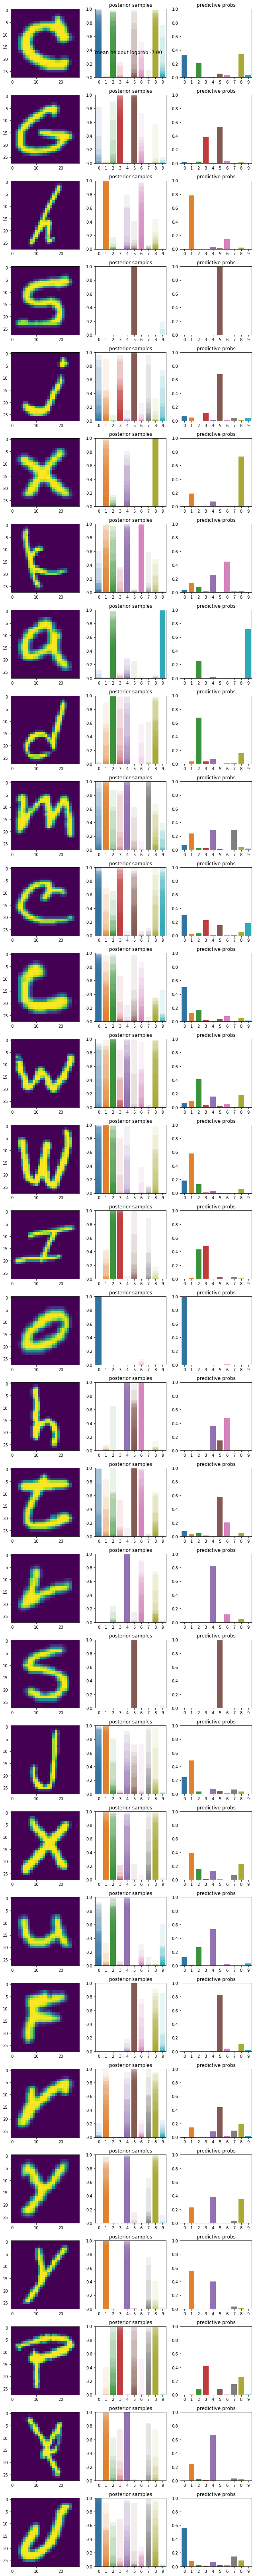

[5 5 1 5 5 1 6 9 8 1 5 0 6 1 3 0 6 8 4 5 1 1 0 5 1 4 1 2 1 0 5 6 8 0 8 8 5
 1 9 4 1 4 4 0 8 4 2 7 1 5 4 5 0 7 0 8 4 5 0 0 9 5 0 2 4 3 4 5 1 4 8 0 5 5
 0 1 6 1 8 7 0 5 8 8 8 4 0 4 2 6 8 8 1 7 5 5 0 1 2 4]


In [81]:

with tf.compat.v1.Session() as sess:
  sess.run(init_op)
  # LOADING TRAINED MODEL
  saver = tf.train.import_meta_graph('my_test_model.meta')
  saver.restore(sess,tf.train.latest_checkpoint('./'))
  
  # Compute log prob of heldout set by averaging draws from the model:
  # p(heldout | train) = int_model p(heldout|model) p(model|train)
  #                   ~= 1/n * sum_{i=1}^n p(heldout | model_i)
  # where model_i is a draw from the posterior p(model|train).
  probs = np.asarray([sess.run((labels_distribution.probs), feed_dict={x: emnist_x}) for _ in range(num_monte_carlo)])
  predictions = sess.run((tf.argmax(tf.nn.softmax(model(x)), 1)), {x:emnist_x})
  mean_probs = np.mean(probs, axis=0)

  # Placeholders! If you change dataset change dim!!!
  images = tf.placeholder(tf.float32,shape=[None,28,28,1])
  labels = tf.placeholder(tf.int32,shape=[None,])

  image_vals, label_vals = sess.run((images, labels), feed_dict={images: emnist_x, labels: stub_emnist_y})
  
  heldout_lp = np.mean(np.log(mean_probs[np.arange(mean_probs.shape[0]),
                                           label_vals.flatten()]))
  print(" ... Held-out nats: {:.3f}".format(heldout_lp))

  qm_vals, qs_vals = sess.run((qmeans, qstds))

  if HAS_SEABORN:
    plot_heldout_prediction(image_vals, probs, title="mean heldout logprob {:.2f}".format(heldout_lp), n=30)
    
  print(predictions)
  

In [83]:

print("x: ", x)
print("logits: ", logits)

x:  Tensor("Placeholder:0", shape=(?, 28, 28, 1), dtype=float32)
logits:  Tensor("model_21/dense_flipout_1/BiasAdd:0", shape=(?, 10), dtype=float32)


In [0]:
# REPEATING THE SAME ON EMNIST, num_monte_carlo 100
logits = model(x)
num_monte_carlo = 100
op_logprobs = tf.nn.log_softmax(logits, axis=1)
with tf.compat.v1.Session() as sess:
  sess.run(init_op)
  saver = tf.train.import_meta_graph('my_test_model.meta')
  saver.restore(sess,tf.train.latest_checkpoint('./'))
  logprobs = np.asarray([sess.run((op_logprobs), feed_dict=feed_dict) for _ in range(num_monte_carlo)])

In [85]:
print("logprobs shape: ", logprobs.shape)  # shape is: num_monte_carlo, samples, labes/classes
print('shape is: (num_monte_carlo, samples, labels/classes)')


logprobs shape:  (100, 100, 10)
shape is: (num_monte_carlo, samples, labels/classes)


Real:  0


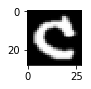

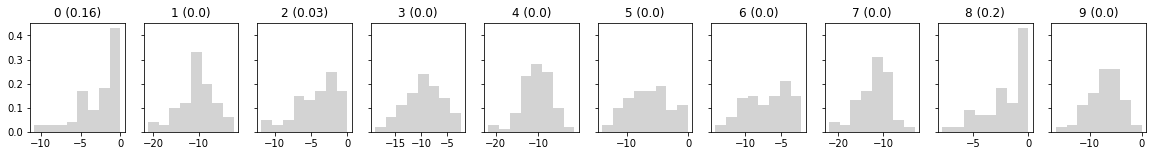

Undecided.
-------------------------
Real:  0


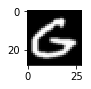

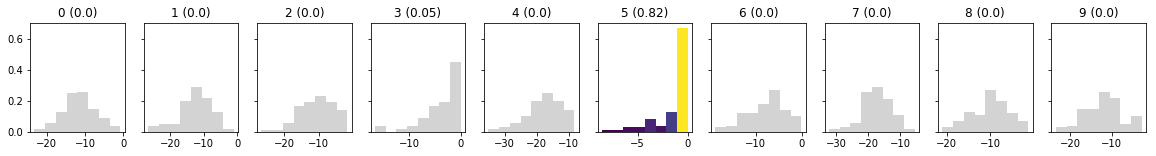

Incorrect :()
-------------------------
Real:  0


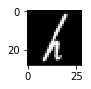

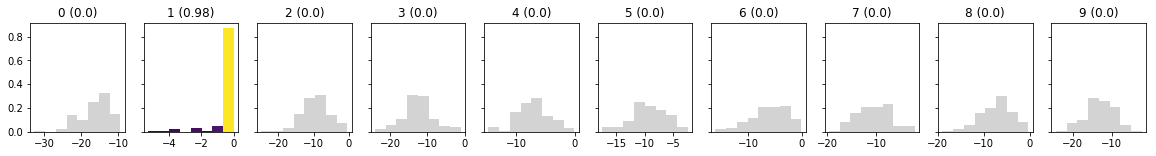

Incorrect :()
-------------------------
Real:  0


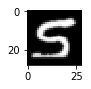

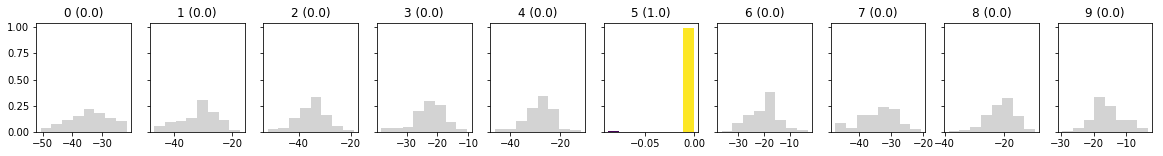

Incorrect :()
-------------------------
Real:  0


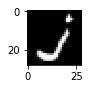

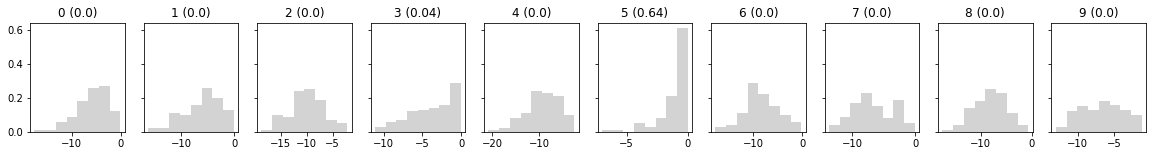

Undecided.
-------------------------
Real:  0


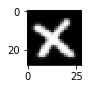

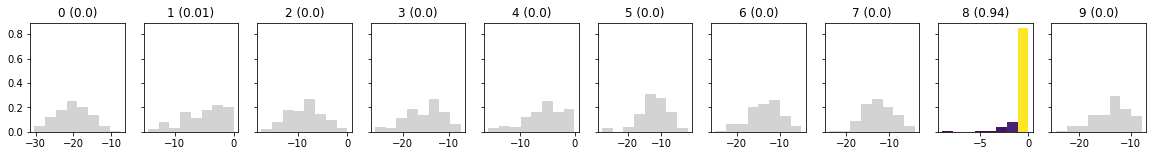

Incorrect :()
-------------------------
Real:  0


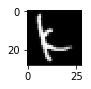

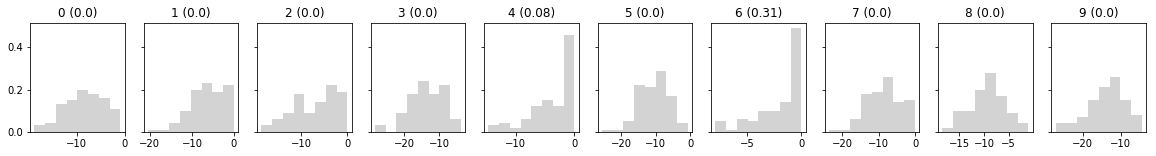

Undecided.
-------------------------
Real:  0


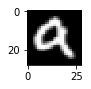

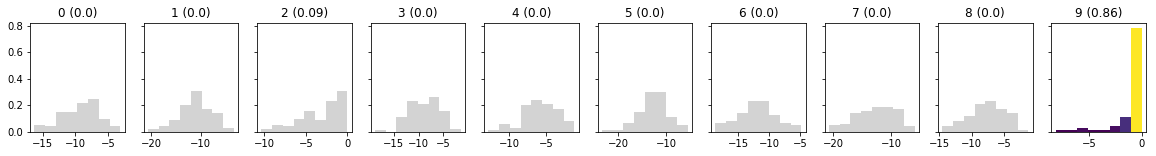

Incorrect :()
-------------------------
Real:  0


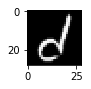

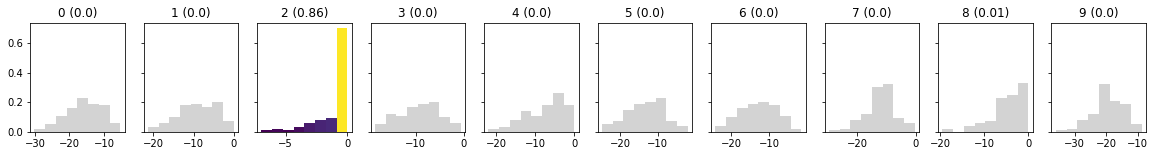

Incorrect :()
-------------------------
Real:  0


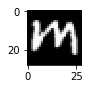

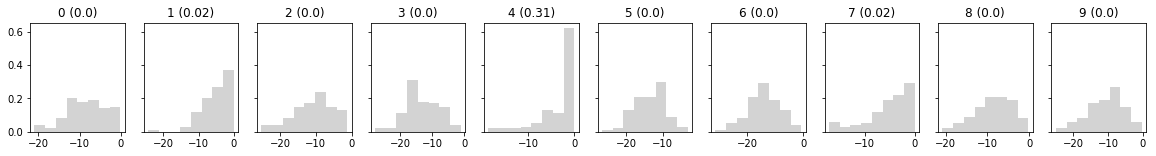

Undecided.
-------------------------
Real:  0


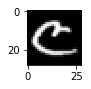

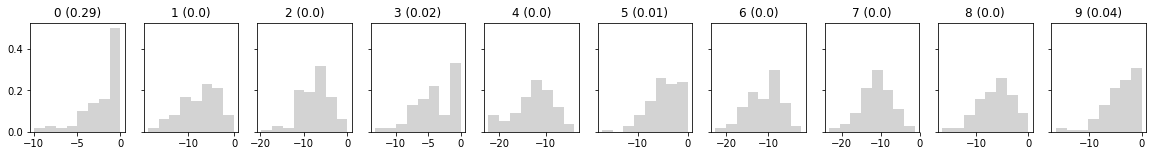

Undecided.
-------------------------
Real:  0


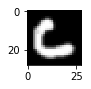

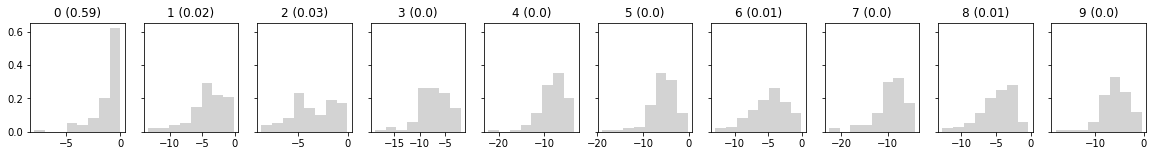

Undecided.
-------------------------
Real:  0


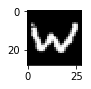

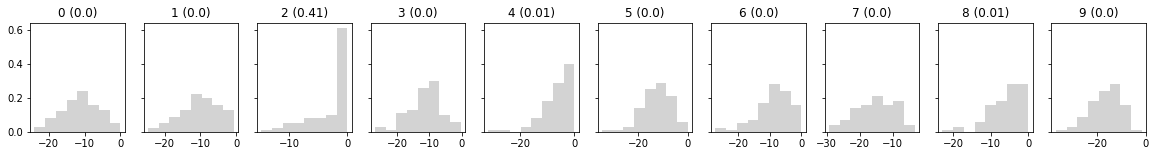

Undecided.
-------------------------
Real:  0


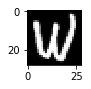

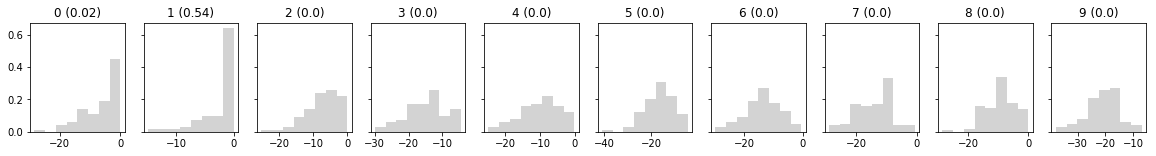

Undecided.
-------------------------
Real:  0


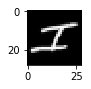

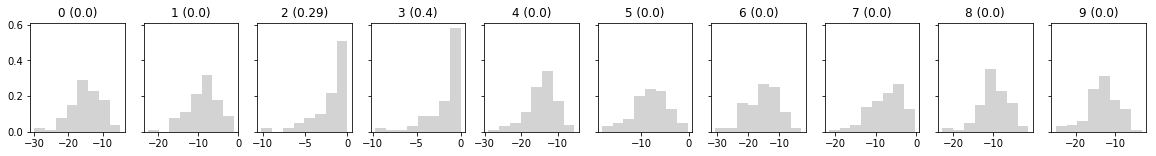

Undecided.
-------------------------
Real:  0


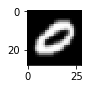

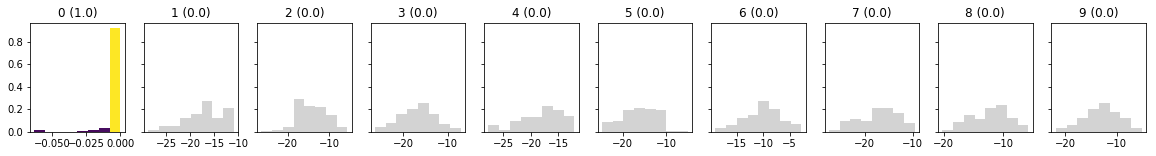

Correct
-------------------------
Real:  0


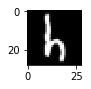

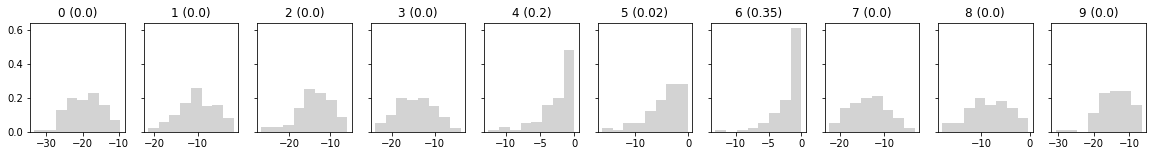

Undecided.
-------------------------
Real:  0


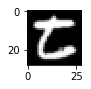

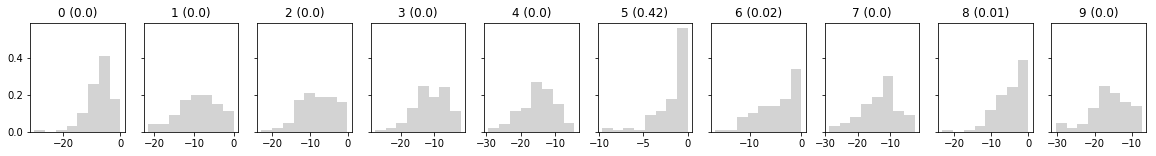

Undecided.
-------------------------
Real:  0


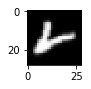

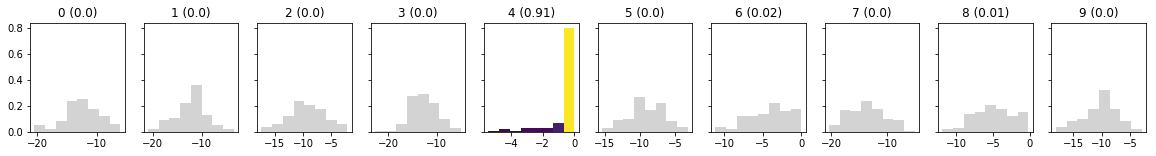

Incorrect :()
-------------------------
Real:  0


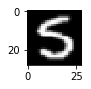

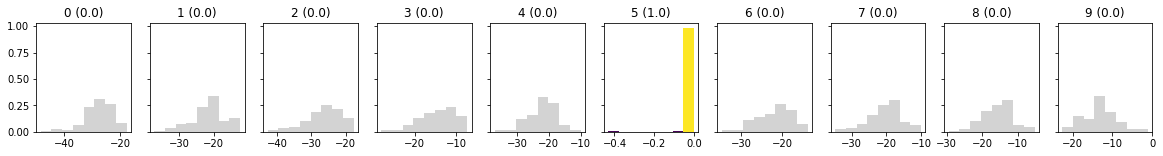

Incorrect :()
-------------------------
Real:  0


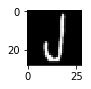

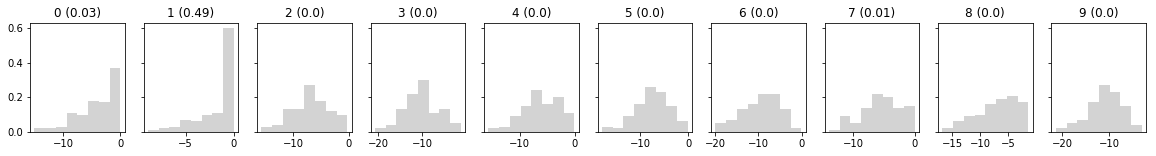

Undecided.
-------------------------
Real:  0


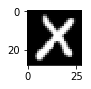

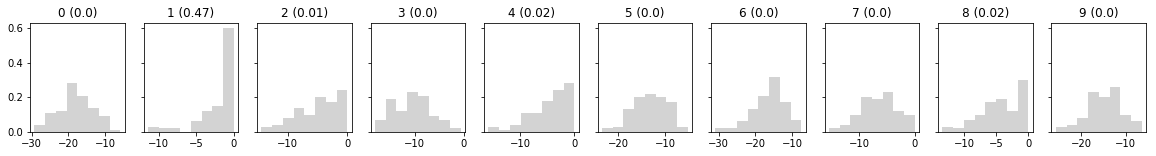

Undecided.
-------------------------
Real:  0


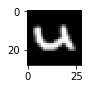

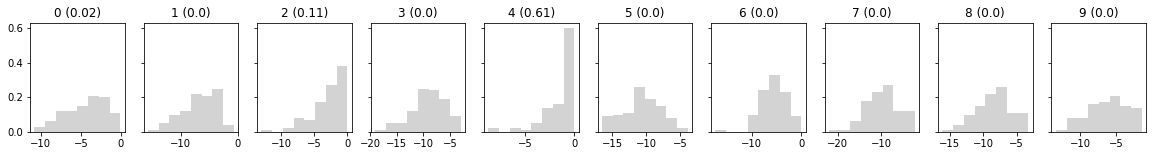

Undecided.
-------------------------
Real:  0


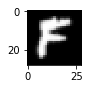

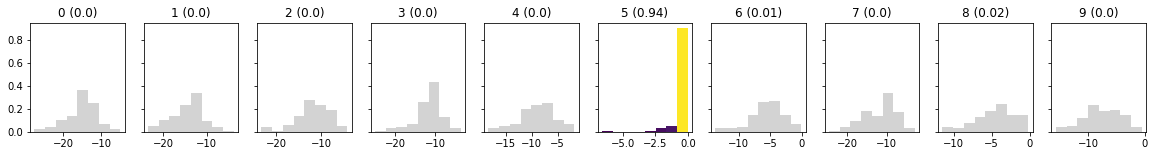

Incorrect :()
-------------------------
Real:  0


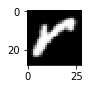

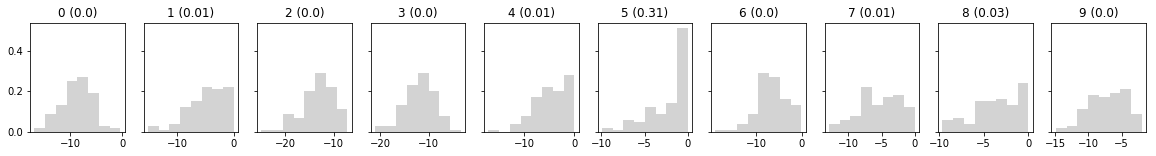

Undecided.
-------------------------
Real:  0


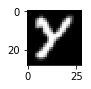

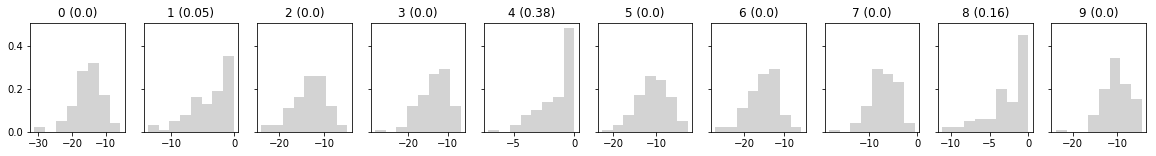

Undecided.
-------------------------
Real:  0


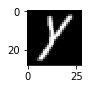

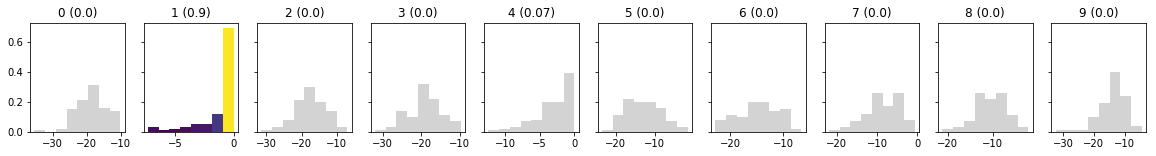

Incorrect :()
-------------------------
Real:  0


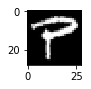

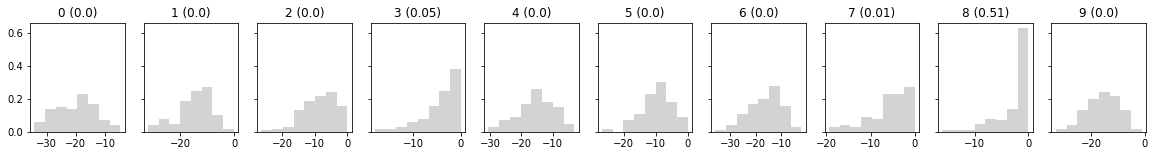

Undecided.
-------------------------
Real:  0


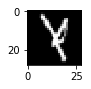

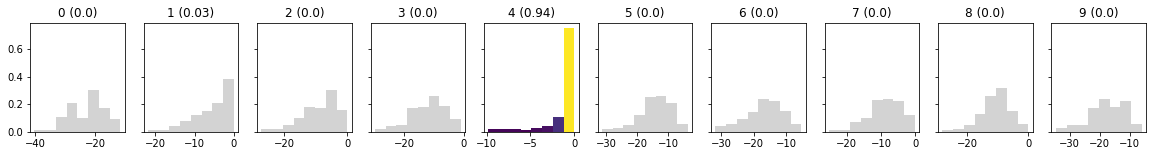

Incorrect :()
-------------------------
Real:  0


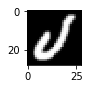

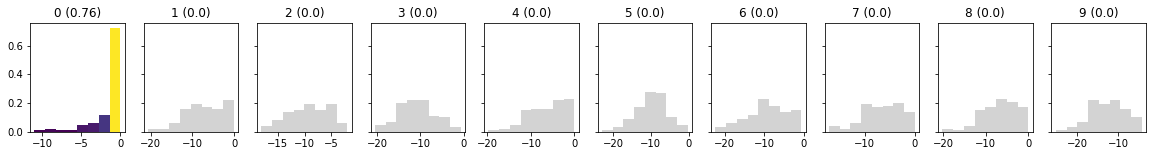

Correct
-------------------------
Real:  0


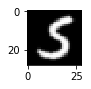

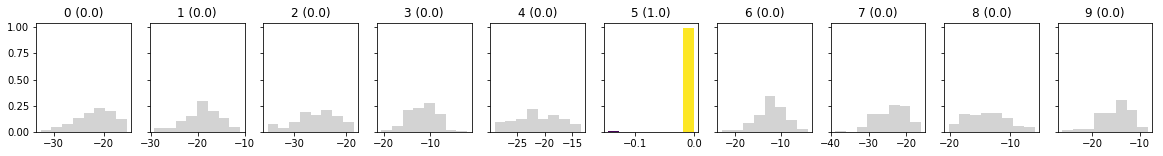

Incorrect :()
-------------------------
Real:  0


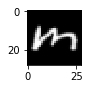

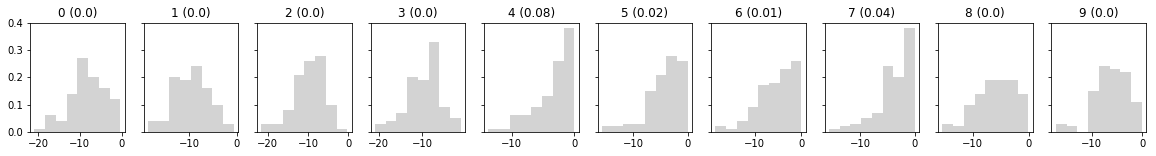

Undecided.
-------------------------
Real:  0


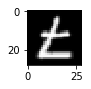

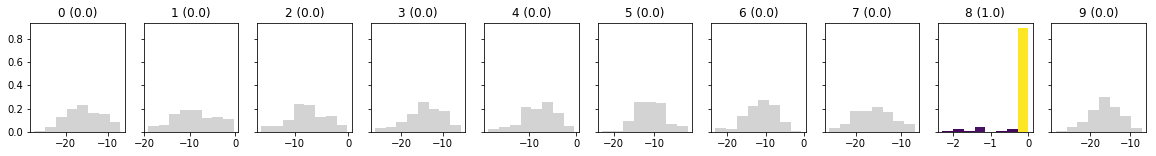

Incorrect :()
-------------------------
Real:  0


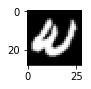

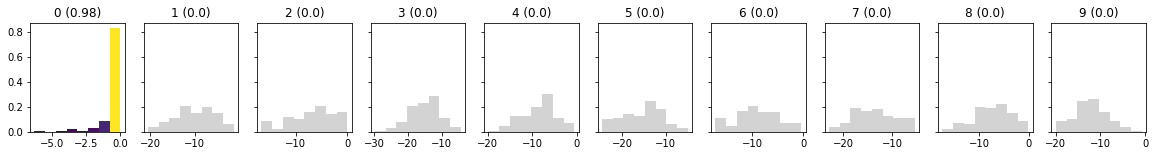

Correct
-------------------------
Real:  0


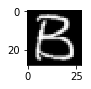

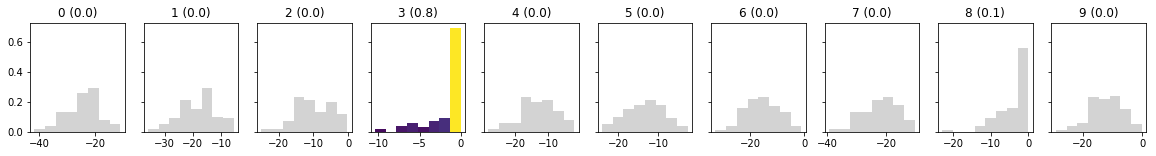

Incorrect :()
-------------------------
Real:  0


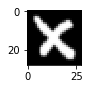

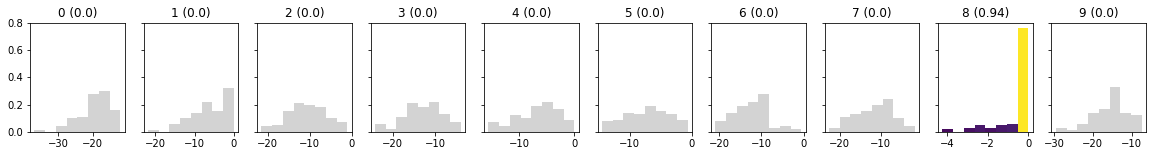

Incorrect :()
-------------------------
Real:  0


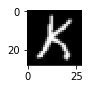

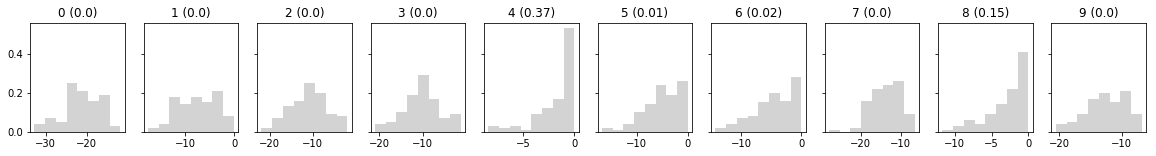

Undecided.
-------------------------
Real:  0


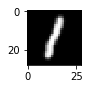

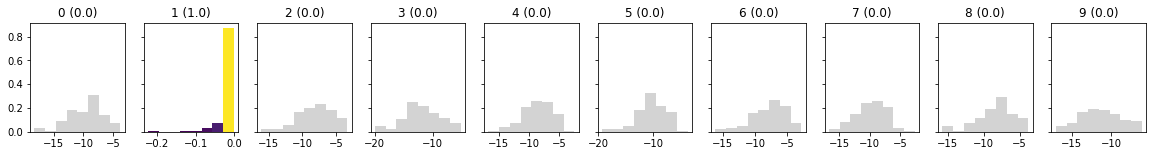

Incorrect :()
-------------------------
Real:  0


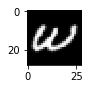

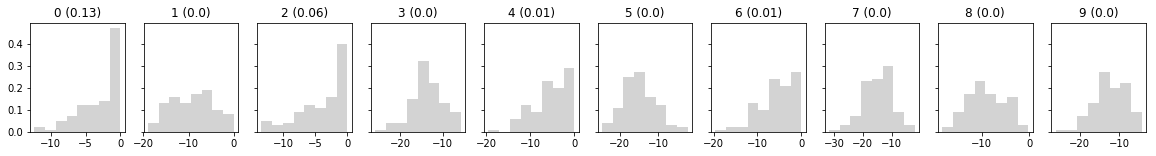

Undecided.
-------------------------
Real:  0


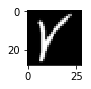

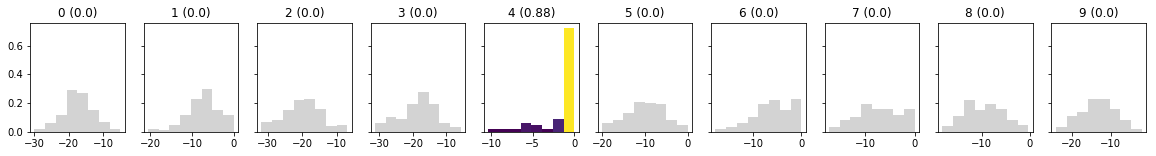

Incorrect :()
-------------------------
Real:  0


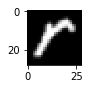

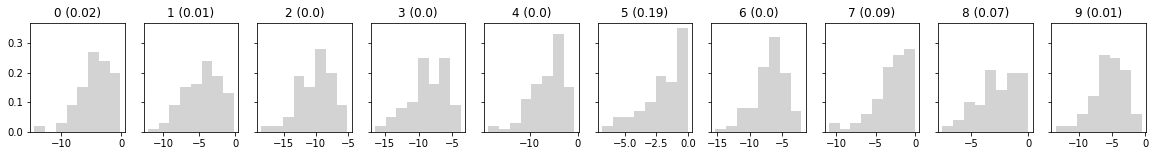

Undecided.
-------------------------
Real:  0


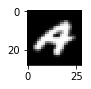

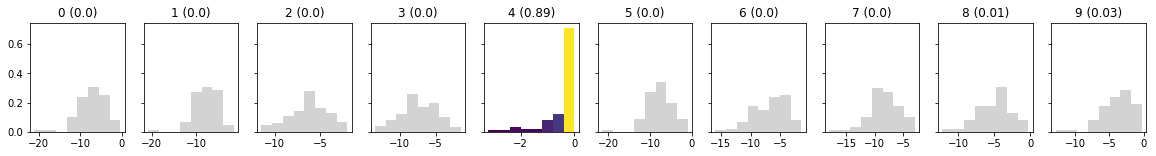

Incorrect :()
-------------------------
Real:  0


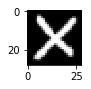

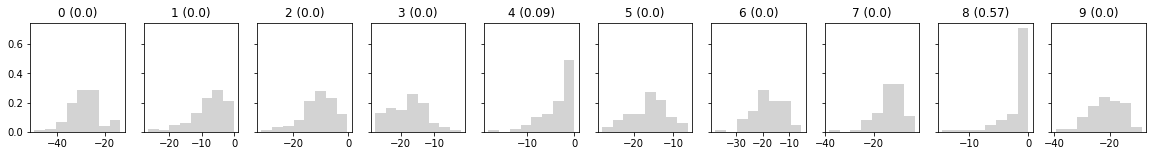

Undecided.
-------------------------
Real:  0


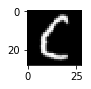

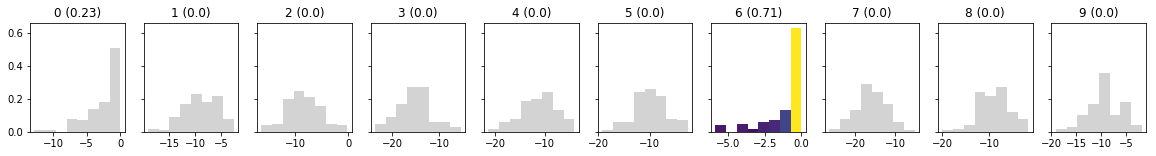

Incorrect :()
-------------------------
Real:  0


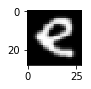

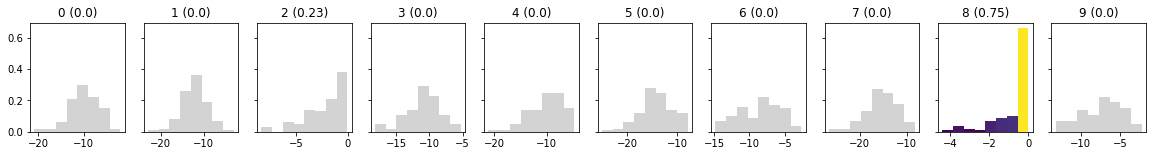

Incorrect :()
-------------------------
Real:  0


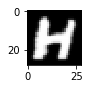

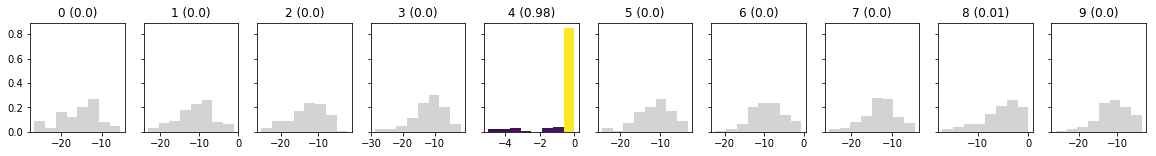

Incorrect :()
-------------------------
Real:  0


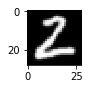

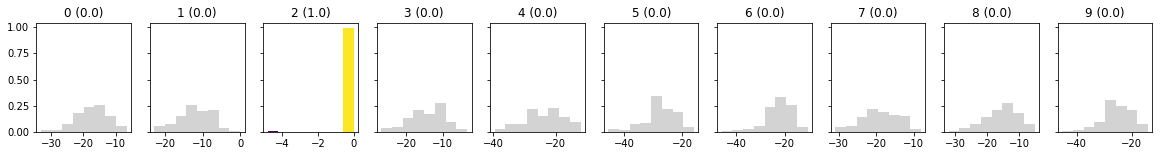

Incorrect :()
-------------------------
Real:  0


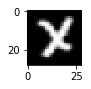

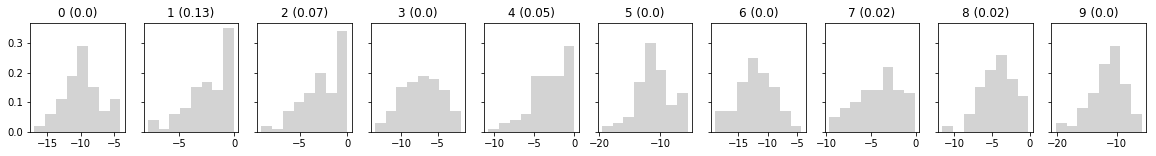

Undecided.
-------------------------
Real:  0


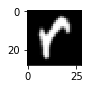

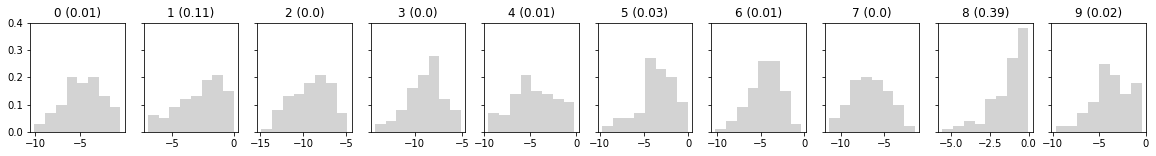

Undecided.
-------------------------
Real:  0


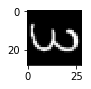

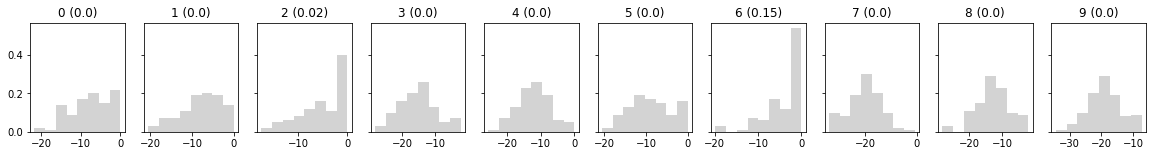

Undecided.
-------------------------
Real:  0


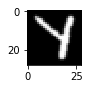

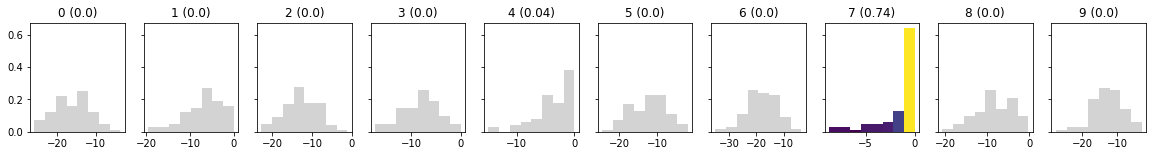

Incorrect :()
-------------------------
Real:  0


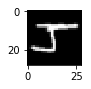

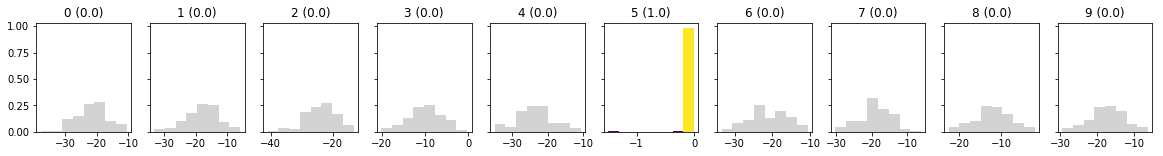

Incorrect :()
-------------------------
Real:  0


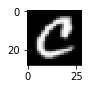

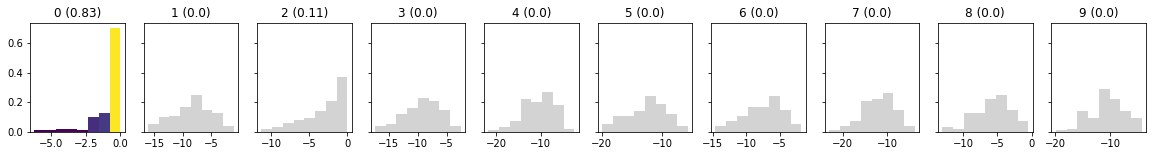

Correct
-------------------------
Real:  0


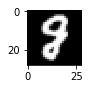

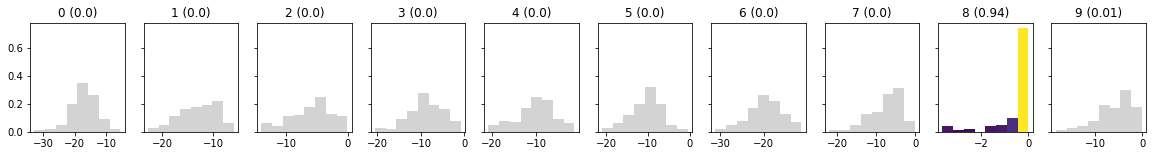

Incorrect :()
-------------------------
Real:  0


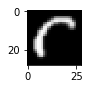

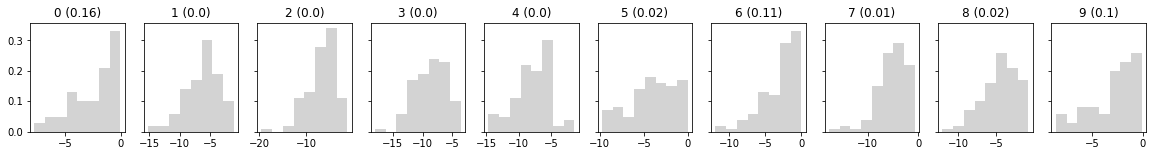

Undecided.
-------------------------
Real:  0


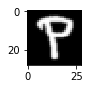

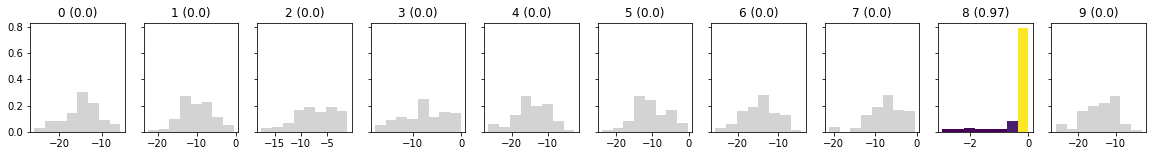

Incorrect :()
-------------------------
Real:  0


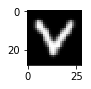

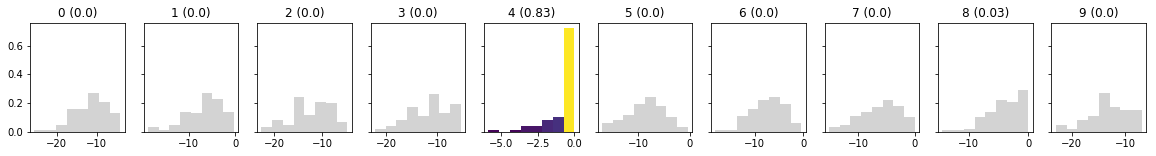

Incorrect :()
-------------------------
Real:  0


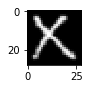

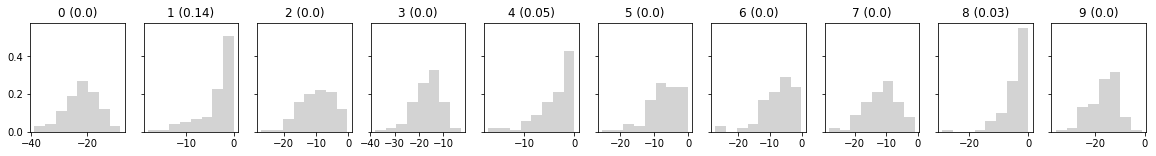

Undecided.
-------------------------
Real:  0


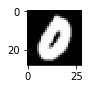

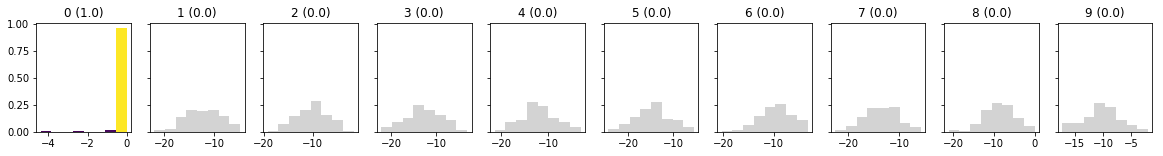

Correct
-------------------------
Real:  0


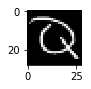

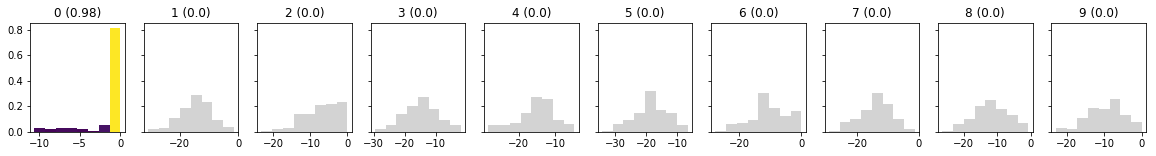

Correct
-------------------------
Real:  0


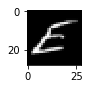

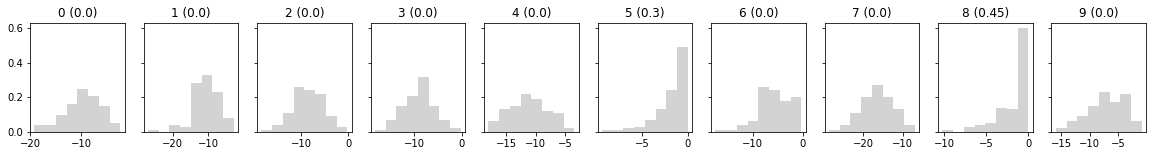

Undecided.
-------------------------
Real:  0


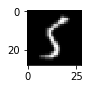

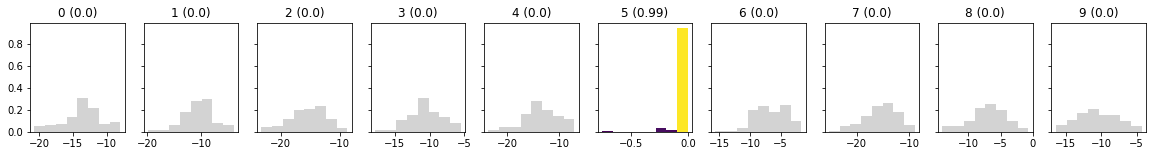

Incorrect :()
-------------------------
Real:  0


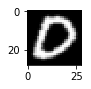

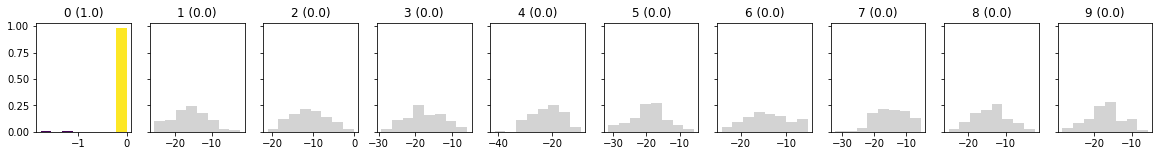

Correct
-------------------------
Real:  0


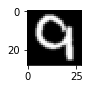

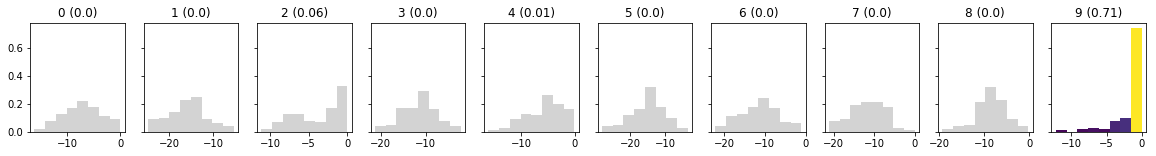

Incorrect :()
-------------------------
Real:  0


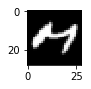

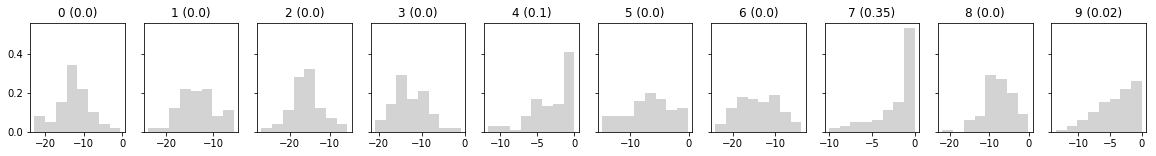

Undecided.
-------------------------
Real:  0


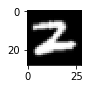

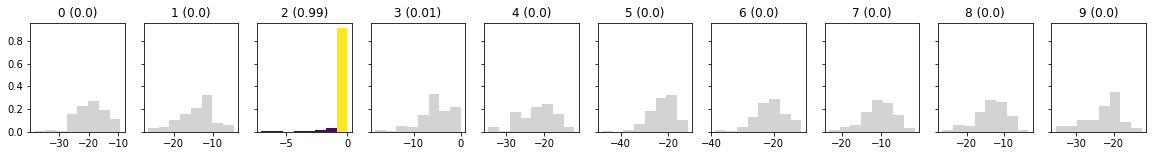

Incorrect :()
-------------------------
Real:  0


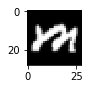

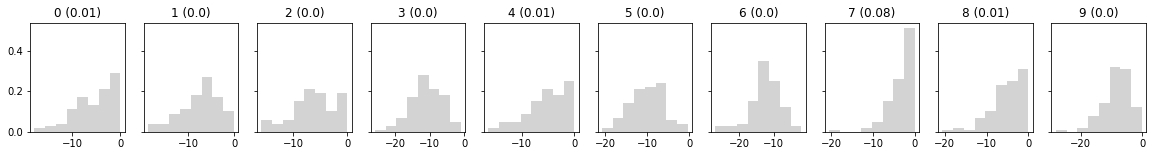

Undecided.
-------------------------
Real:  0


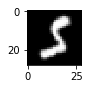

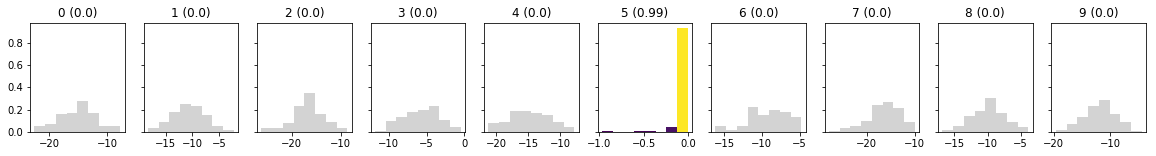

Incorrect :()
-------------------------
Real:  0


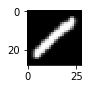

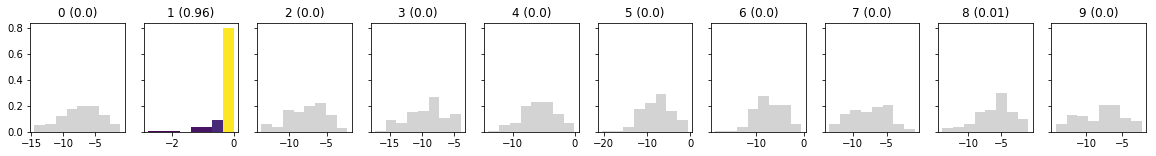

Incorrect :()
-------------------------
Real:  0


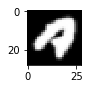

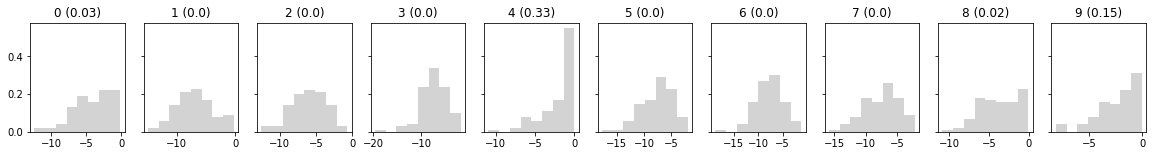

Undecided.
-------------------------
Real:  0


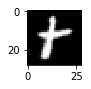

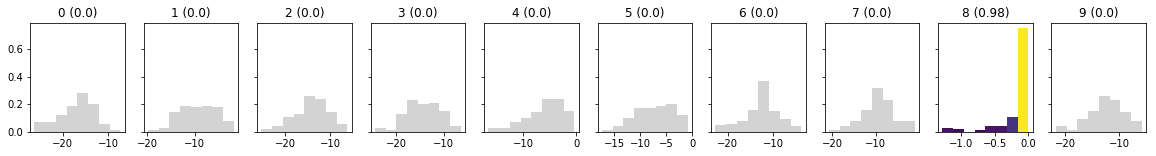

Incorrect :()
-------------------------
Real:  0


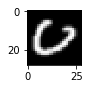

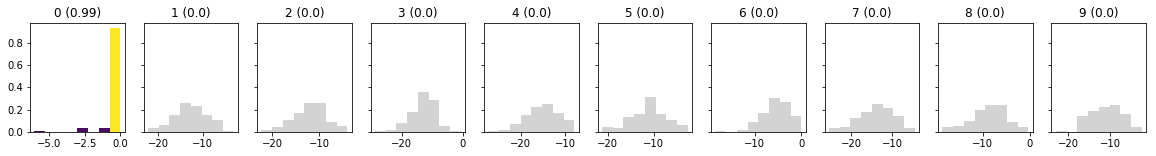

Correct
-------------------------
Real:  0


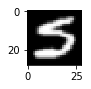

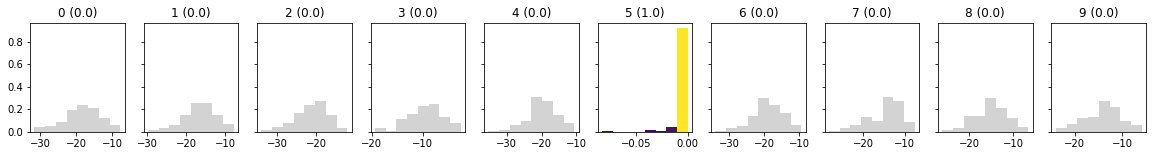

Incorrect :()
-------------------------
Real:  0


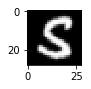

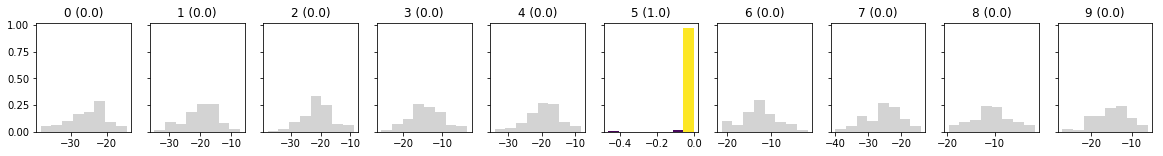

Incorrect :()
-------------------------
Real:  0


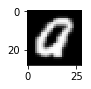

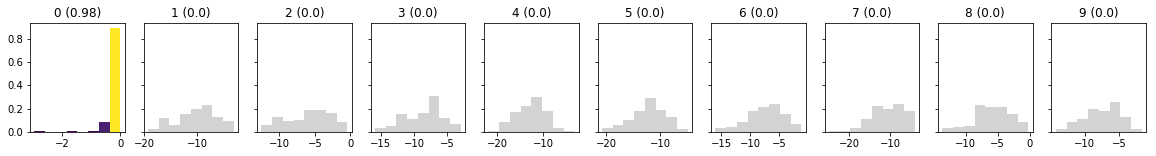

Correct
-------------------------
Real:  0


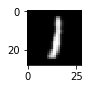

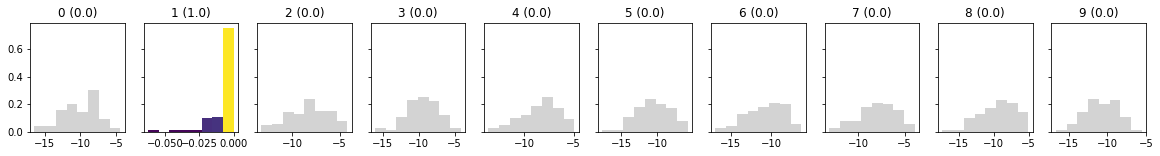

Incorrect :()
-------------------------
Real:  0


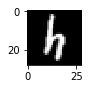

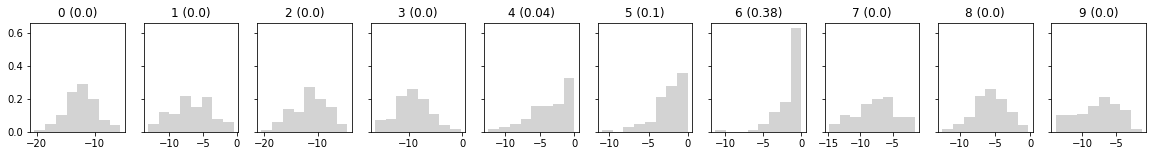

Undecided.
-------------------------
Real:  0


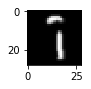

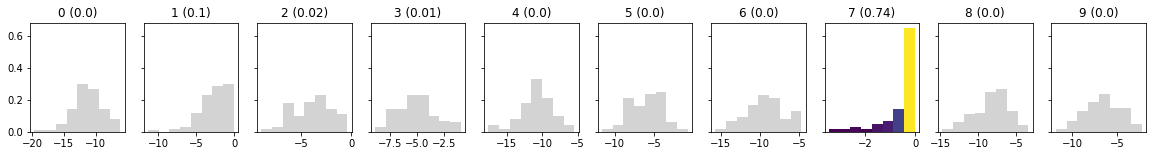

Incorrect :()
-------------------------
Real:  0


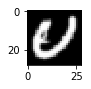

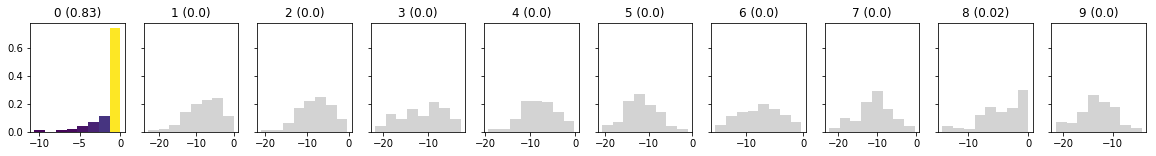

Correct
-------------------------
Real:  0


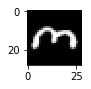

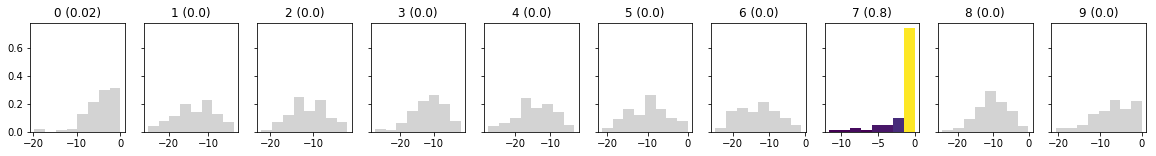

Incorrect :()
-------------------------
Real:  0


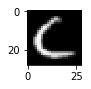

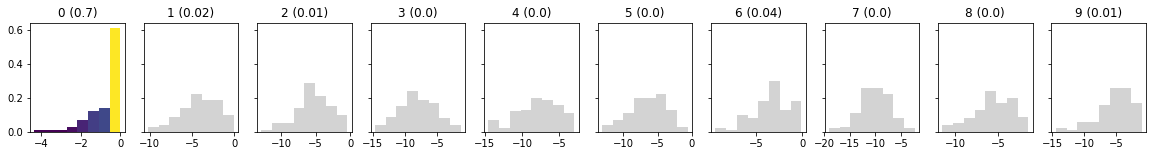

Correct
-------------------------
Real:  0


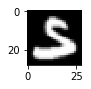

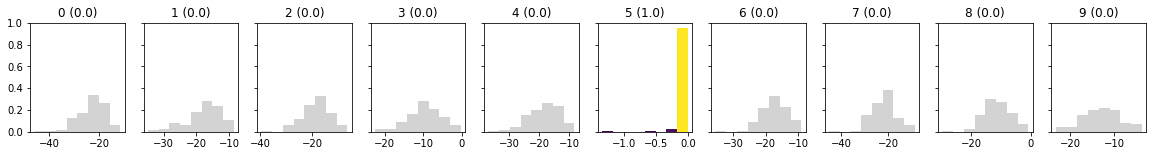

Incorrect :()
-------------------------
Real:  0


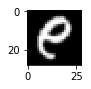

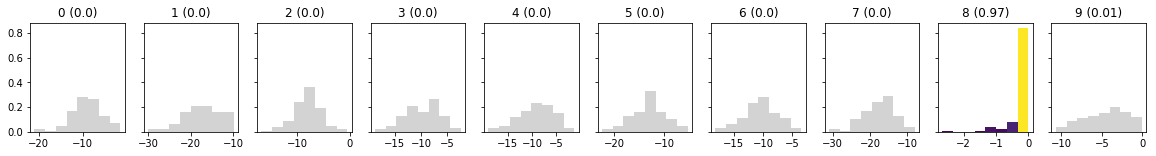

Incorrect :()
-------------------------
Real:  0


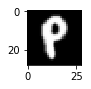

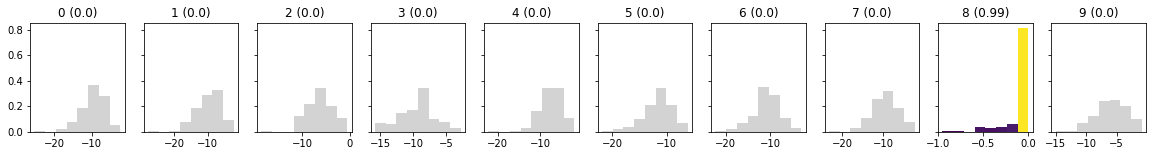

Incorrect :()
-------------------------
Real:  0


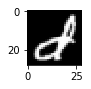

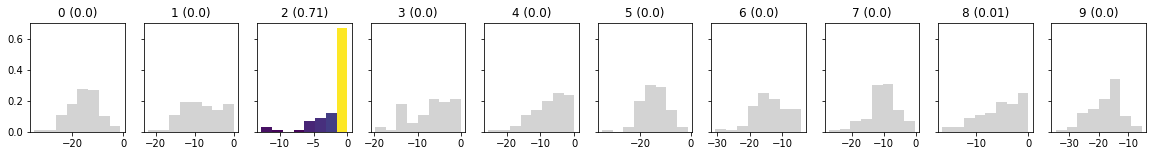

Incorrect :()
-------------------------
Real:  0


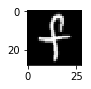

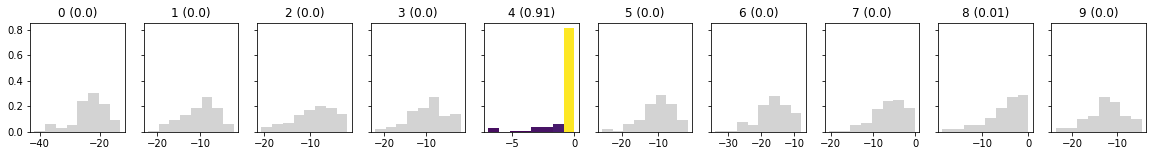

Incorrect :()
-------------------------
Real:  0


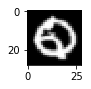

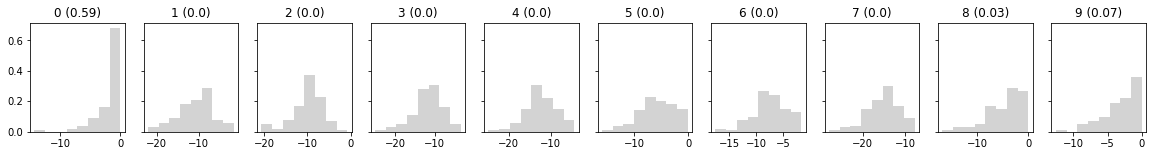

Undecided.
-------------------------
Real:  0


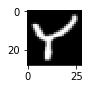

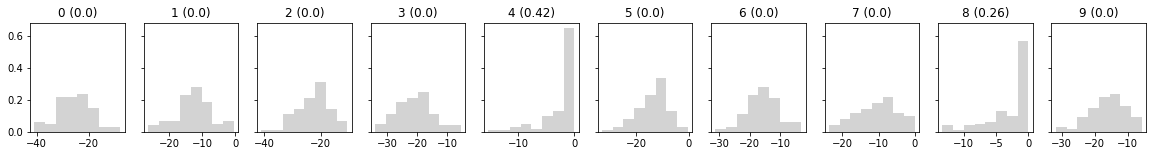

Undecided.
-------------------------
Real:  0


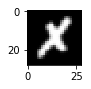

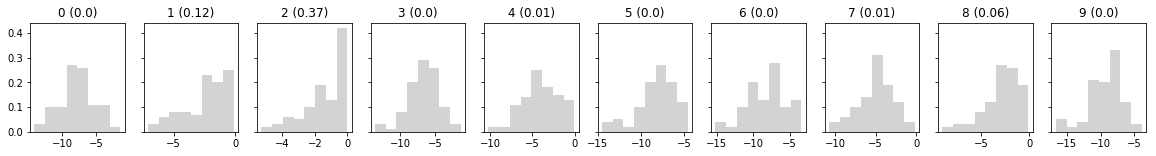

Undecided.
-------------------------
Real:  0


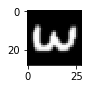

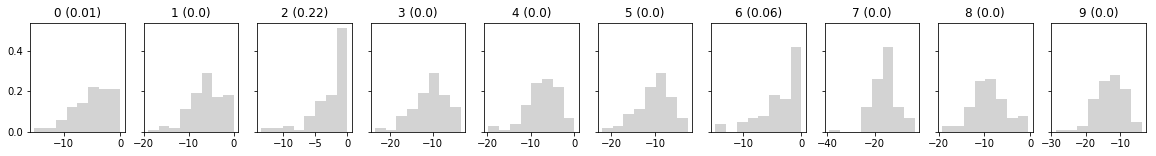

Undecided.
-------------------------
Real:  0


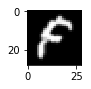

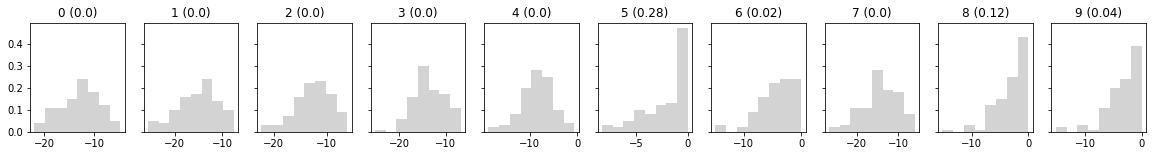

Undecided.
-------------------------
Real:  0


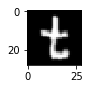

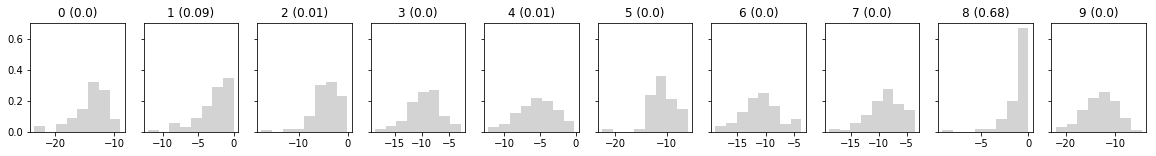

Undecided.
-------------------------
Real:  0


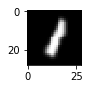

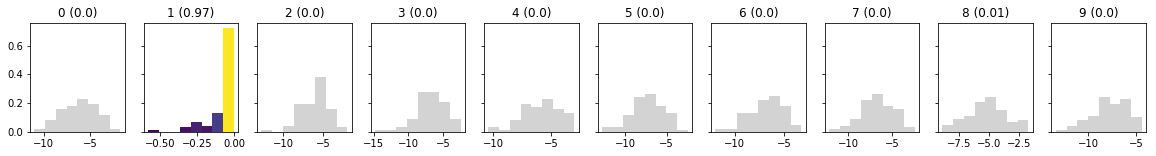

Incorrect :()
-------------------------
Real:  0


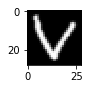

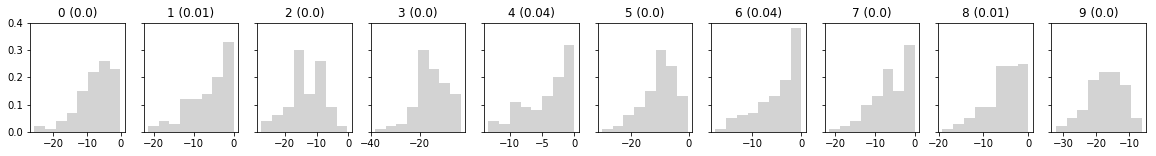

Undecided.
-------------------------
Real:  0


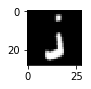

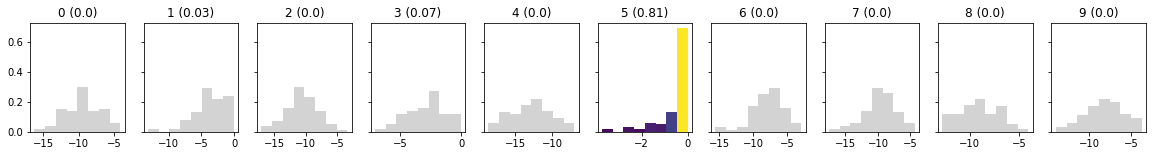

Incorrect :()
-------------------------
Real:  0


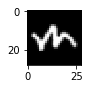

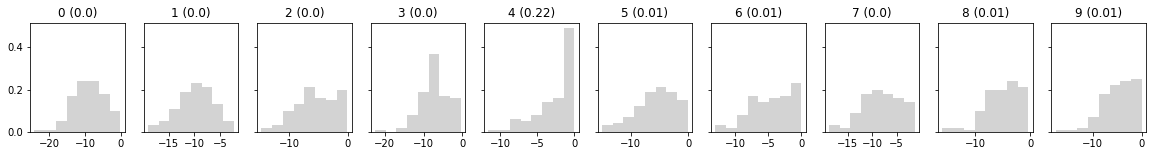

Undecided.
-------------------------
Real:  0


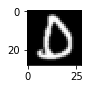

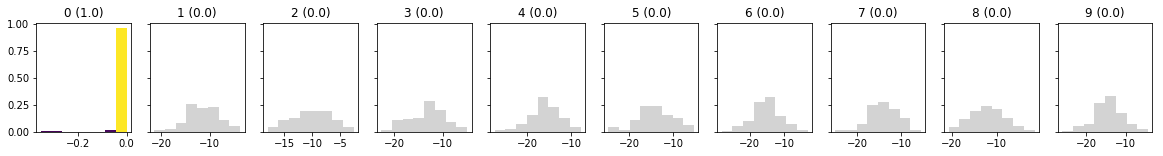

Correct
-------------------------
Real:  0


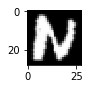

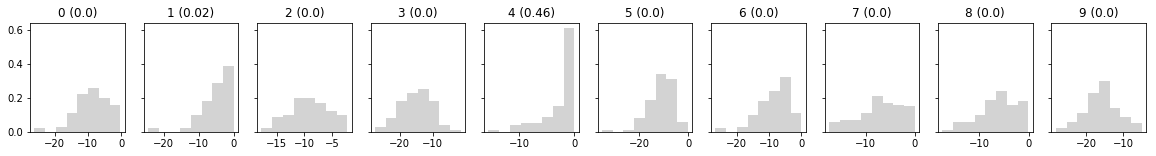

Undecided.
-------------------------
Real:  0


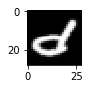

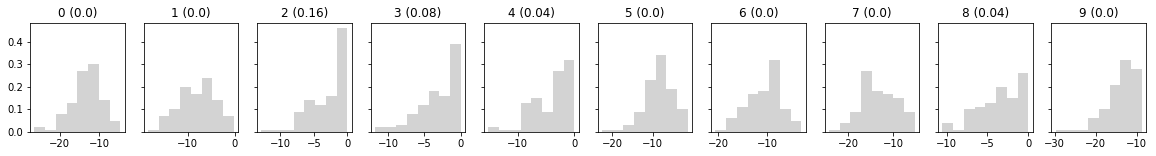

Undecided.
-------------------------
Real:  0


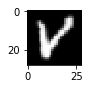

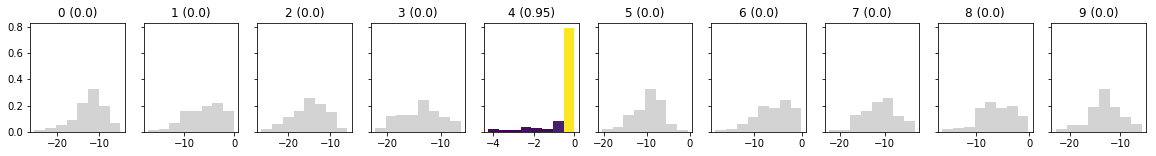

Incorrect :()
-------------------------
Summary
Total images:  100
Predicted for:  58
Accuracy when predicted:  0.20689655172413793


In [89]:
total, correct, predictions = test_batch(emnist_x, logprobs, stub_emnist_y, threshold=0.70, plot=True)

In [91]:
print("total : ", total)
print("correct : ", correct)
print("predictions : ", predictions)
print("Undecided: ", total - predictions)

total :  100
correct :  12.0
predictions :  58
Undecided:  42


# Test Data Visualization (Simone)

Ricarica il dataset per farla funzionare

In [0]:
# let's test the model on mnist test data
output = np.empty(len(x_test), dtype=int)
with tf.compat.v1.Session() as sess:
  sess.run(init_op)
  saver = tf.train.import_meta_graph('my_test_model.meta')
  saver.restore(sess,tf.train.latest_checkpoint('./'))
  x = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32)
  predictions_array = sess.run((tf.nn.softmax(model(x), 1)), {x:x_test})  # get the prediction PROBS
  
for i, element in enumerate(predictions_array):
  output[i] = np.argmax(element)
tot = 0
correct = 0
for i in range(len(output)):
  tot += 1
  if output[i] == y_test[i]:
    correct +=1
print("Accuracy on Test: %.3f" % (correct/float(tot)))
print('Test Sample label: %d' % y_test[5])
print('Model prediction: %d with probability: %f' % (np.argmax(predictions_array[5]), max(predictions_array[5])))


Accuracy on Test: 0.977
Test Sample label: 1
Model prediction: 1 with probability: 1.000000


In [0]:
def plot_image(i, predictions_array, img):
  predictions, img = predictions_array[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  predicted_label = np.argmax(predictions)
  plt.imshow(img.reshape((28, 28)), cmap=plt.cm.binary)
  color = 'red'
  plt.xlabel("Predict %s with %.2f%%" % (str(predicted_label), predictions[predicted_label] * 100), color=color)
  #plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
  #                              100*np.max(predictions_array),
  #                              class_names[true_label]),
  #                              color=color)

  
def plot_value_array(i, predictions_array):
  class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
  predictions_array = predictions_array[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  plt.xticks(range(10), class_names, rotation='horizontal')
  thisplot[predicted_label].set_color('red')

Showing 5 right predicted images


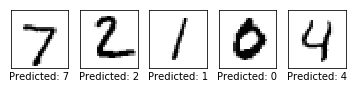




Showing 5 mislabeled images


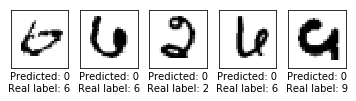




 Wrong predicts probability analysis


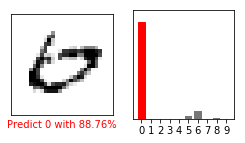

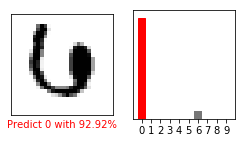

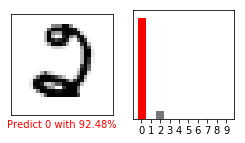

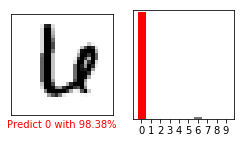

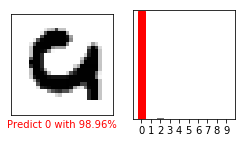

In [0]:
# Analyze uncertainty among corrected and false predicted
# classes and show most confusing images for the net.

###
### Show Right Labels
###
# Key: right labeled index 
# Value: label
right = {}
for i in range(len(output)):
  if output[i] == y_test[i]:
    right[i] = y_test[i]
   
  
print("Showing 5 right predicted images")
for i, (index, label) in enumerate(right.items()):
  if(i == 5):
    break
  plt.subplot(1,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_test[index].reshape((28, 28)), cmap=plt.cm.binary)
  plt.xlabel("Predicted: %s" % label)
plt.show()


###
### Show Wrong Labels
###
# Key: mislabeled index 
# Value: real value
mislabeled = {}
for i in range(len(output)):
  if (output[i] != y_test[i] and np.argmax(predictions_array[i] < 0.6)):
    mislabeled[i] = output[i]

print("\n\n\nShowing 5 mislabeled images")
for i, (index, label) in enumerate(mislabeled.items()):
  if(i == 5):
    break
  plt.subplot(1,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_test[index].reshape((28, 28)), cmap=plt.cm.binary)
  plt.xlabel("Predicted: %s\nReal label: %s" % 
             (label, y_test[index]))
plt.show()
  
print("\n\n\n Wrong predicts probability analysis")
for i, (index, label) in enumerate(mislabeled.items()):
  if(i == 5):
    break
  plt.figure(figsize=(4,2))
  plt.subplot(1,2,1)
  plot_image(index, predictions_array, x_test)
  plt.subplot(1,2,2)
  plot_value_array(index, predictions_array)
  plt.show()

# EMNIST Test

In [0]:
# load emnist
!pip install emnist

In [0]:
print(images.shape)

In [0]:
print(images[:100].shape)

In [0]:
n_test = 10000
output = np.empty(n_test)
# let's test the model on mnist test data
predictions_array = sess.run(tf.nn.softmax(model(x)), {x:images[:n_test]})  # get the prediction
predictions = sess.run(model(x), {x:x_test})  # get the prediction
for i, element in enumerate(predictions_array):
  output[i] = np.argmax(element)
#output = sess.run(tf.argmax(model(x), 1), {x:x_test})  # get the prediction
tot = 0
correct = 0
for i in range(len(output)):
  tot += 1
  if output[i] == labels[i]:
    correct +=1
print("Accuracy on Test: %.3f" % (correct/float(tot)))

In [0]:
# Analyze uncertainty among corrected and false predicted
# classes and show most confusing images for the net.

###
### Show Wrong Labels
###
# Key: mislabeled index 
# Value: real value
mislabeled = {}
for i in range(len(output)):
  if output[i] != labels[i]:
    mislabeled[i] = output[i]

print("\n\n\nShowing 5 mislabeled images")
for i, (index, label) in enumerate(mislabeled.items()):
  if(i == 5):
    break
  plt.subplot(1,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(images[index].reshape((28, 28)), cmap=plt.cm.binary)
  plt.xlabel("Predicted: %d\n" % label)
plt.tight_layout()
plt.show()

print("\n\n\n Wrong predicts probability analysis")
for i, (index, label) in enumerate(mislabeled.items()):
  if(i == 5):
    break
  plt.figure(figsize=(4,2))
  plt.subplot(1,2,1)
  plot_image(index, predictions_array, images)
  plt.subplot(1,2,2)
  plot_value_array(index, predictions_array)
  plt.show()

In [0]:
# USE THIS FOR PLOTTING UNCERTAINTY ON EMNIST DATASET!!!
# plotting uncertainty, WORKING alli
# FEED DATA as "feed dict"
batch_indices = np.random.choice(len(x_val), batch_size, replace=False)
batch_x = x_val[batch_indices] 
batch_y = y_val[batch_indices]

feed_dict = {x: batch_x, y: batch_y, n: batch_size}
  
init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                     tf.compat.v1.local_variables_initializer())

with tf.compat.v1.Session() as sess:
  sess.run(init_op)
  
  # Compute log prob of heldout set by averaging draws from the model:
  # p(heldout | train) = int_model p(heldout|model) p(model|train)
  #                   ~= 1/n * sum_{i=1}^n p(heldout | model_i)
  # where model_i is a draw from the posterior p(model|train).
  probs = np.asarray([sess.run((labels_distribution.probs), feed_dict=feed_dict) for _ in range(num_monte_carlo)])
  mean_probs = np.mean(probs, axis=0)

  # Placeholders! If you change dataset change dim!!!
  images = tf.placeholder(tf.float32,shape=[None,28,28,1])
  labels = tf.placeholder(tf.int32,shape=[None,])

  image_vals, label_vals = sess.run((images, labels), feed_dict={images: batch_x, labels: batch_y})
  
  heldout_lp = np.mean(np.log(mean_probs[np.arange(mean_probs.shape[0]),
                                           label_vals.flatten()]))
  print(" ... Held-out nats: {:.3f}".format(heldout_lp))

  qm_vals, qs_vals = sess.run((qmeans, qstds))

  if HAS_SEABORN:
    plot_weight_posteriors(names, qm_vals, qs_vals,fname=os.path.join(viz_dir, "step{:05d}_weights.png".format(step)))
    plot_heldout_prediction(image_vals, probs,fname=os.path.join(viz_dir,"step{:05d}_pred.png".format(step)), title="mean heldout logprob {:.2f}".format(heldout_lp))

